In [ ]:
# Import depedencies
from google.colab import files
uploaded = files.upload()

import pandas as pd

Saving pharmacy_sales_analytics.csv to pharmacy_sales_analytics.csv


In [ ]:
def wrangle(filepath):
    """
    This function cleans a csv file by removing every duplicate, every inconsistency
    and filling in missing values

    Args:
        filepath (csv): contains different details on several drug transactions
    """

    try:
        # Import the file
        df = pd.read_csv(filepath)

        # Change Date column to datetime data type
        df["Date"] = pd.to_datetime(df["Date"], format="mixed")

        # Change Expiry_Date to datetime data type
        df["Expiry_Date"] = pd.to_datetime(df["Expiry_Date"], format="mixed")

        # Drop duplicates
        df.drop_duplicates(inplace=True)

        # Fill the missing values in this columns with Unknown
        for col in ['Pharmacy', 'Drug', 'Brand', 'Supplier_Name']:
            df[col] = df[col].fillna("Unknown")

        # Fill Missing values in 'Price' by the median price of the Drug and the Brand
        df["Price"] = df.groupby(
            ["Drug", "Brand"])["Price"].transform(lambda x: x.fillna(x.median())
        )

        # Fill Missing values in 'Quantity' with the median quantity of the drug and brand sold in each pharmacy
        df["Quantity"] = df.groupby(
            ["Drug", "Brand", "Pharmacy"])["Quantity"].transform(lambda x: x.fillna(x.median())
        )

        # Create a temporary sort, but keep track of original order
        df["row_order"] = range(df.shape[0])

        # Sort by Pharmacy and Date
        df = df.sort_values(["Pharmacy", "Date"])

        # Forward fill missing dates within each pharmacy
        df["Date"] = df.groupby("Pharmacy")["Date"].ffill()

        # Restore original order
        df = df.sort_values(by="row_order").drop(columns="row_order")

        return df

    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"An error occured during data cleaning: {e}")
        return None

In [ ]:
# Import data
pharm_data = wrangle("pharmacy_sales_analytics.csv")
pharm_data.head()

Date                    Pharmacy Location         Drug        Brand  \
0 2024-02-12                    Ryan PLC    Urban  Amoxicillin  HealthFirst   
1 2024-11-14      Baker, Mason and White    Rural  Amoxicillin  Hea1thFirst   
2 2025-12-03                  Spence PLC    Rural    Ibuprofen      BioCare   
3 2024-07-16  Watts, Robinson and Nguyen    Rural  Paracetamol      BioCare   
4 2025-03-14                 Harrell LLC    Rural  Amoxicillin     MediPlus   

     Price  Quantity              Supplier_Name Batch_Number Expiry_Date  \
0  1271.41      95.0  Robinson, Jones and Welch  fA-39909-QL  2026-09-07   
1  1316.77      78.0      Brooks, Lam and Hayes  qz-54353-iQ  2026-09-09   
2  4085.27       1.0                  Novak PLC  NK-75107-ge  2026-06-17   
3   690.61      49.0  Robinson, Jones and Welch  px-84251-sk  2026-01-04   
4  4870.96      49.0           Chapman and Sons  QJ-84980-tQ  2025-07-15   

  Sales_Channel  Drug_Form  
0  Market Stall     Tablet  
1  Market Stall      Syrup  
2      In-Store    Capsule  
3    Mobile Van  Injection  
4  Market Stall  Injection

# **Price** **Analysis**

In [ ]:
pharm_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           10000 non-null  datetime64[ns]
 1   Pharmacy       10000 non-null  object        
 2   Location       9999 non-null   object        
 3   Drug           10000 non-null  object        
 4   Brand          10000 non-null  object        
 5   Price          10000 non-null  float64       
 6   Quantity       10000 non-null  float64       
 7   Supplier_Name  10000 non-null  object        
 8   Batch_Number   10000 non-null  object        
 9   Expiry_Date    10000 non-null  datetime64[ns]
 10  Sales_Channel  10000 non-null  object        
 11  Drug_Form      10000 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(8)
memory usage: 1015.6+ KB


In [ ]:
pharm_data.nunique()

Date               366
Pharmacy            51
Location             2
Drug                11
Brand                9
Price             9876
Quantity           102
Supplier_Name       30
Batch_Number     10000
Expiry_Date        730
Sales_Channel        3
Drug_Form            4
dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

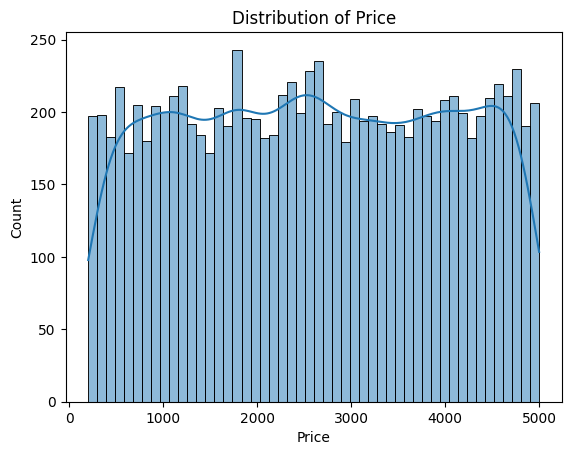

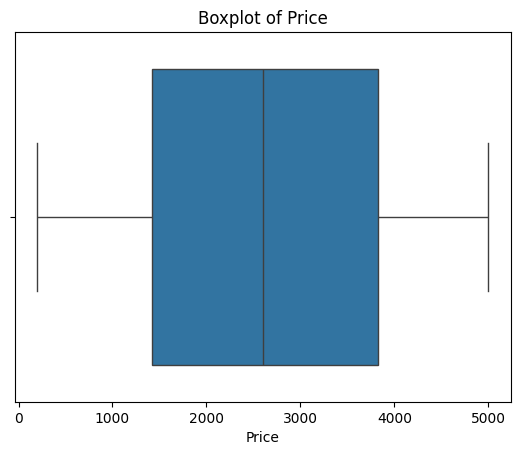

In [ ]:
# Histogram
sns.histplot(pharm_data['Price'], kde=True, bins=50)
plt.title("Distribution of Price")
plt.show()

# Boxplot for outliers
sns.boxplot(x=pharm_data['Price'])
plt.title("Boxplot of Price")
plt.show()

The distribution of price has no significant outliers

## **Price vs. Location**

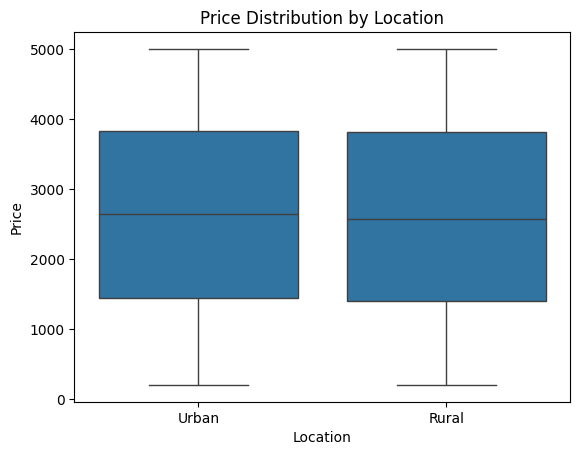

count         mean          std     min        25%       50%  \
Location                                                                  
Rural     5047.0  2600.745011  1391.013871  201.18  1397.1500  2566.520   
Urban     4952.0  2631.531925  1381.809493  200.81  1449.3325  2635.715   

               75%      max  
Location                     
Rural     3820.265  4999.85  
Urban     3832.960  4999.78

In [ ]:
sns.boxplot(x="Location", y="Price", data=pharm_data)
plt.title("Price Distribution by Location")
plt.show()

pharm_data.groupby("Location")["Price"].describe()

There is no significant difference between prices in rural and urban areas.

## **Price vs. Drug & Brand**

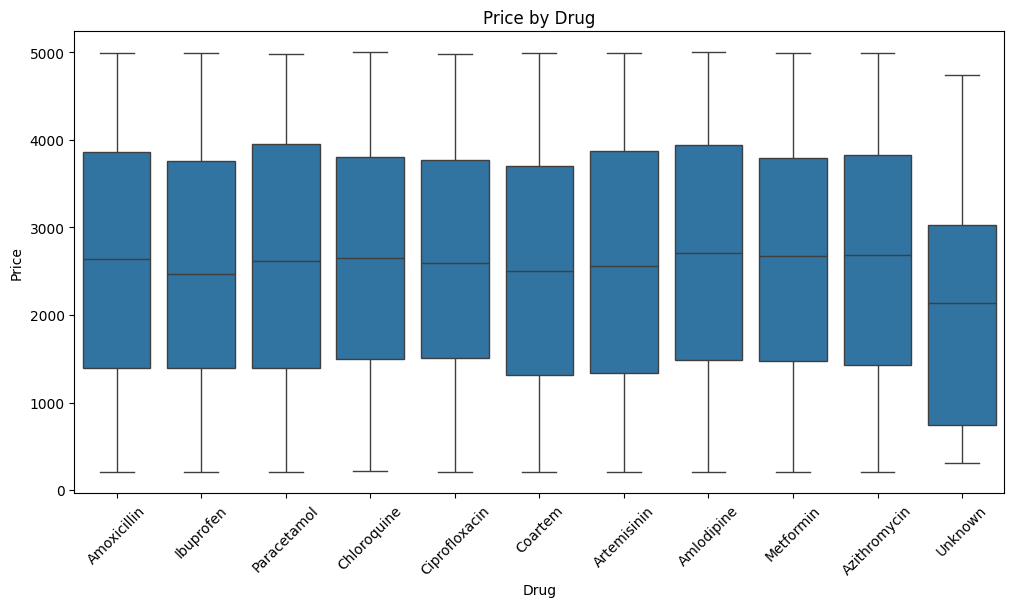

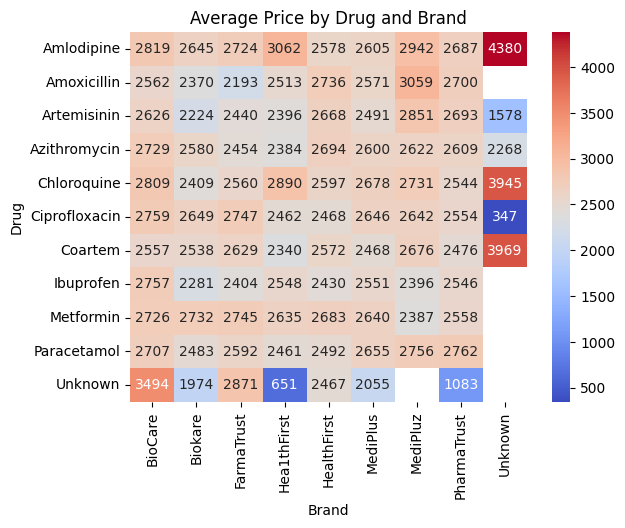

In [ ]:
pharm_data.groupby("Drug")["Price"].mean().sort_values()

#Boxplot
plt.figure(figsize=(12,6))
sns.boxplot(x="Drug", y="Price", data=pharm_data)
plt.xticks(rotation=45)
plt.title("Price by Drug")
plt.show()

# Heatmap: Drug × Brand
pivot = pharm_data.pivot_table(values="Price", index="Drug", columns="Brand", aggfunc="mean")
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Average Price by Drug and Brand")
plt.show()


Most brands are consistent, but Unknown brands have highly variable pricing (sometimes much cheaper, sometimes extremely expensive)

## Price vs. Sales Channel

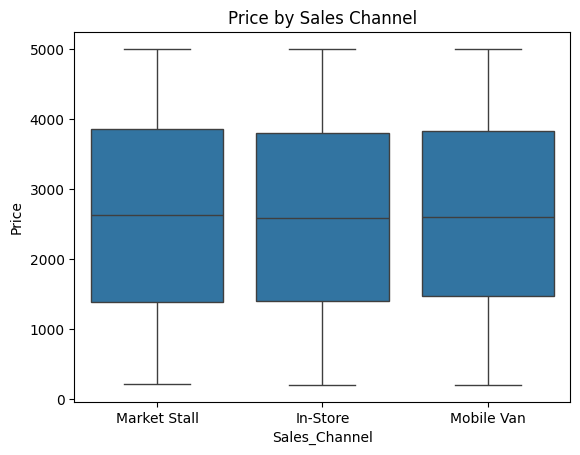

Sales_Channel
In-Store        2601.550020
Market Stall    2619.404593
Mobile Van      2626.599188
Name: Price, dtype: float64

In [ ]:
sns.boxplot(x="Sales_Channel", y="Price", data=pharm_data)
plt.title("Price by Sales Channel")
plt.show()

pharm_data.groupby("Sales_Channel")["Price"].mean()


## Price vs. Drug Form

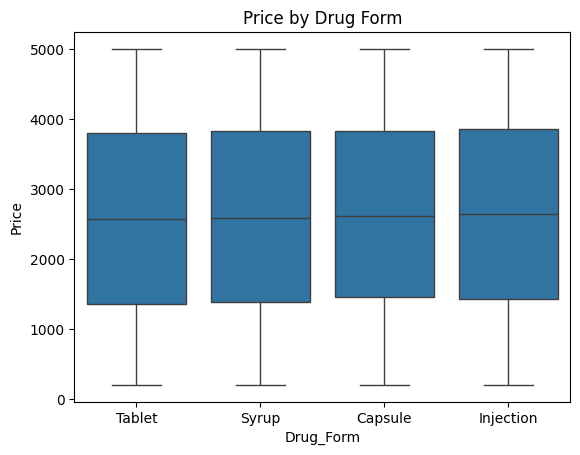

Drug_Form
Capsule      2637.527418
Injection    2630.098731
Syrup        2605.691821
Tablet       2589.105430
Name: Price, dtype: float64

In [ ]:
sns.boxplot(x="Drug_Form", y="Price", data=pharm_data)
plt.title("Price by Drug Form")
plt.show()

pharm_data.groupby("Drug_Form")["Price"].mean()


## Price vs. Supplier / Pharmacy

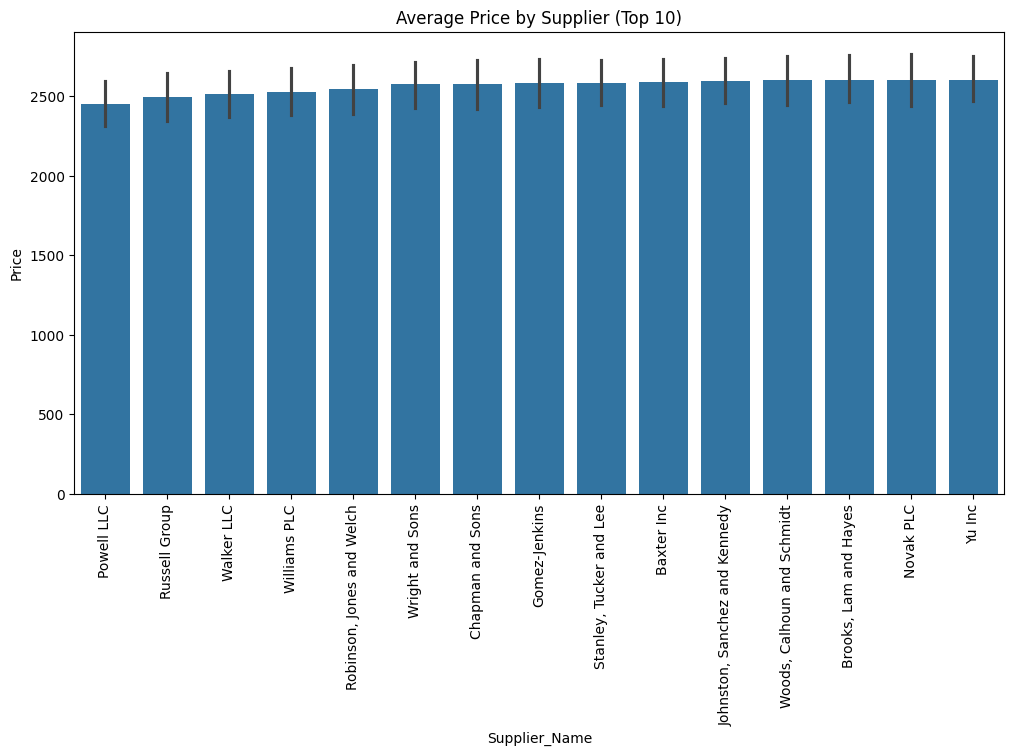

In [ ]:
# Top 10 suppliers by avg price
pharm_data.groupby("Supplier_Name")["Price"].mean().sort_values(ascending=False).head(15)

# Visualization
plt.figure(figsize=(12,6))
sns.barplot(x="Supplier_Name", y="Price", data=pharm_data, estimator="mean", order=pharm_data.groupby("Supplier_Name")["Price"].mean().sort_values().index[:15])
plt.xticks(rotation=90)
plt.title("Average Price by Supplier (Top 10)")
plt.show()


## Price vs. Expiry Date Proximity

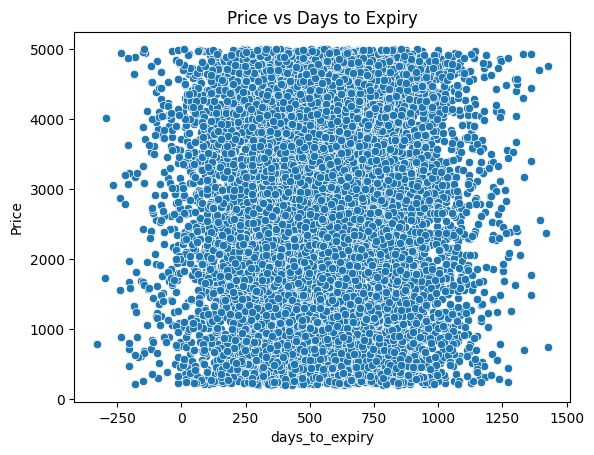

In [ ]:
# Create days-to-expiry
pharm_data['Expiry_Date'] = pd.to_datetime(pharm_data['Expiry_Date'], dayfirst=True, errors='coerce')
pharm_data['days_to_expiry'] = (pharm_data['Expiry_Date'] - pharm_data['Date']).dt.days

# Scatter plot
sns.scatterplot(x="days_to_expiry", y="Price", data=pharm_data)
plt.title("Price vs Days to Expiry")
plt.show()


## Price vs. Quantity

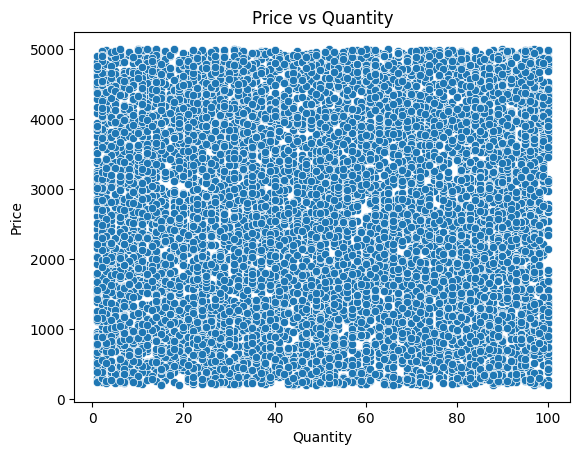

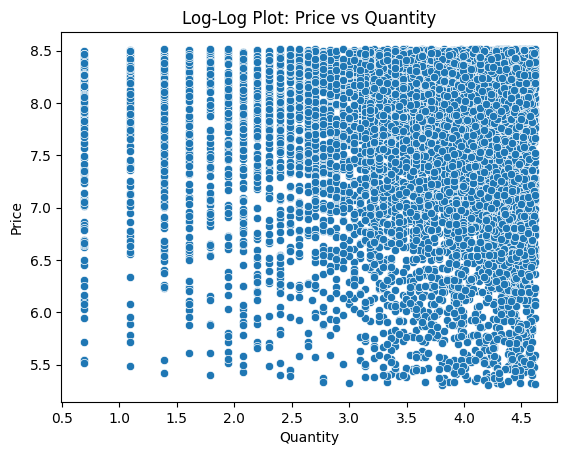

In [ ]:
sns.scatterplot(x="Quantity", y="Price", data=pharm_data)
plt.title("Price vs Quantity")
plt.show()

# Log transform for better view
sns.scatterplot(x=np.log1p(pharm_data["Quantity"]), y=np.log1p(pharm_data["Price"]))
plt.title("Log-Log Plot: Price vs Quantity")
plt.show()


## Time Trends

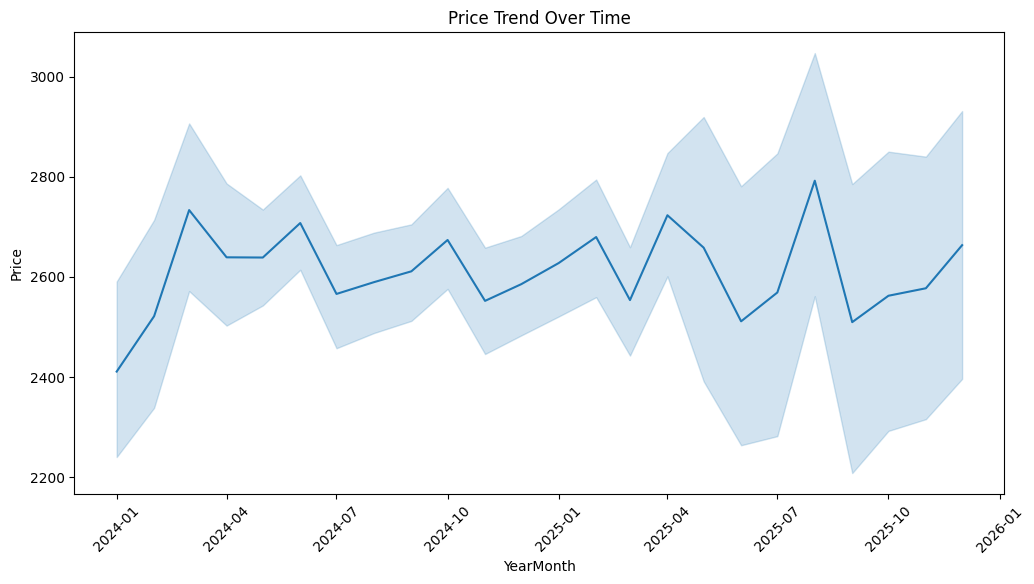

In [ ]:
pharm_data['YearMonth'] = pharm_data['Date'].dt.to_period("M").dt.to_timestamp()

plt.figure(figsize=(12,6))
sns.lineplot(x="YearMonth", y="Price", data=pharm_data, estimator="mean")
plt.xticks(rotation=45)
plt.title("Price Trend Over Time")
plt.show()


### TREND ANALYSIS

In [ ]:
# Convert data type of quantity column to integer
pharm_data['Quantity']= pharm_data['Quantity'].astype('int')

In [ ]:
# Creating a Revenue column from Quantity and Price
pharm_data['Revenue']= pharm_data['Quantity'] * pharm_data['Price']


In [ ]:
# Creating year column from the date column
pharm_data['Year'] = pharm_data['Date'].dt.year

# Creating a Month name column from the Date column
pharm_data['Month_Name'] = pharm_data['Date'].dt.strftime('%b')  # Jan, Feb, Mar...

# Getting the month from the Date column
pharm_data['Month'] = pharm_data['Date'].dt.month  # Numeric month for sorting


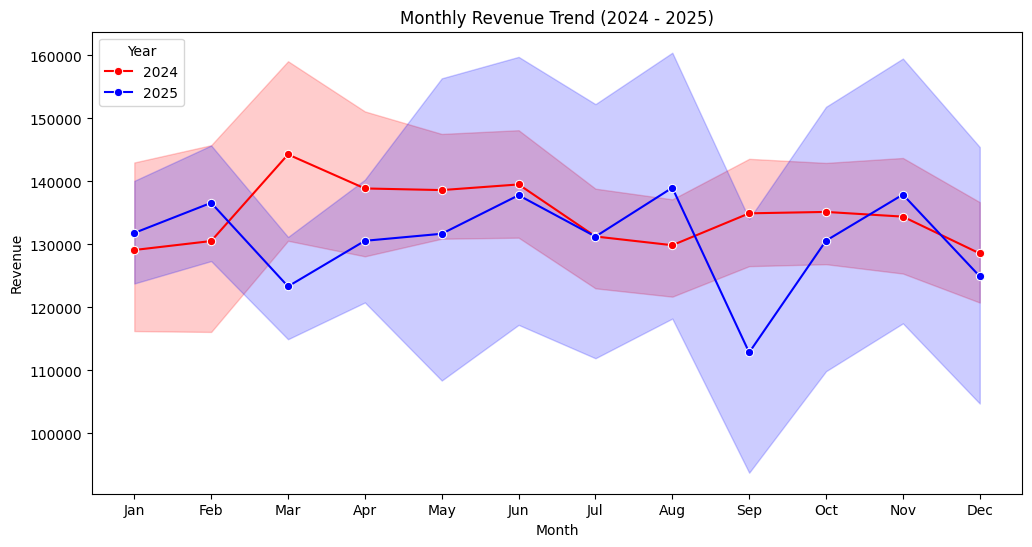

In [ ]:
# Make sure Month_Name is ordered correctly (Jan to Dec)
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Ensure months are an ordered categorical variable
#(so plots and analysis follow calendar order instead of alphabetical order)
pharm_data["Month_Name"] = pd.Categorical(
    pharm_data["Month_Name"],
    categories=month_order,
    ordered=True
)

# Define custom colors for each year
custom_palette = {
    2024: "red",
    2025: "blue",
}

# Plotting line chart
plt.figure(figsize=(12,6))
sns.lineplot(
    data=pharm_data,
    x='Month_Name',
    y='Revenue',
    hue='Year',
    marker='o',
    palette=custom_palette
)

plt.title('Monthly Revenue Trend (2024 - 2025)')
plt.ylabel('Revenue')
plt.xlabel('Month')
plt.legend(title="Year")
plt.show()


In [ ]:
# Create a proper Year-Month column (datetime)
pharm_data['Year_Month'] = pd.to_datetime(
    pharm_data['Year'].astype(str) + '-' + pharm_data['Month'].astype(str) + '-01'
)

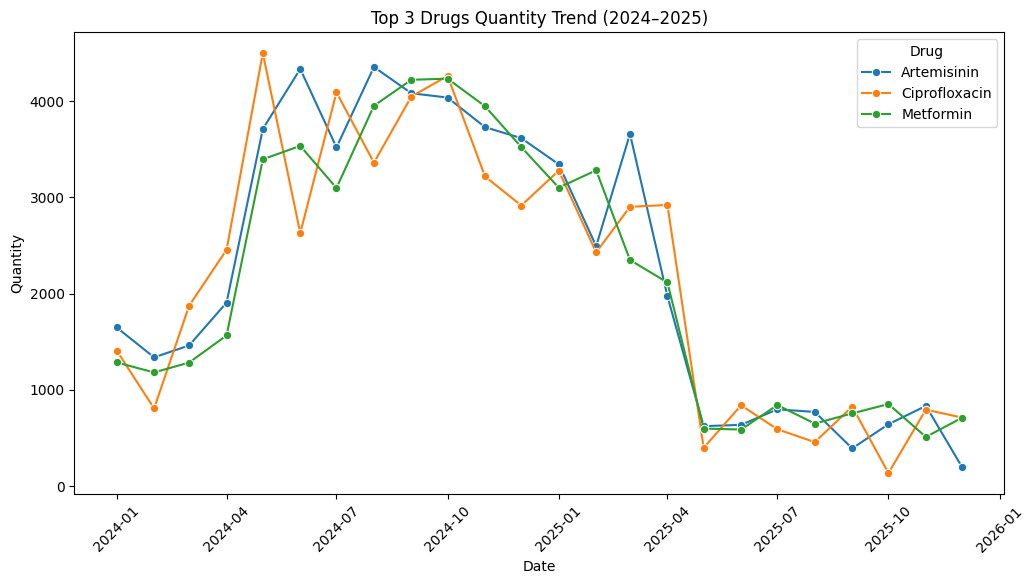

In [ ]:
# Group Quantity by Drug and Year_Month
drug_quantity_trend = (
    pharm_data.groupby(['Drug', 'Year_Month'])['Quantity']
    .sum()
    .reset_index()
)

# Get top 3 drugs overall by quantity,
top_drugs = (
    drug_quantity_trend.groupby('Drug')['Quantity']
    .sum()
    .nlargest(3)
    .index
)

# Filter only top 3 drugs
filtered_data = drug_quantity_trend[drug_quantity_trend['Drug'].isin(top_drugs)]

# Plot line graph
plt.figure(figsize=(12, 6))
sns.lineplot(data=filtered_data, x='Year_Month', y='Quantity', hue='Drug', marker='o')
plt.title('Top 3 Drugs Quantity Trend (2024–2025)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.xticks(rotation=45)  # Rotate labels for readability
plt.show()


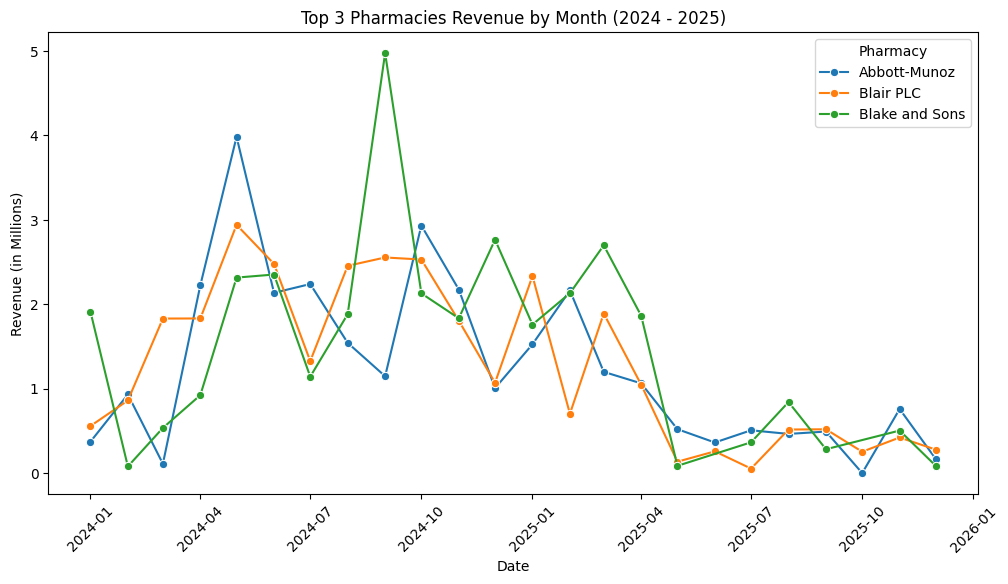

In [ ]:
# Group revenue by Pharmacy and Year_Month
pharmacy_sales= pharm_data.groupby(['Pharmacy', 'Year_Month'])['Revenue'].sum().reset_index()

# Convert to millions
pharmacy_sales['Revenue_Millions']= pharmacy_sales['Revenue']/ 1_000_000

# Get top 3 pharmacies by total revenue
top_pharmacies= pharmacy_sales.groupby('Pharmacy')['Revenue_Millions'].sum().nlargest(3). index

# Filter for only top 3 pharmacies
filtered_pharmacies= pharmacy_sales[pharmacy_sales['Pharmacy'].isin(top_pharmacies)]

# Plotting graph of top pharmacies by revenue
plt.figure(figsize= (12,6))
sns.lineplot(data= filtered_pharmacies, x= 'Year_Month', y= 'Revenue_Millions', hue= 'Pharmacy', marker= 'o')
plt.title('Top 3 Pharmacies Revenue by Month (2024 - 2025)')
plt.xlabel('Date')
plt.ylabel('Revenue (in Millions)')
plt.xticks(rotation= 45)
plt.show()

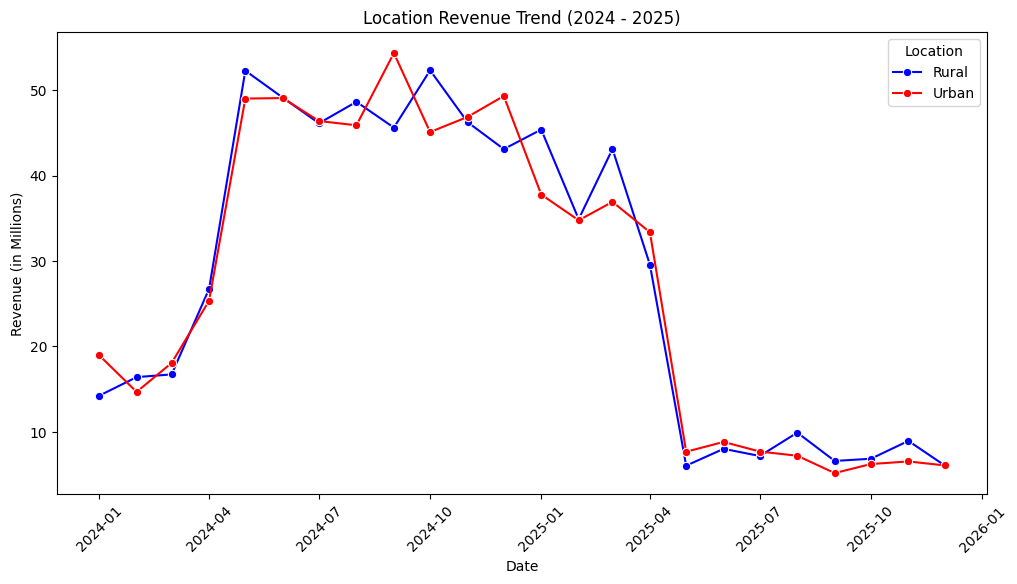

In [ ]:
# Group Revenue by Location and Year_month
location_sales= pharm_data.groupby(['Location', 'Year_Month'])['Revenue'].sum().reset_index()

# Convert to millions
location_sales['Revenue_Millions']= (location_sales['Revenue'] / 1_000_000).round(2)

# Getting palette for each category in Location column
location_palette= {
    'Urban':'red',
    'Rural': 'blue'
}

# Plotting line graph
plt.figure(figsize= (12,6))
sns.lineplot(data= location_sales, x= 'Year_Month',y= 'Revenue_Millions', hue= 'Location', marker= 'o', palette= location_palette)
plt.title('Location Revenue Trend (2024 - 2025)')
plt.xlabel('Date')
plt.ylabel('Revenue (in Millions)')
plt.xticks(rotation = 45)
plt.show()

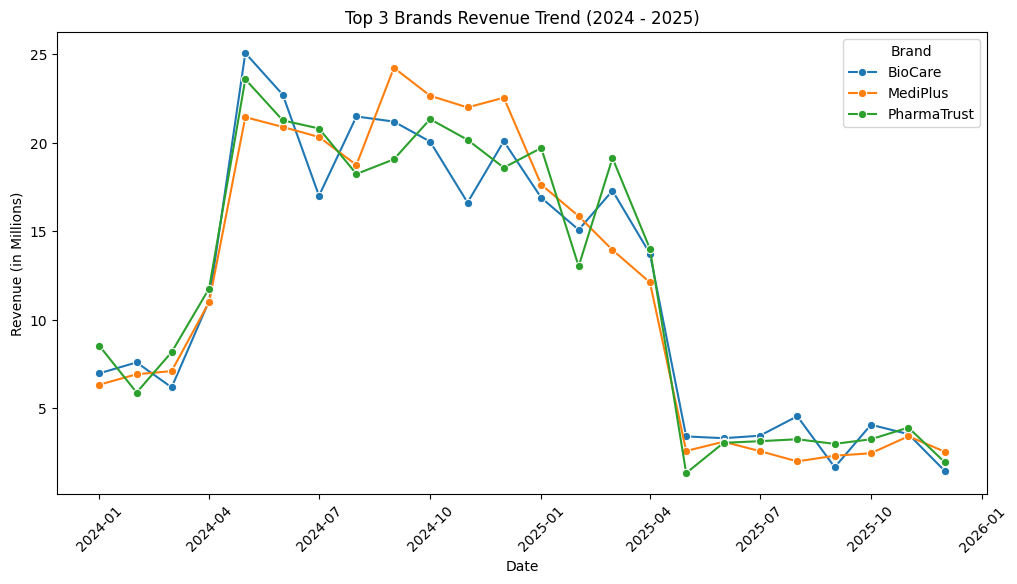

In [ ]:
# Group Revenue by Brand and Year_month
brand_sales= pharm_data.groupby(['Brand', 'Year_Month'])['Revenue'].sum().reset_index()

# Converting to Millions
brand_sales['Revenue_Millions']= (brand_sales['Revenue'] / 1_000_000).round(2)

# Get top 3 brands by total revenue
top_brands= brand_sales.groupby('Brand')['Revenue_Millions'].sum().nlargest(3).index

# # Filter for only top 3 brands
filtered_brands= brand_sales[brand_sales['Brand'].isin(top_brands)]

# Plotting line graph
plt.figure(figsize=(12, 6))
sns.lineplot(data= filtered_brands, x='Year_Month', y= 'Revenue_Millions', hue= 'Brand', marker= 'o')
plt.title('Top 3 Brands Revenue Trend (2024 - 2025)')
plt.xlabel('Date')
plt.ylabel('Revenue (in Millions)')
plt.xticks(rotation= 45)
plt.show()

### SALES ANALYSIS

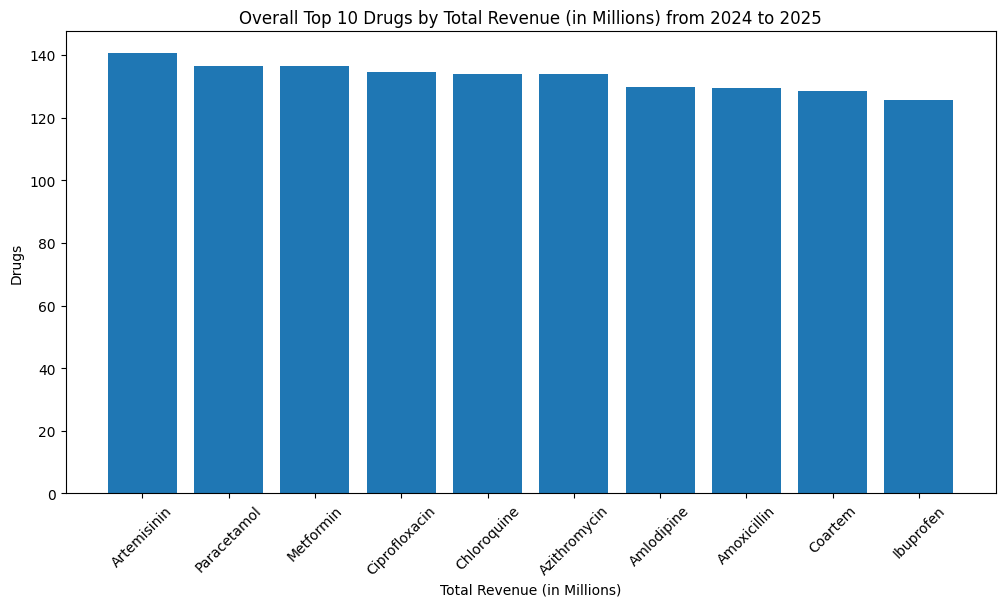

In [ ]:
# Overall Total sales of drugs from 2024- 2025
overall_sales=pharm_data.groupby('Drug')['Revenue'].sum().sort_values(ascending= False).head(10)

# Converting to Millions
overall_sales= (overall_sales/ 1_000_000).round(2)

# Plot
plt.figure(figsize= (12,6))
plt.bar(overall_sales.index, overall_sales.values)
plt.title('Overall Top 10 Drugs by Total Revenue (in Millions) from 2024 to 2025')
plt.xlabel('Total Revenue (in Millions)')
plt.ylabel('Drugs')
plt.xticks(rotation= 45)
plt.show()

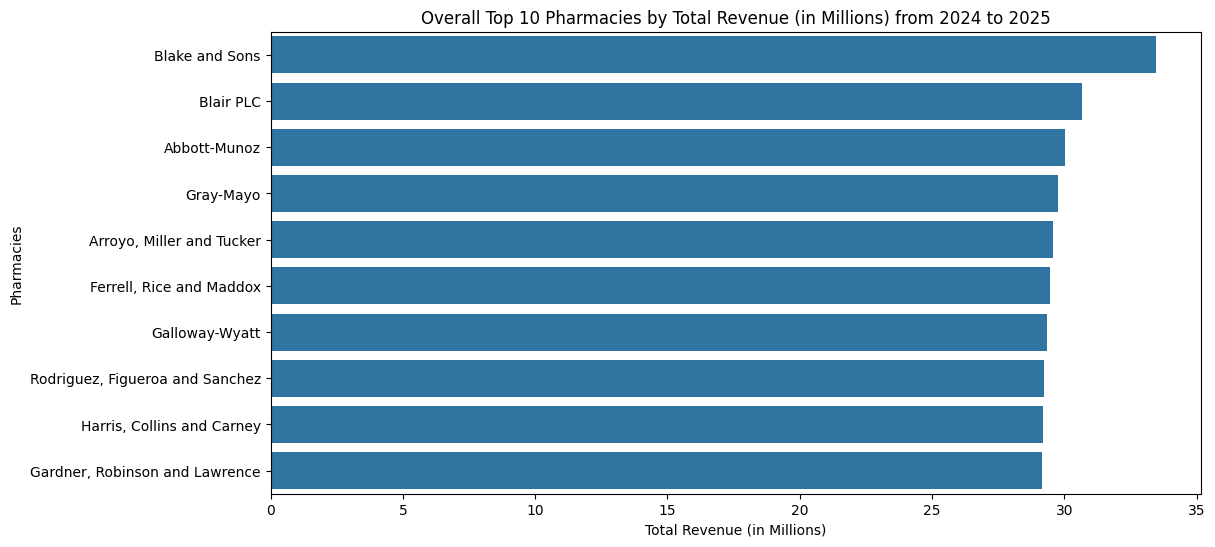

In [ ]:
# Top Performing phamarcies from 2024 to 2025
top_pharmacy_sales= pharm_data.groupby('Pharmacy')['Revenue'].sum().sort_values(ascending= False).head(10)

# Converting to Millions
top_pharmacy_sales= (top_pharmacy_sales/1_000_000).round(2)

# Plot
plt.figure(figsize= (12,6))
sns.barplot(x= top_pharmacy_sales.values, y= top_pharmacy_sales.index)
plt.title('Overall Top 10 Pharmacies by Total Revenue (in Millions) from 2024 to 2025')
plt.xlabel('Total Revenue (in Millions)')
plt.ylabel('Pharmacies')
plt.show()

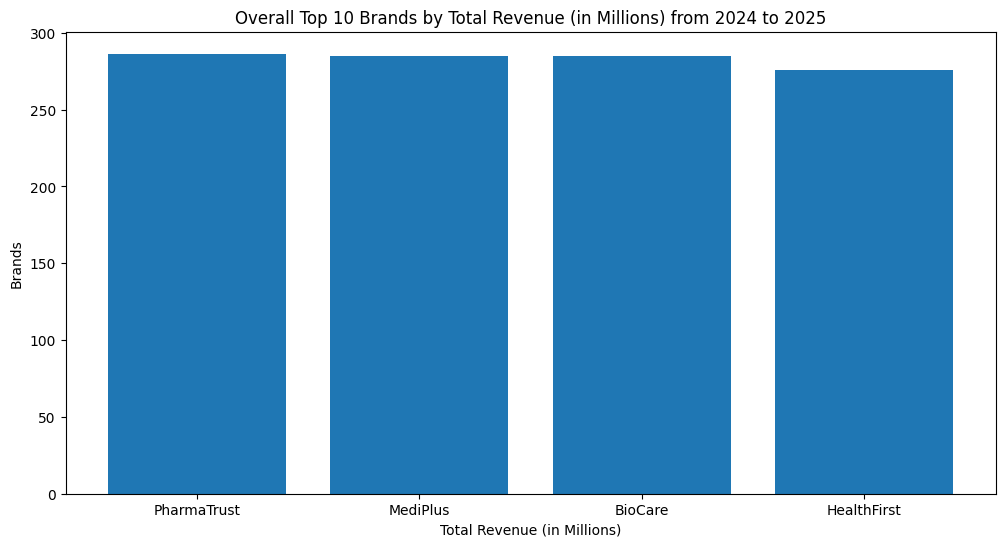

In [ ]:
# Overall top performing brands from 2024 to 2025
top_brand_sales= pharm_data.groupby('Brand')['Revenue'].sum().sort_values(ascending= False).head(4)

# Converting to Millions
top_brand_sales= (top_brand_sales/1_000_000).round(2)

# Plotting graph
plt.figure(figsize= (12,6))
plt.bar(top_brand_sales.index, top_brand_sales.values)
plt.title('Overall Top 10 Brands by Total Revenue (in Millions) from 2024 to 2025')
plt.xlabel('Total Revenue (in Millions)')
plt.ylabel('Brands')
plt.show()

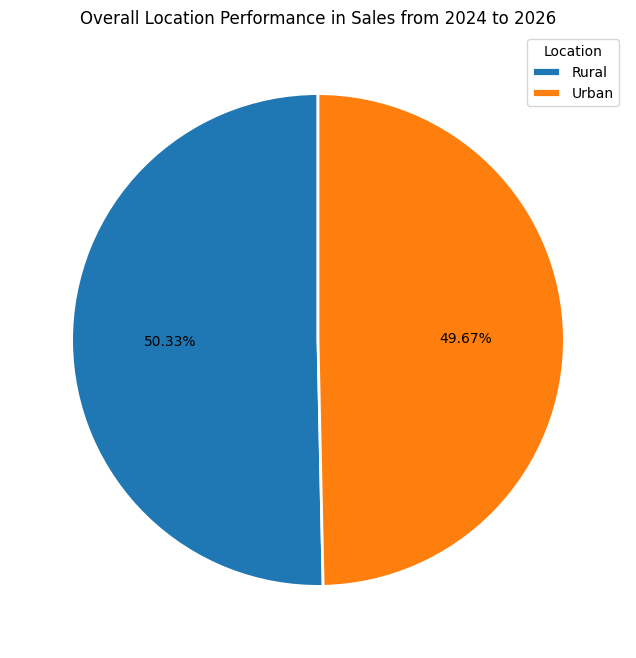

In [ ]:
# Location performance comparison
overall_location_sales= pharm_data.groupby('Location')['Revenue'].sum()

# Converting to Millions
overall_location_sales= (overall_location_sales/1_000_000)

# Plotting pie chart
plt.figure(figsize= (8,8))
plt.pie(
    overall_location_sales.values,
    autopct='%1.2f%%',
    startangle= 90,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
    labeldistance=1.2,   # Pushes labels outside
      )
plt.title('Overall Location Performance in Sales from 2024 to 2026')
# Legend
plt.legend(overall_location_sales.index, title= 'Location')

plt.show()

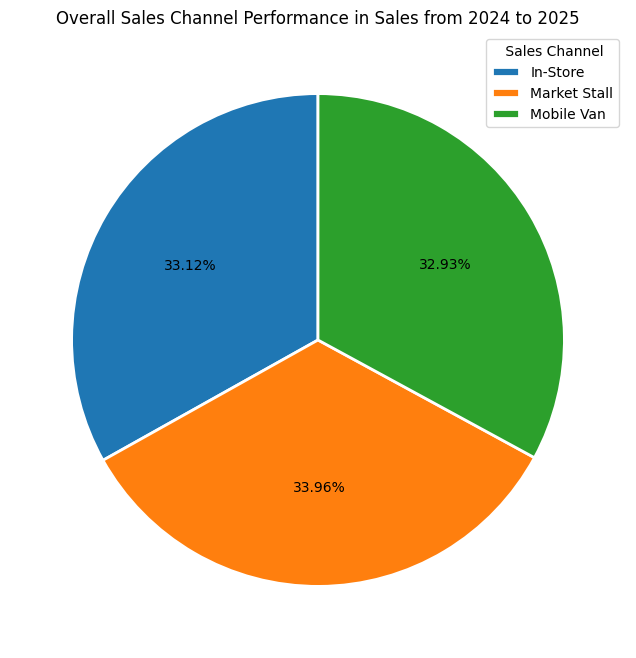

In [ ]:
# Sales Channel that made more sales
sales_channel= pharm_data.groupby('Sales_Channel')['Revenue'].sum()

# Converting to Millions
sales_channel= (sales_channel/1_000_000).round(2)

# Seeing sales channel that had better performance in sales
plt.figure(figsize= (8,8))
plt.pie(
    sales_channel.values,
    autopct='%1.2f%%',
    startangle= 90,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
    labeldistance=1.2,   # Pushes labels outside
    )
plt.title('Overall Sales Channel Performance in Sales from 2024 to 2025')
# Legend
plt.legend(sales_channel.index, title =' Sales Channel')
plt.show()


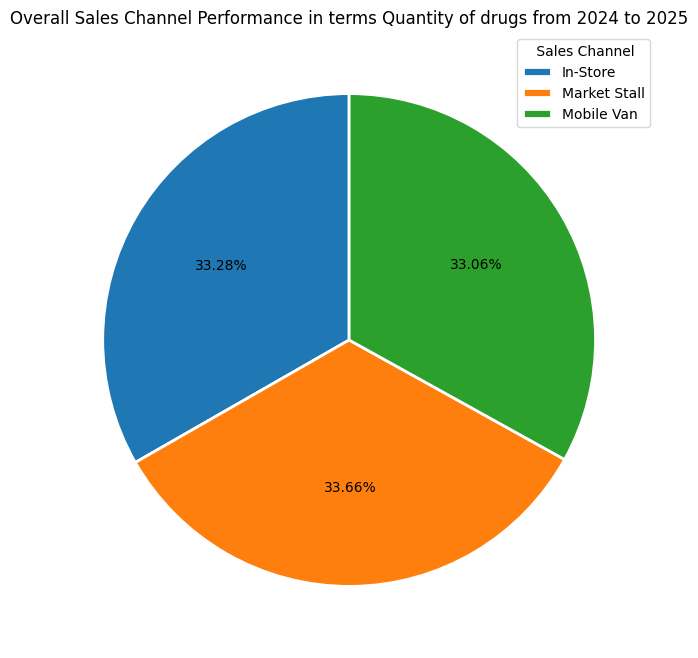

In [ ]:
# Sales Channel that sold more
channel_quantity= pharm_data.groupby('Sales_Channel')['Quantity'].sum()

# Seeing sales channel that had better performance in sales
plt.figure(figsize= (8,8))
plt.pie(
    channel_quantity.values,
    autopct='%1.2f%%',
    startangle= 90,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
    labeldistance=1.2,   # Pushes labels outside
    )
plt.title('Overall Sales Channel Performance in terms Quantity of drugs from 2024 to 2025')
# Legend
plt.legend(channel_quantity.index, title =' Sales Channel')
plt.show()


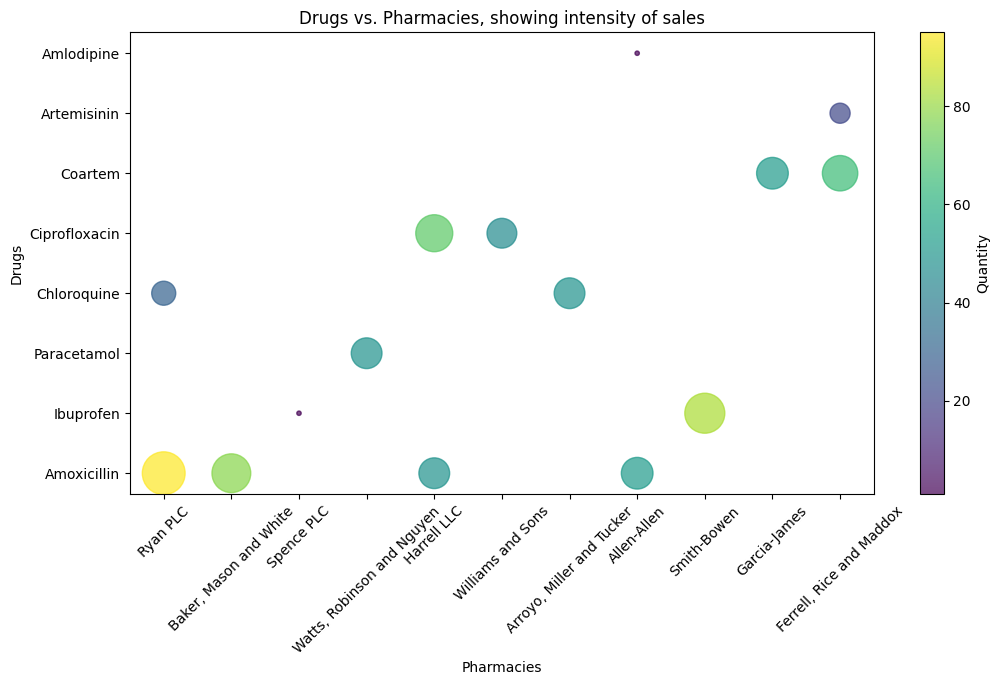

In [ ]:
# Drugs vs. Pharmacies, showing intensity of sales (color scale)
sample= pharm_data.head(15)

# Plot
plt.figure(figsize= (12,6))
plt.scatter(
    x= sample['Pharmacy'],
    y= sample['Drug'],
    c=sample['Quantity'], # Color intensity shows sales
    cmap='viridis',       # Color map (you can try 'plasma', 'coolwarm', etc.)
    s=sample['Quantity'] * 10,              # dot size proportional to sales
    alpha=0.7
          )
plt.colorbar(label="Quantity")
plt.xticks(rotation=45)
plt.title('Drugs vs. Pharmacies, showing intensity of sales')
plt.xlabel('Pharmacies')
plt.ylabel('Drugs')
plt.show()


In [ ]:
# Converting Revenue to Millions
pharm_data['Revenue_Millions']= (pharm_data['Revenue']/1_000_000)

# Pivot-style plots  Sales per Brand across Locations.
pivot_table= pd.pivot_table(
    pharm_data,
    values= 'Revenue_Millions',
    index= 'Location',
    columns= 'Brand',
    aggfunc= sum
)
pivot_table


/tmp/ipython-input-1762002387.py:5: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pivot_table= pd.pivot_table(


Brand        BioCare    Biokare  FarmaTrust  Hea1thFirst  HealthFirst  \
Location                                                                
Rural     140.604671  25.447306   25.935532    24.884089   143.010113   
Urban     144.083859  23.611424   20.896878    26.776751   132.631740   

Brand       MediPlus   MediPluz  PharmaTrust   Unknown  
Location                                                
Rural     139.639606  23.041867   146.995009  0.597388  
Urban     145.296169  28.331338   139.358884  0.324562

## Brand Diversity

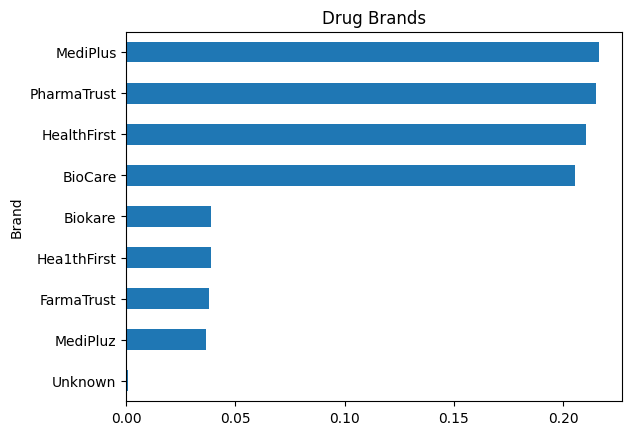

In [ ]:
# Check for Brand distribution across data
pharm = pharm_data.copy()
pharm["Brand"].value_counts(normalize=True).sort_values(ascending=True).plot(
    kind="barh",
    title="Drug Brands"
);

* There are 8 brands of drugs in total, together with "Unknown" brands, makes it 9

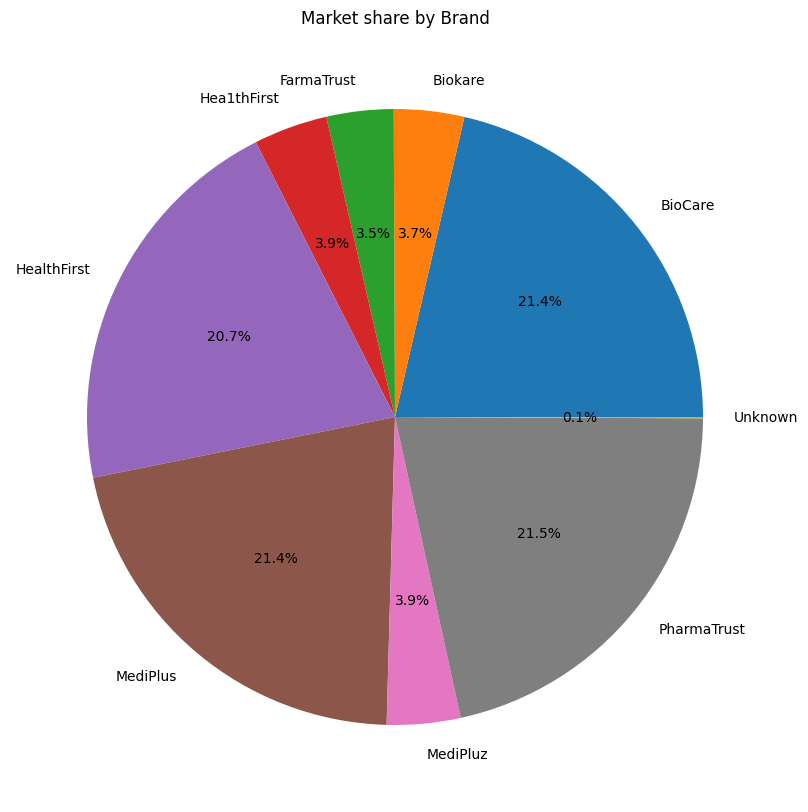

In [ ]:
# Total Sales made by transaction
pharm["total_sales"] = round(pharm["Price"] * pharm["Quantity"], 2)

# create a pivot table of total sales by brand
pivot = pharm.pivot_table(values="total_sales", index="Brand", aggfunc="sum")

# calculate total sales
total = 0
for i in pivot["total_sales"]:
    total += i

# calculate market share for each brand
pivot["market_share"] = pivot["total_sales"] / total

# plot a pie chart to show market share by brand
fig, ax = plt.subplots(figsize=(12, 10))
pivot.plot.pie(y="market_share", autopct='%1.1f%%', legend=False, ax=ax)
plt.title("Market share by Brand")
plt.ylabel('');

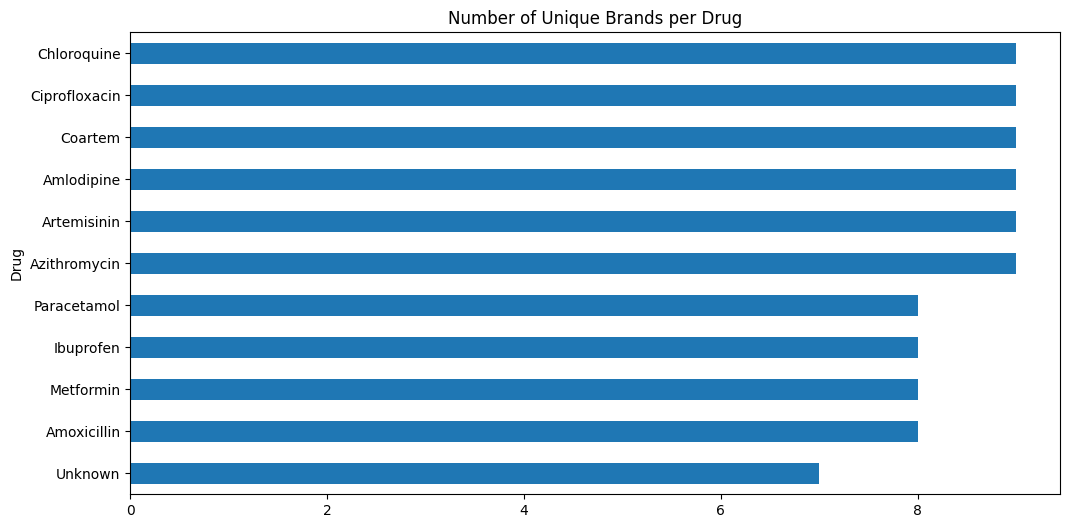

In [ ]:
# How many distinct brands exist for each drug?
brand_per_drug = pharm.groupby("Drug")["Brand"].nunique().sort_values()
brand_per_drug.plot(kind='barh', figsize=(12,6), title='Number of Unique Brands per Drug');

* There are 7 unique brands of Unknown Drugs
* All other drugs have 8 known brands sold, except drugs like Chlororuine, Ciprofloxacin, Coartem, Amlodipine, Artemisinin and Azithrimycin, that have an unknown brand as their 9th brand.

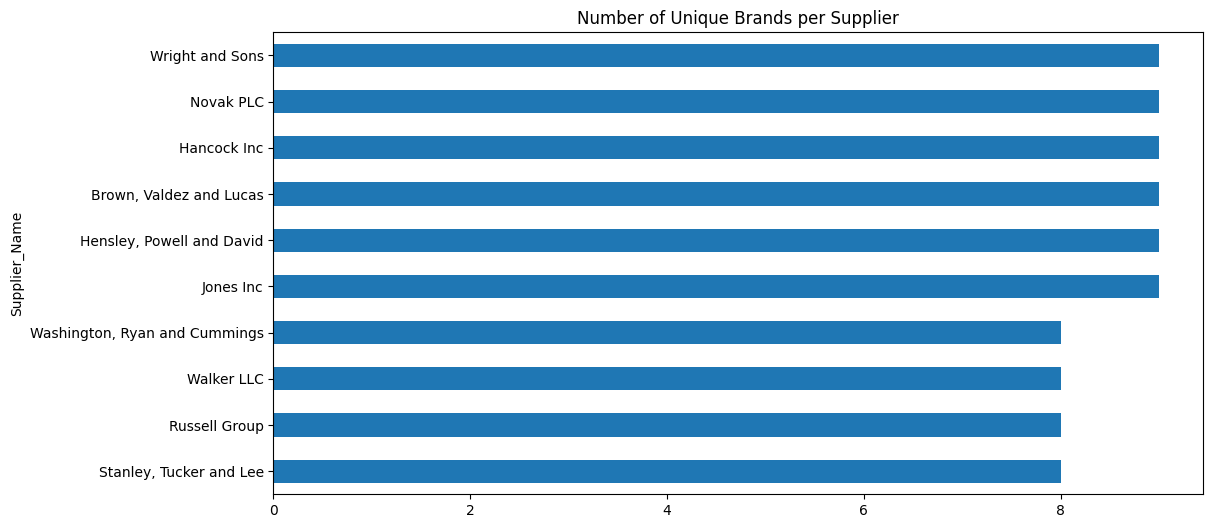

In [ ]:
# How many distinct brands exist for each Supplier?
brand_per_supplier = pharm.groupby("Supplier_Name")["Brand"].nunique().sort_values()
brand_per_supplier.tail(10).plot(kind='barh', figsize=(12,6), title='Number of Unique Brands per Supplier');

* Each of the supplier sold all 8 brands of drugs, only that some also sold a drug with an unknown brand

/tmp/ipython-input-3799343920.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(14,7))


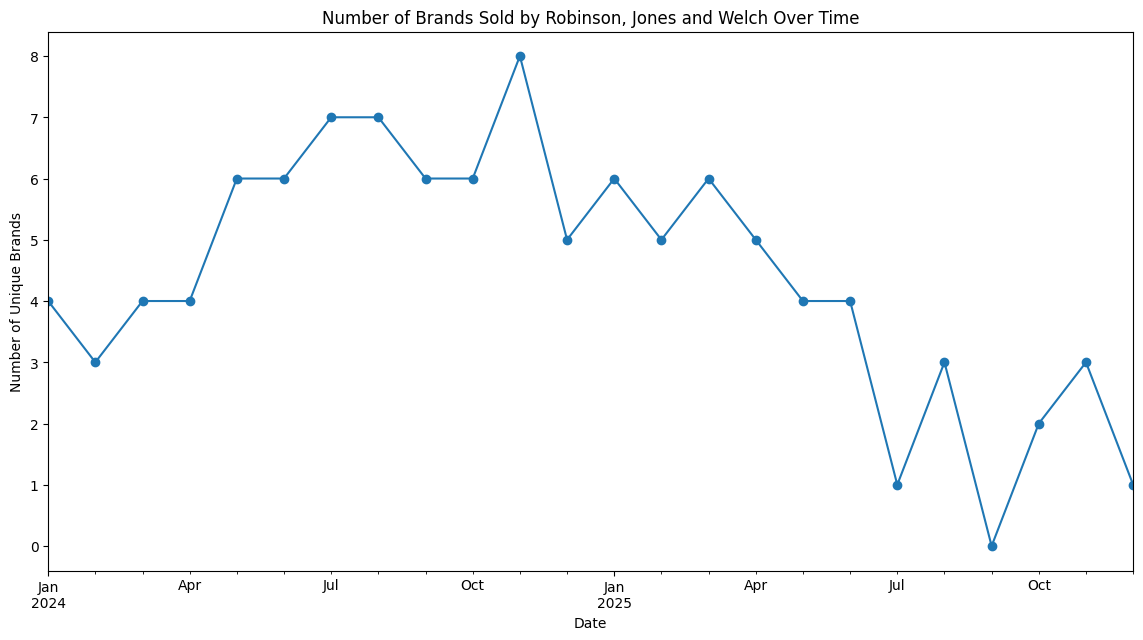

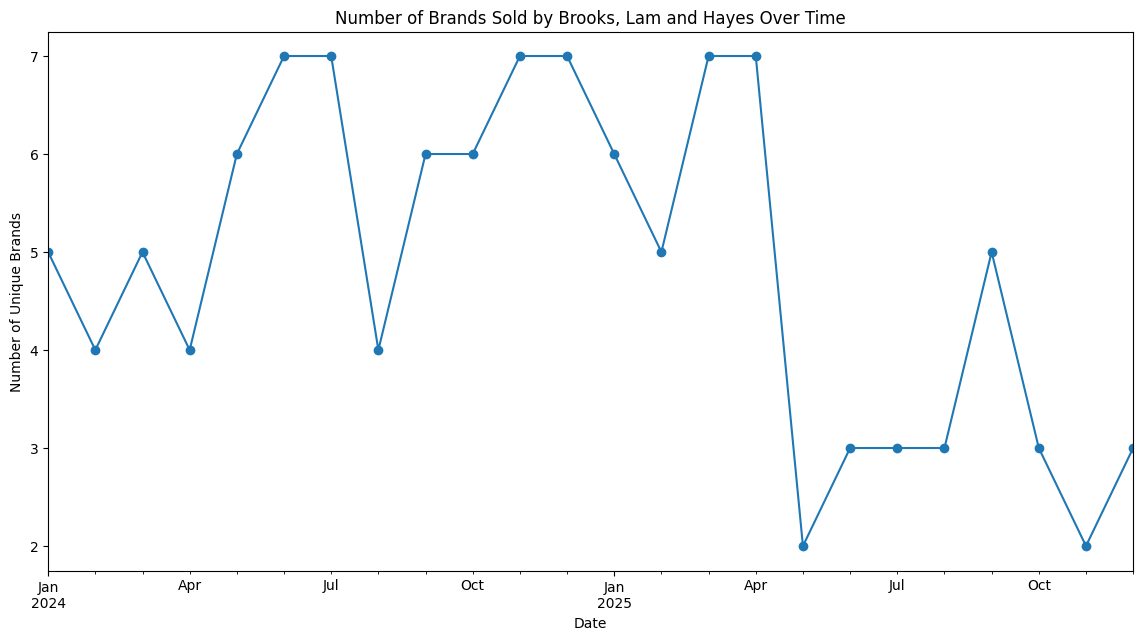

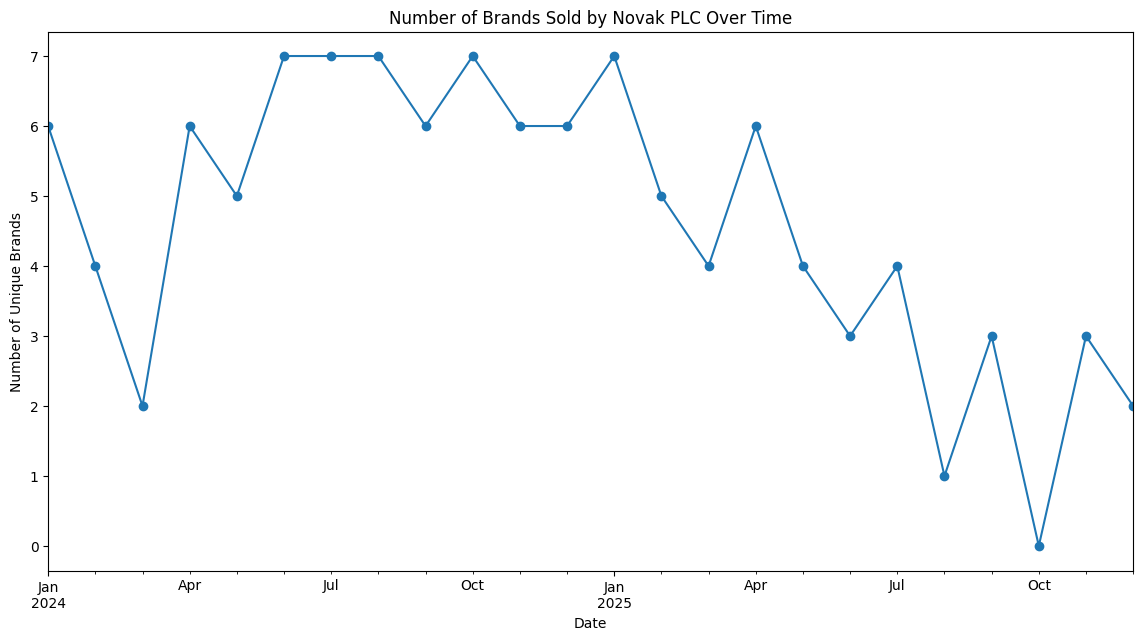

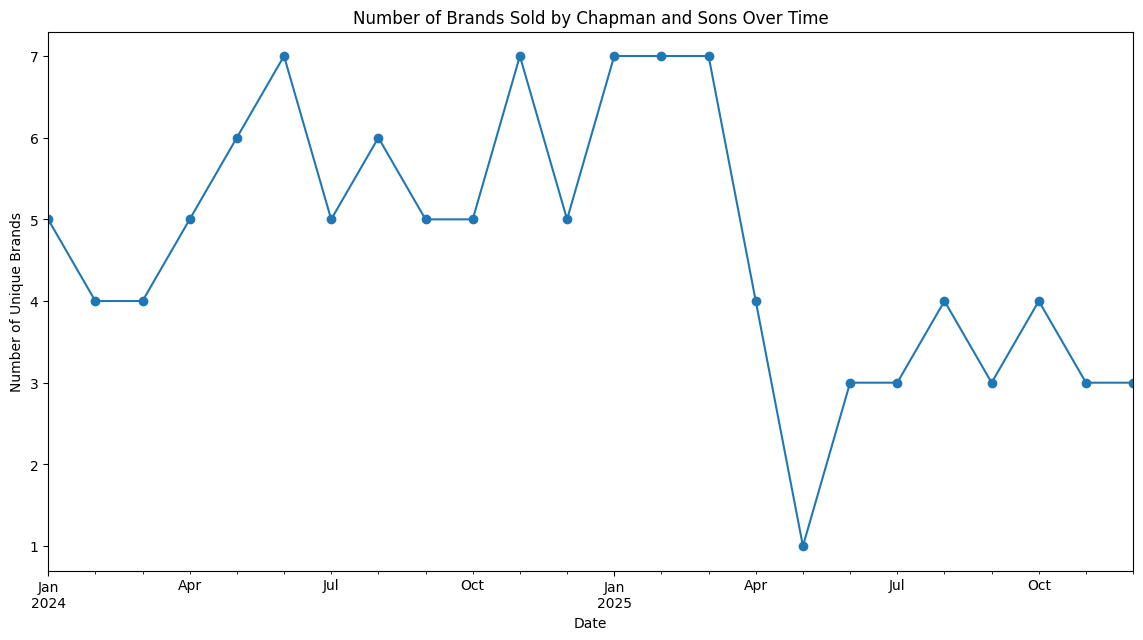

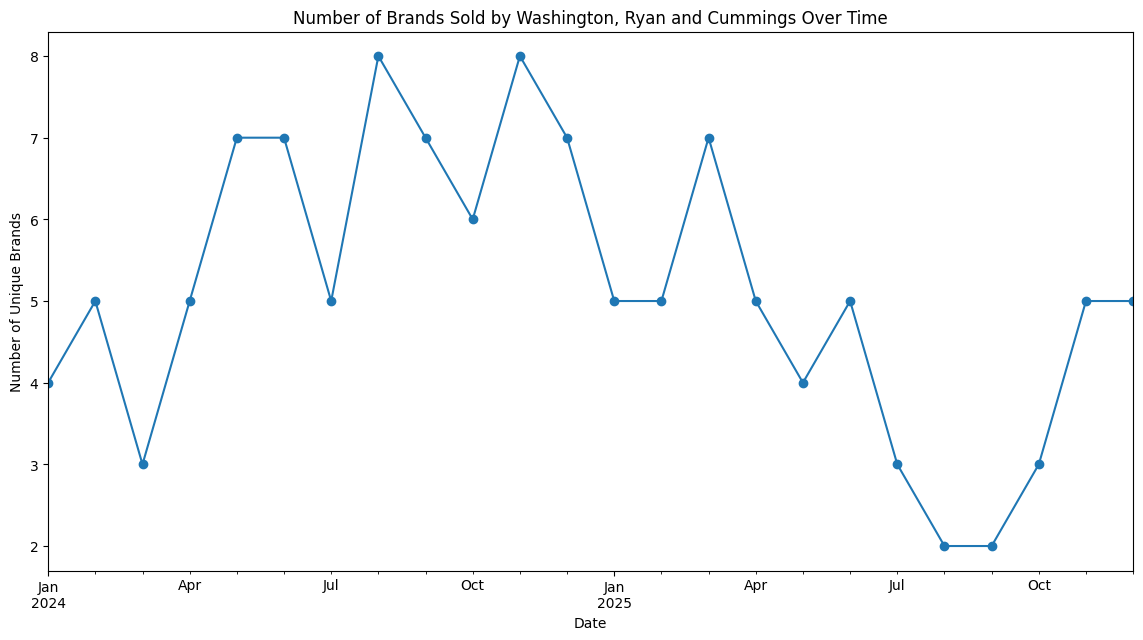

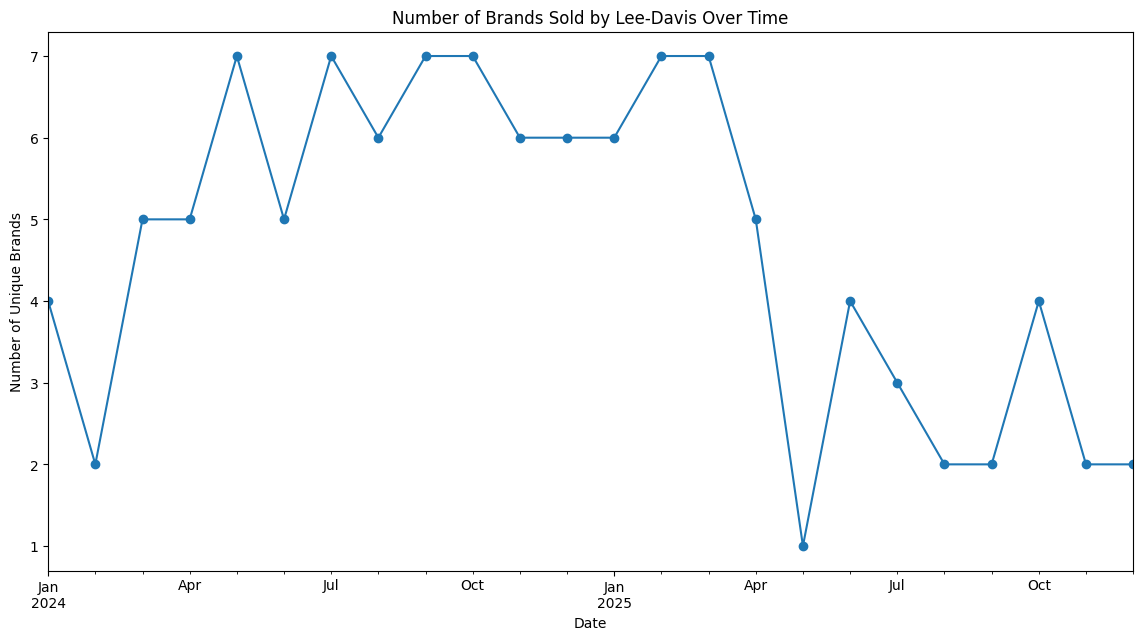

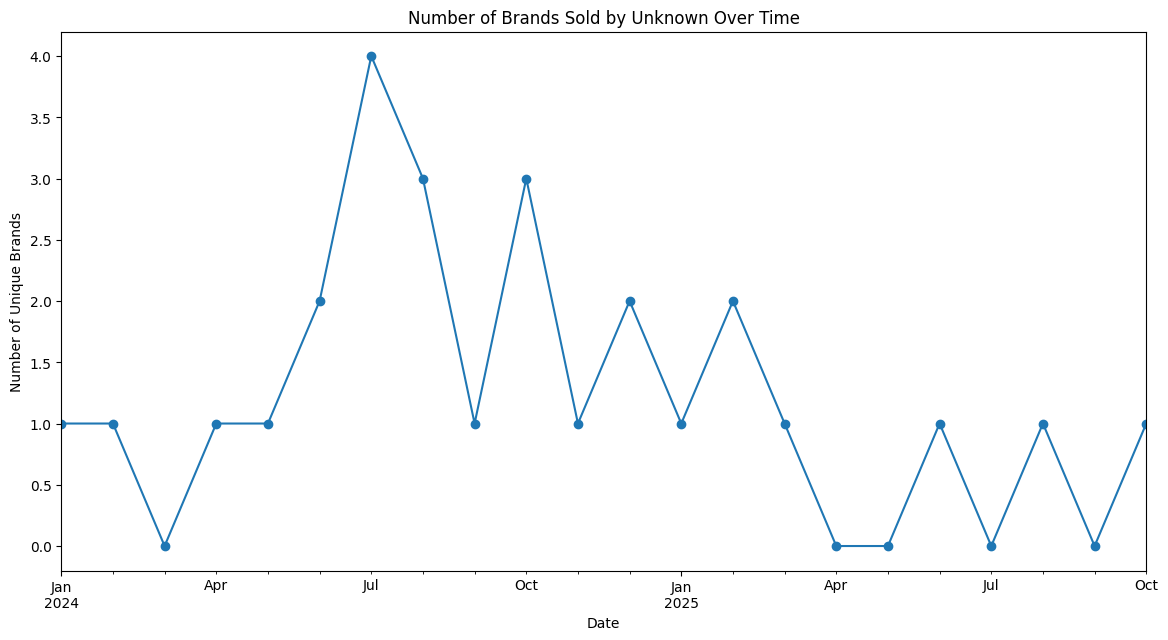

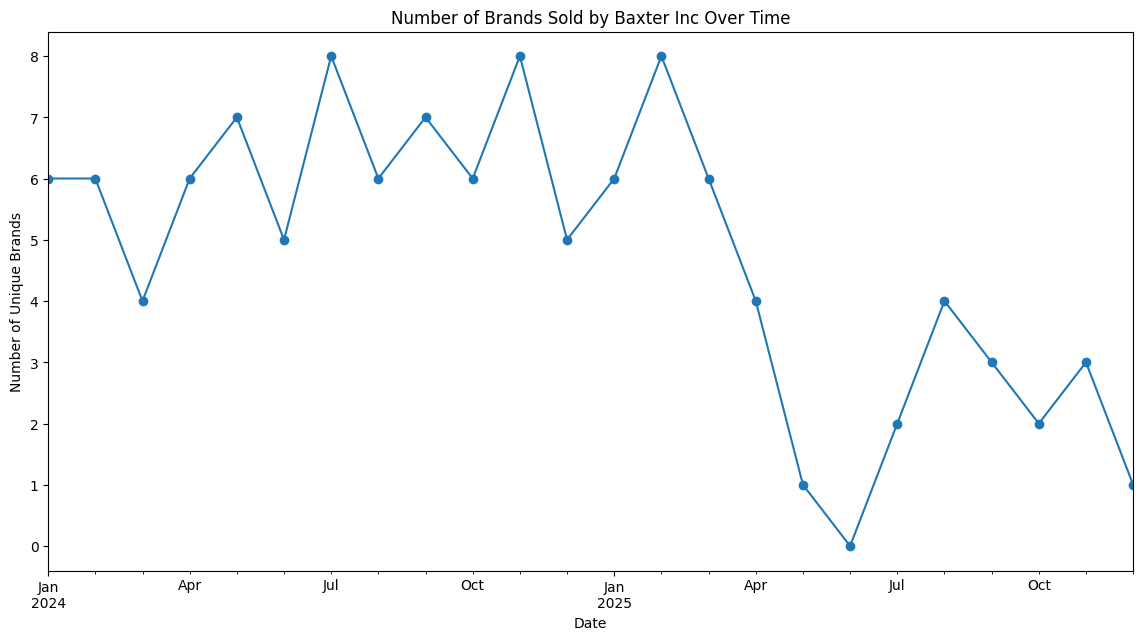

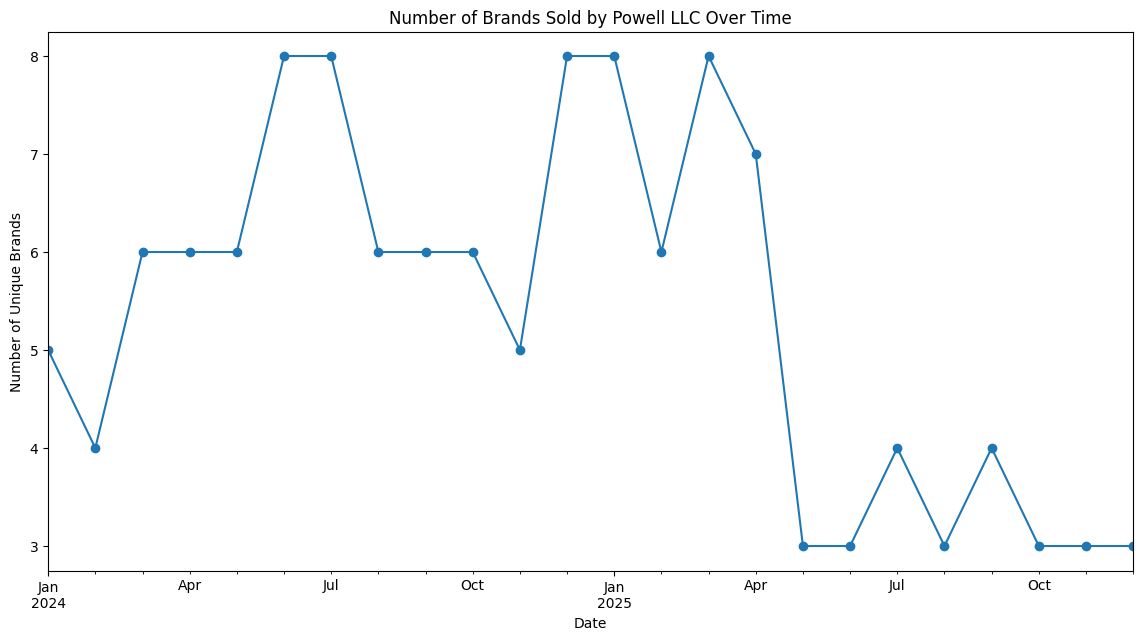

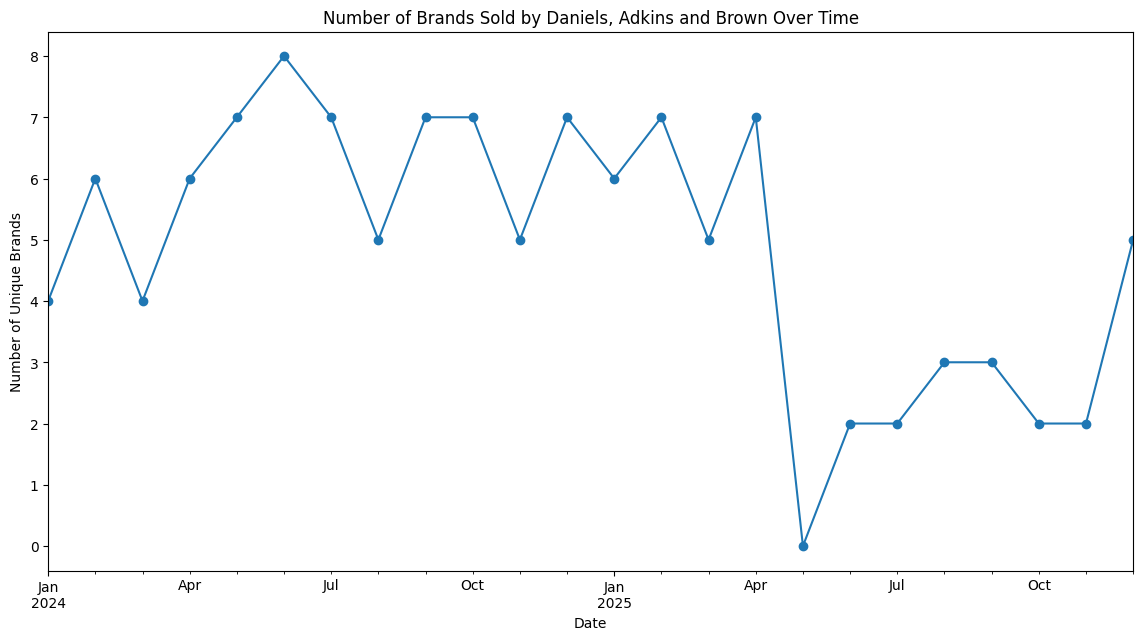

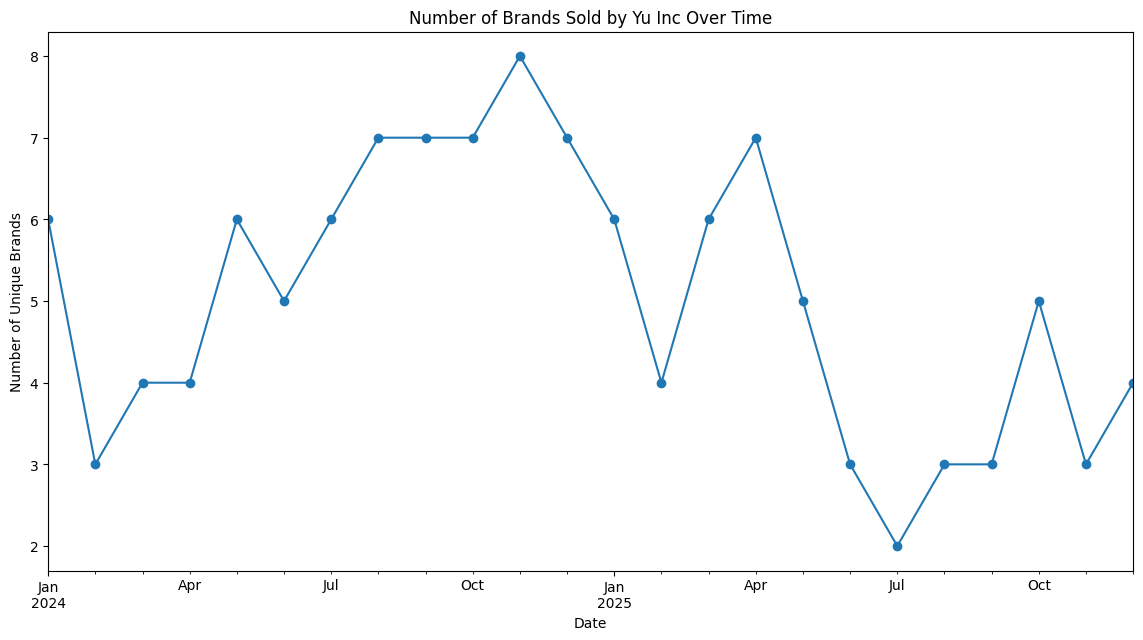

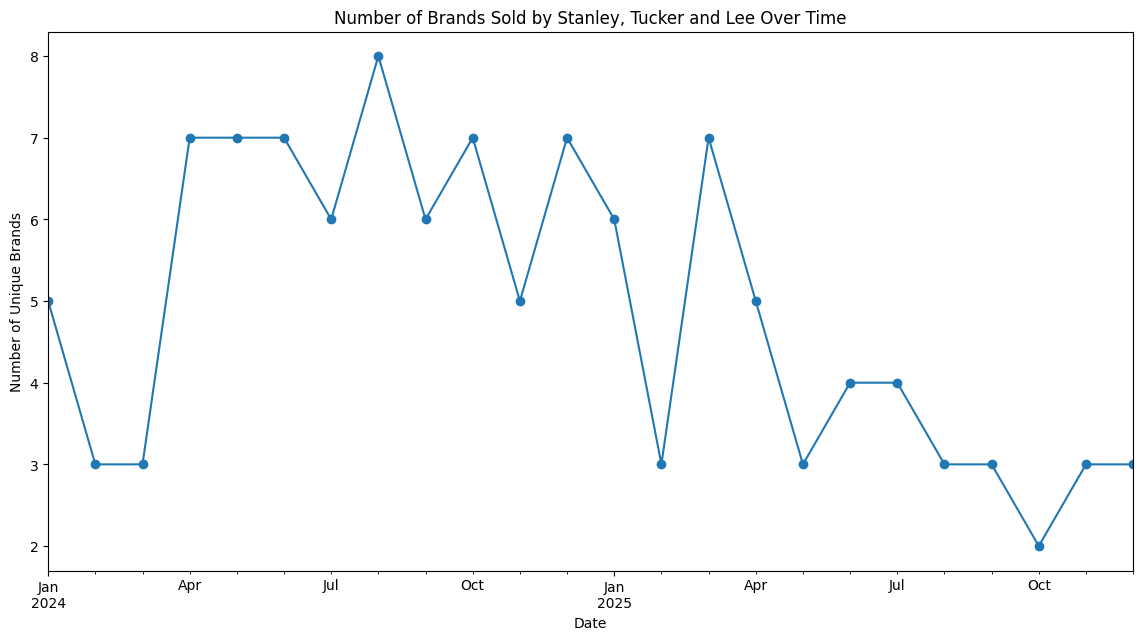

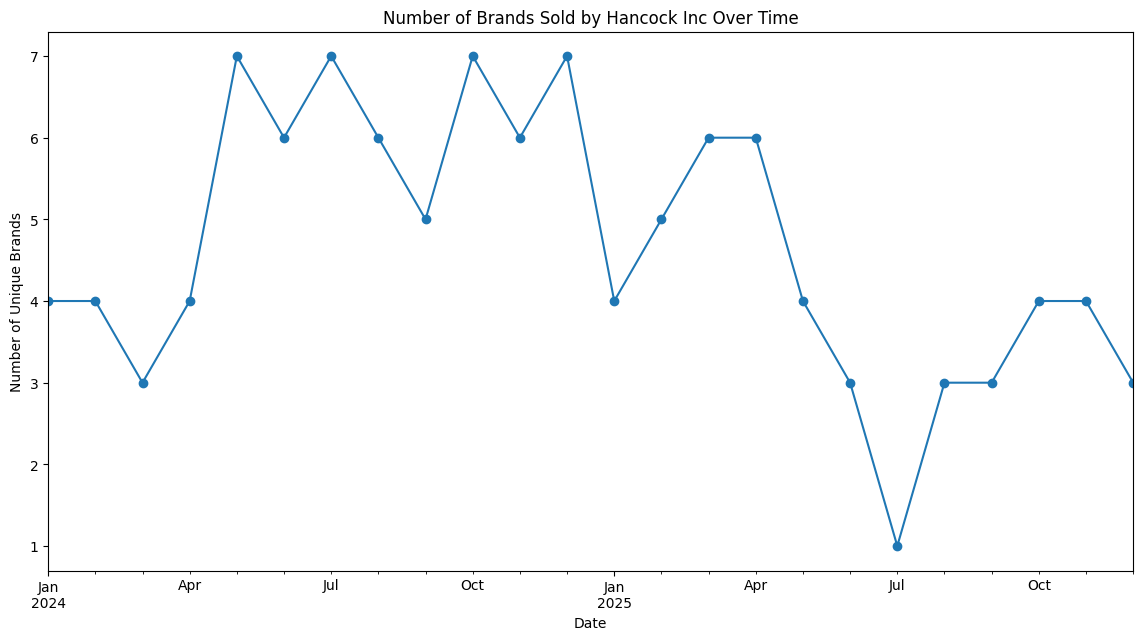

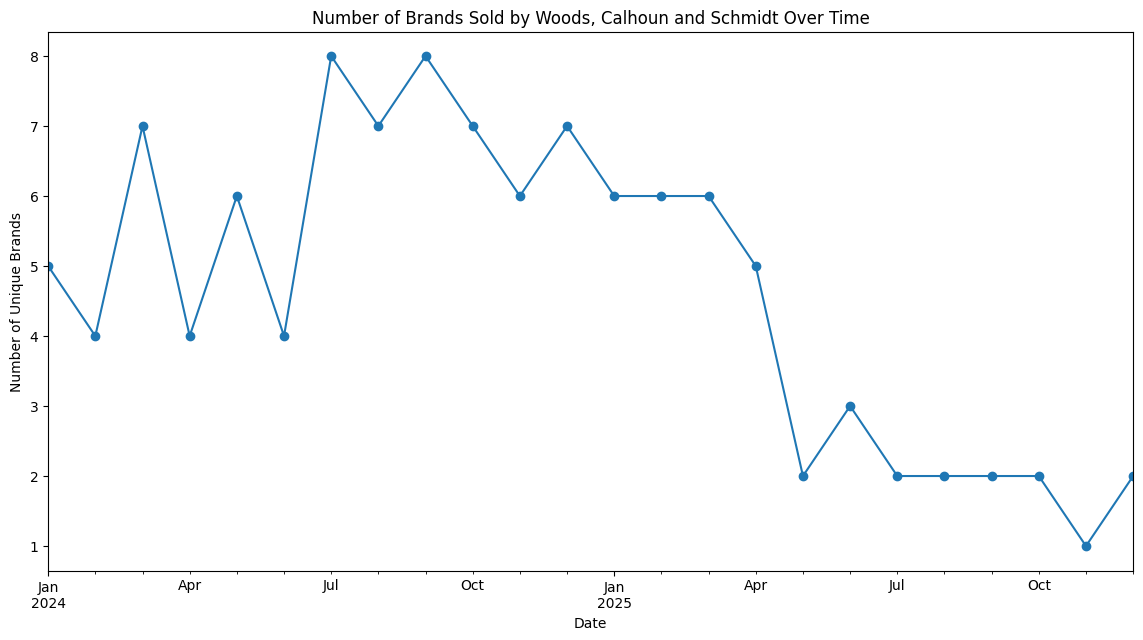

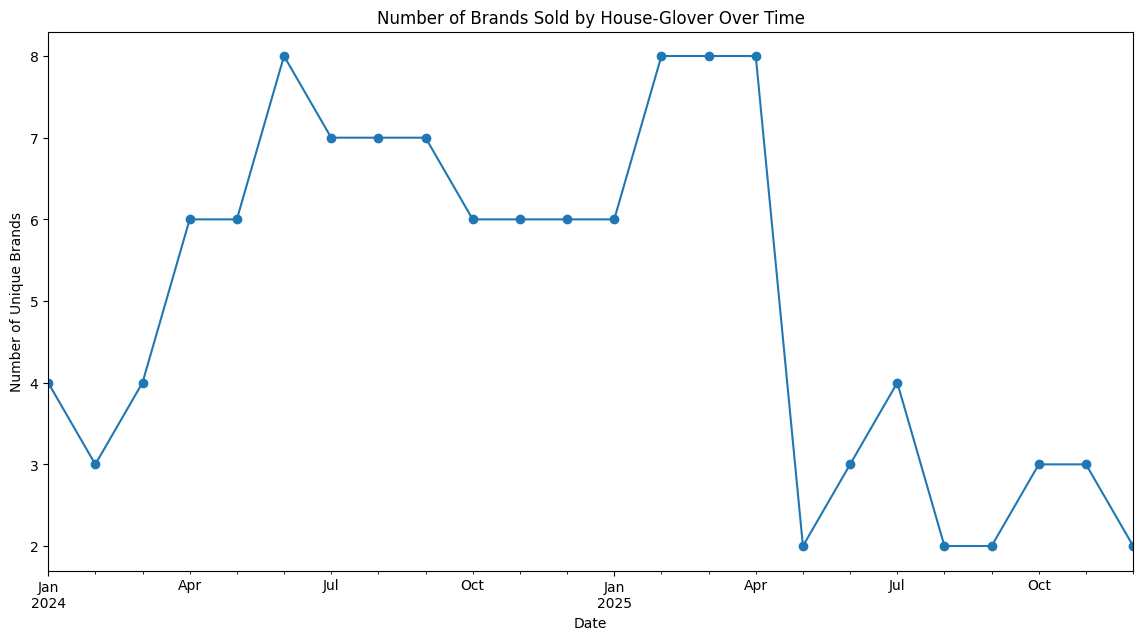

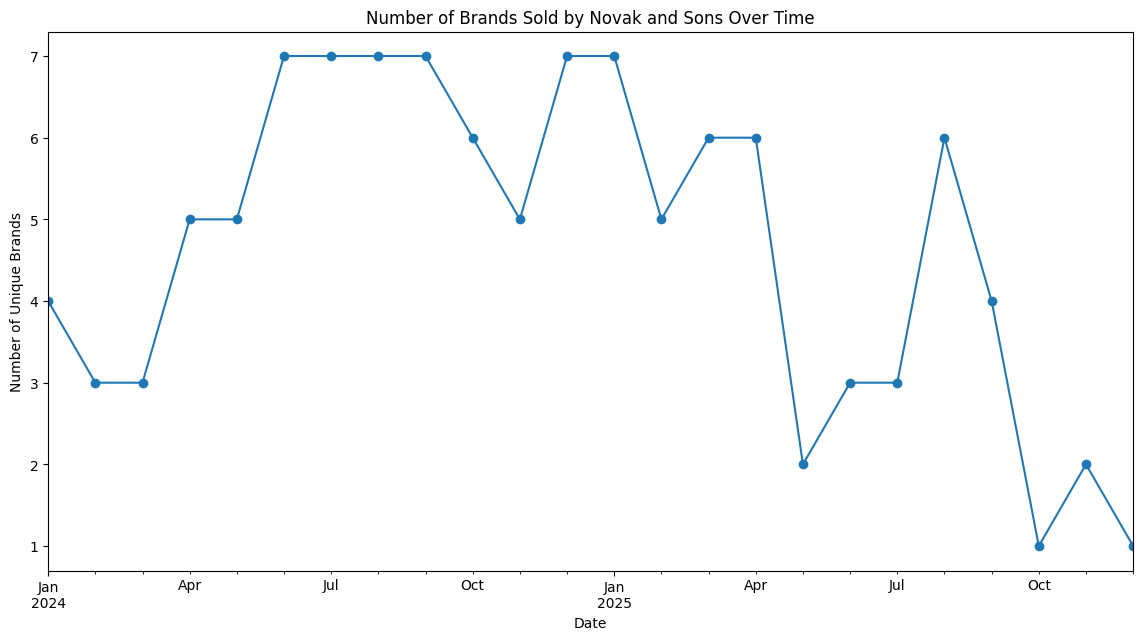

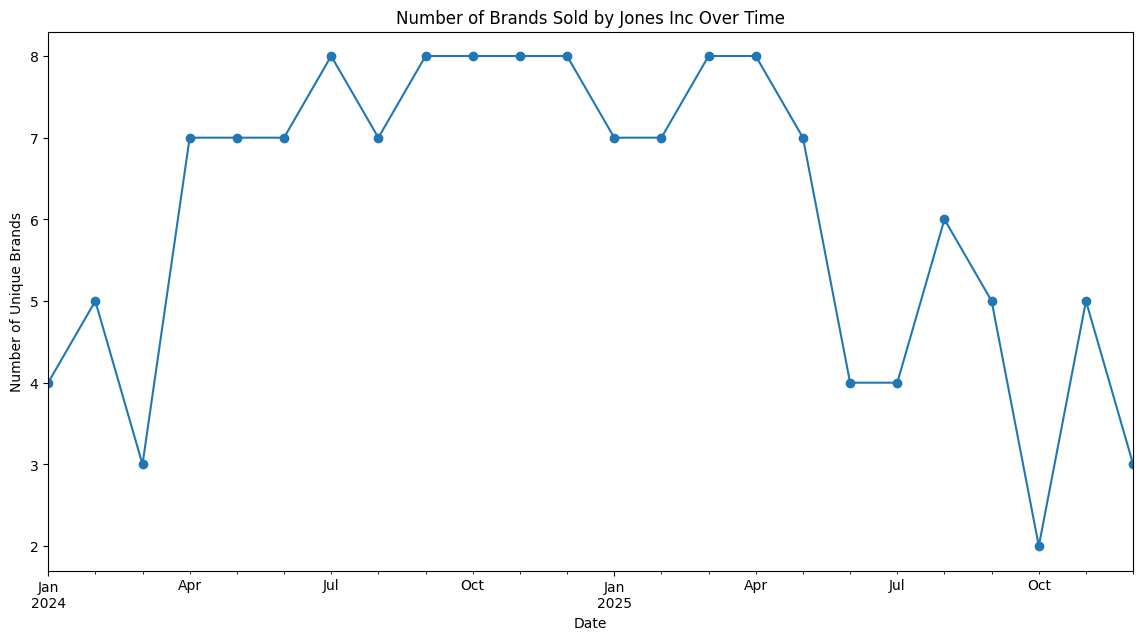

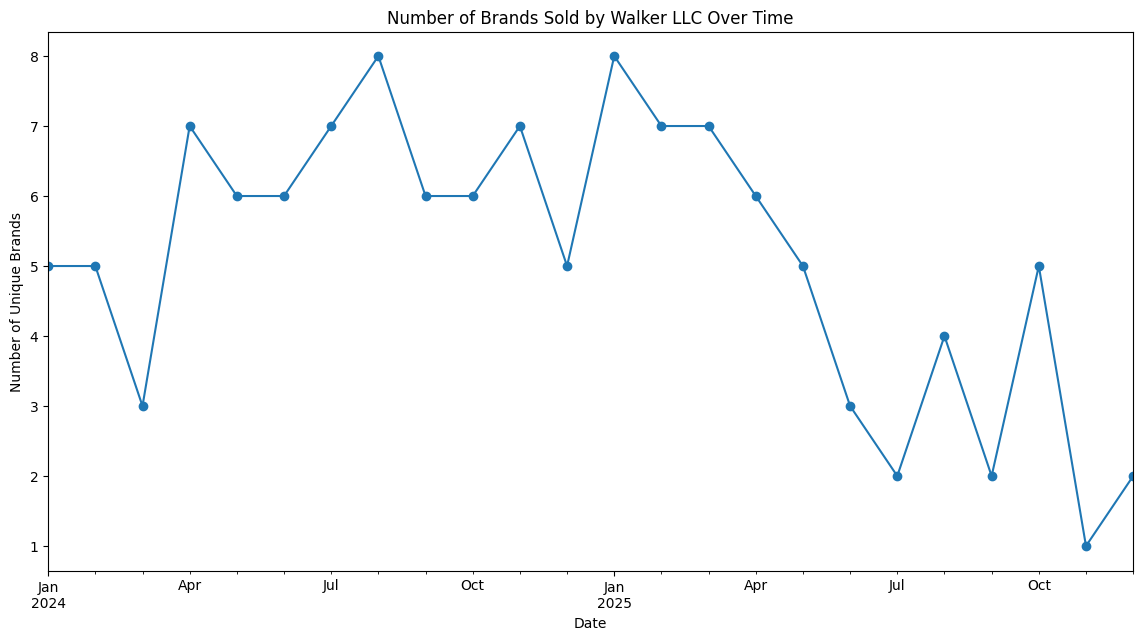

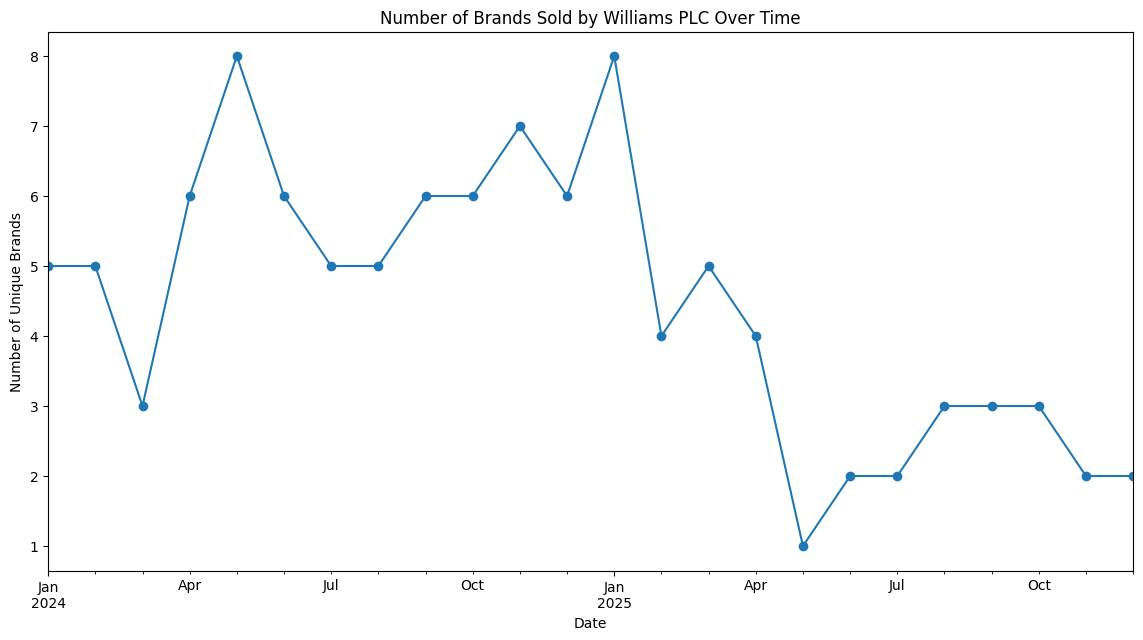

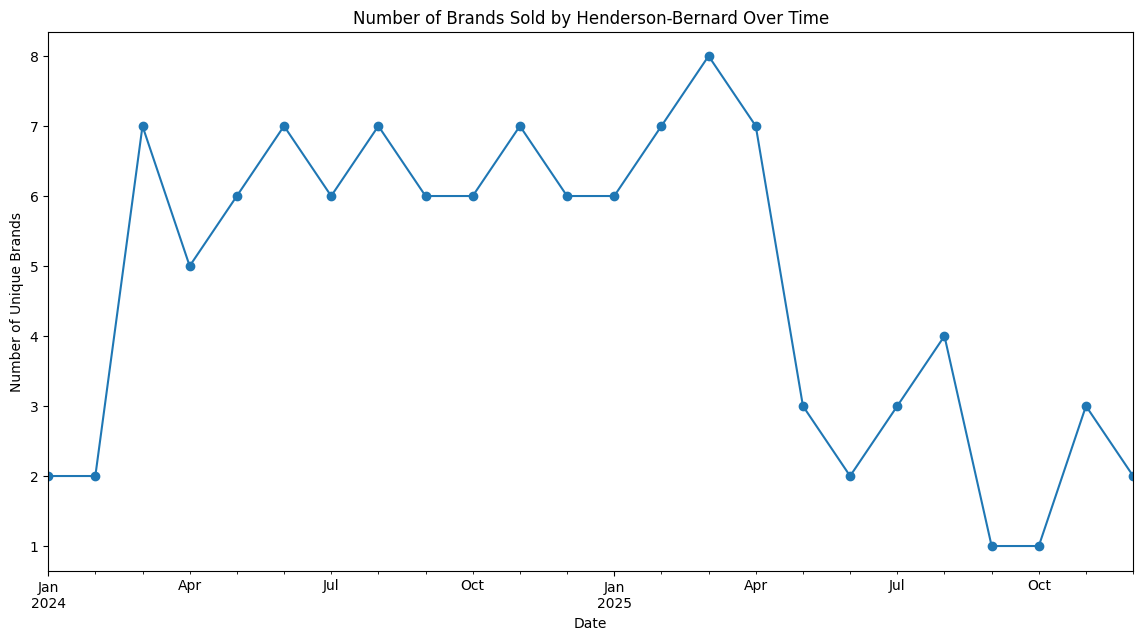

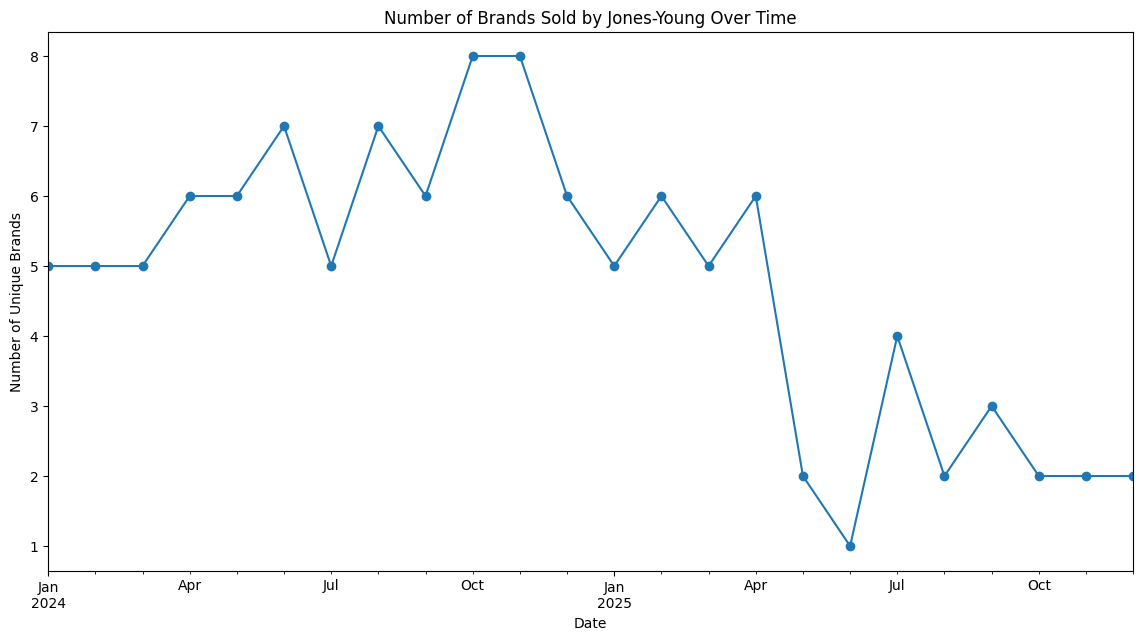

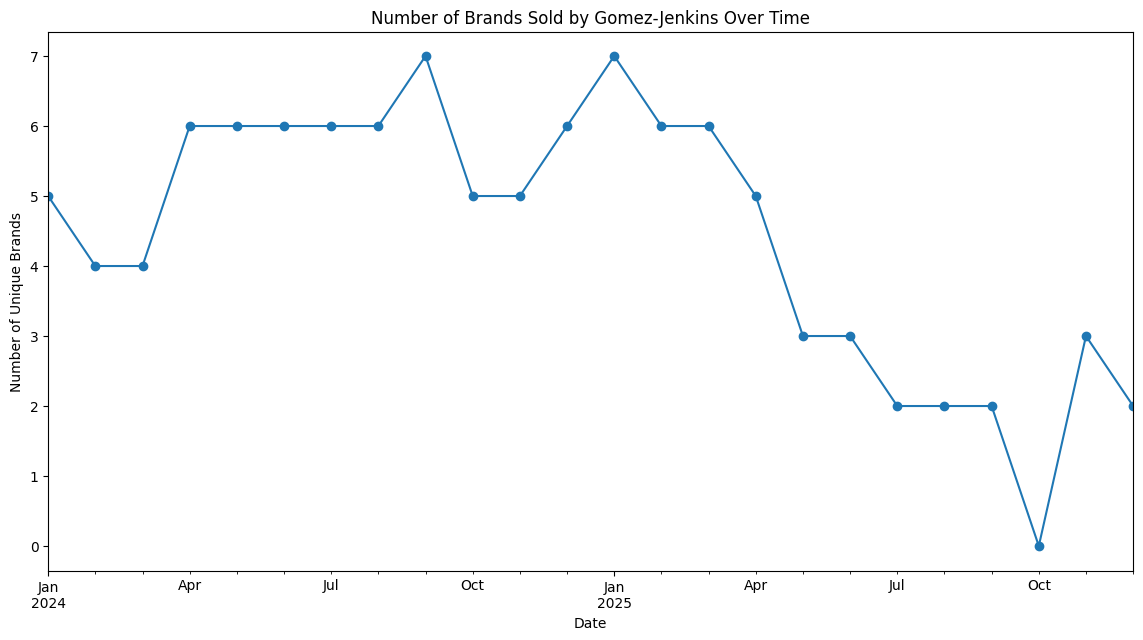

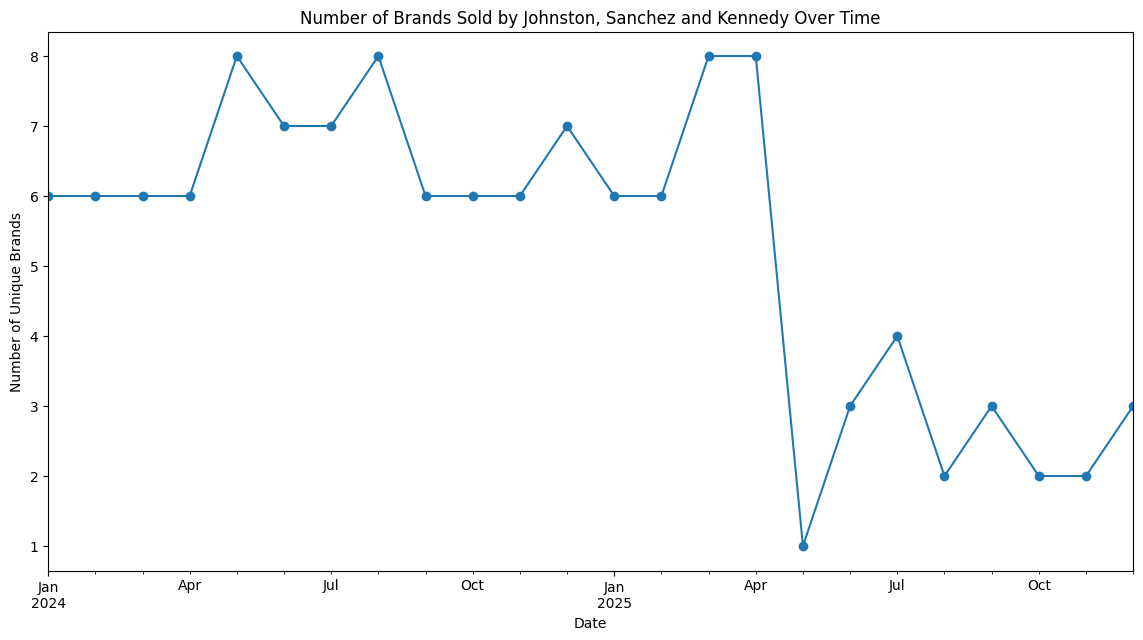

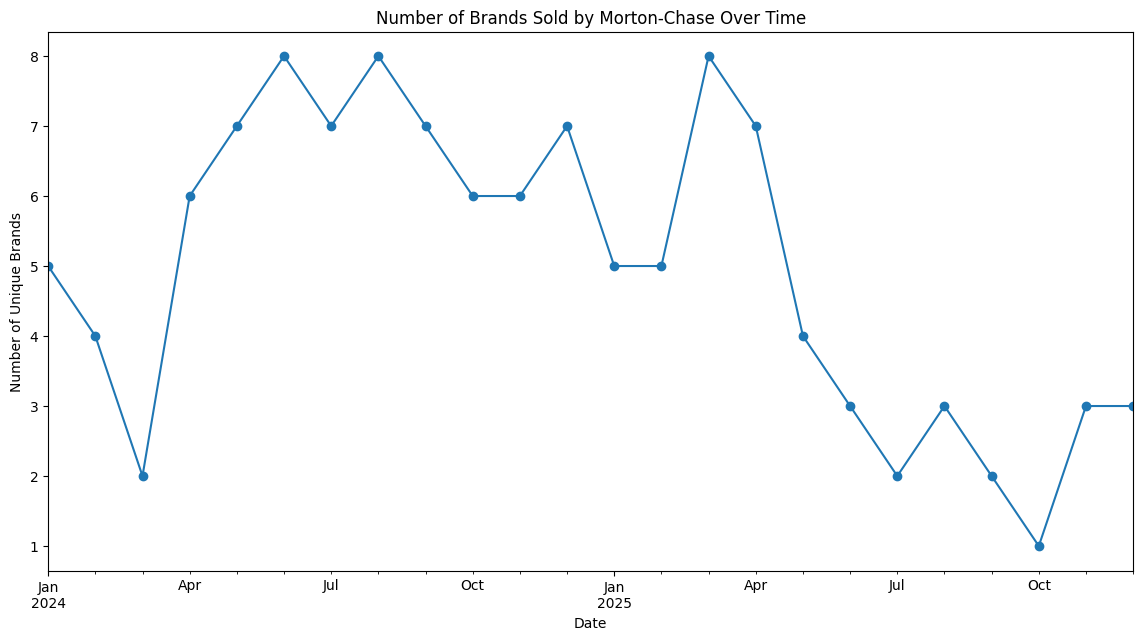

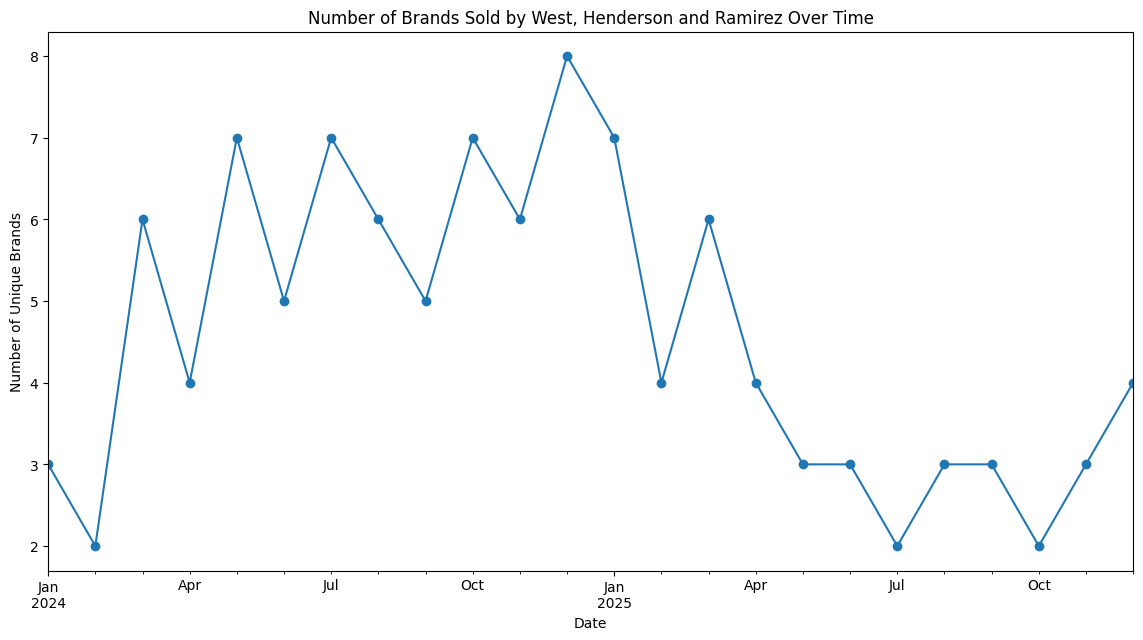

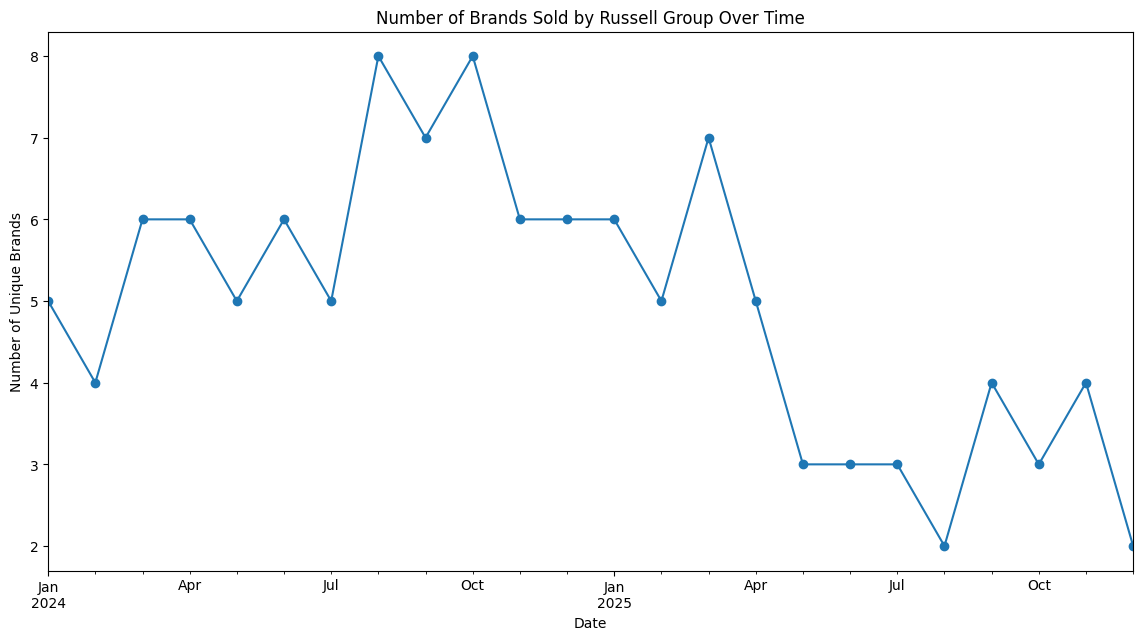

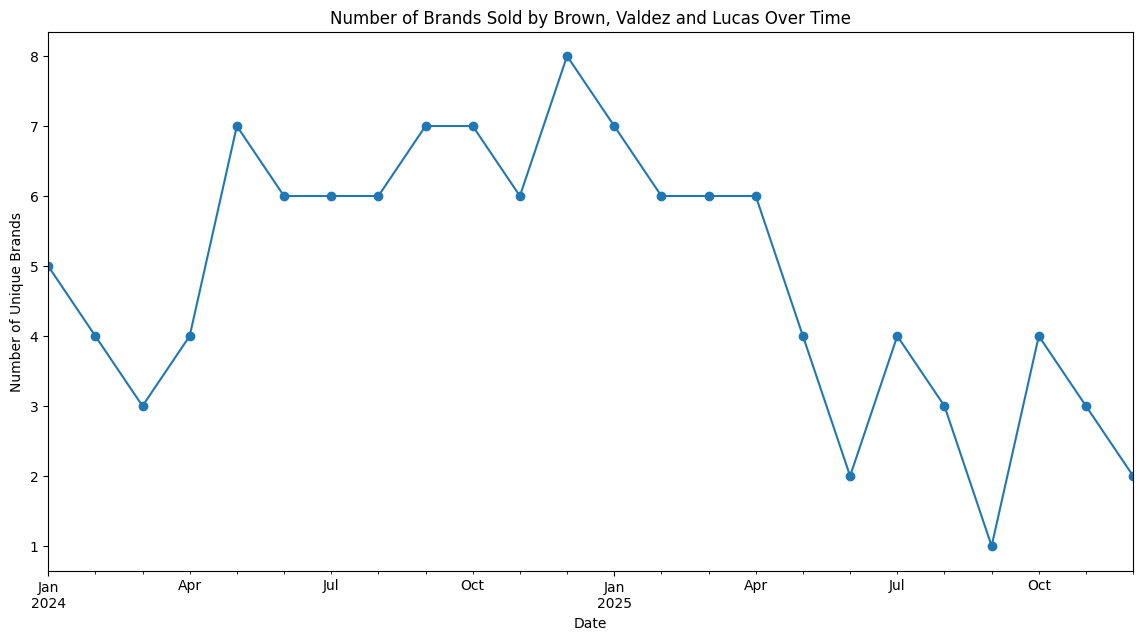

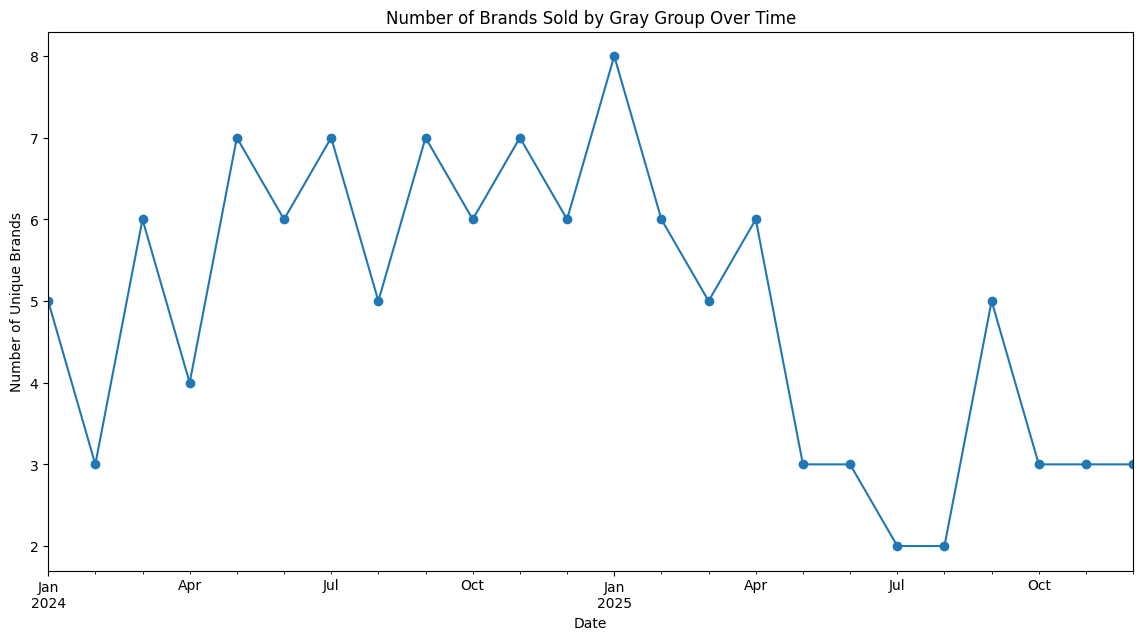

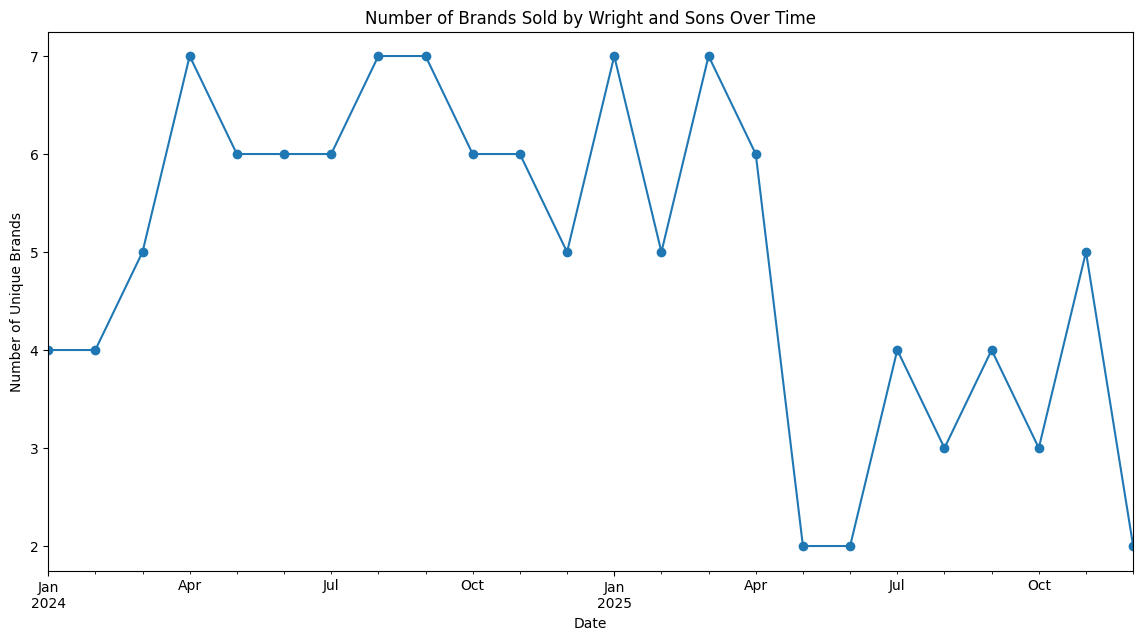

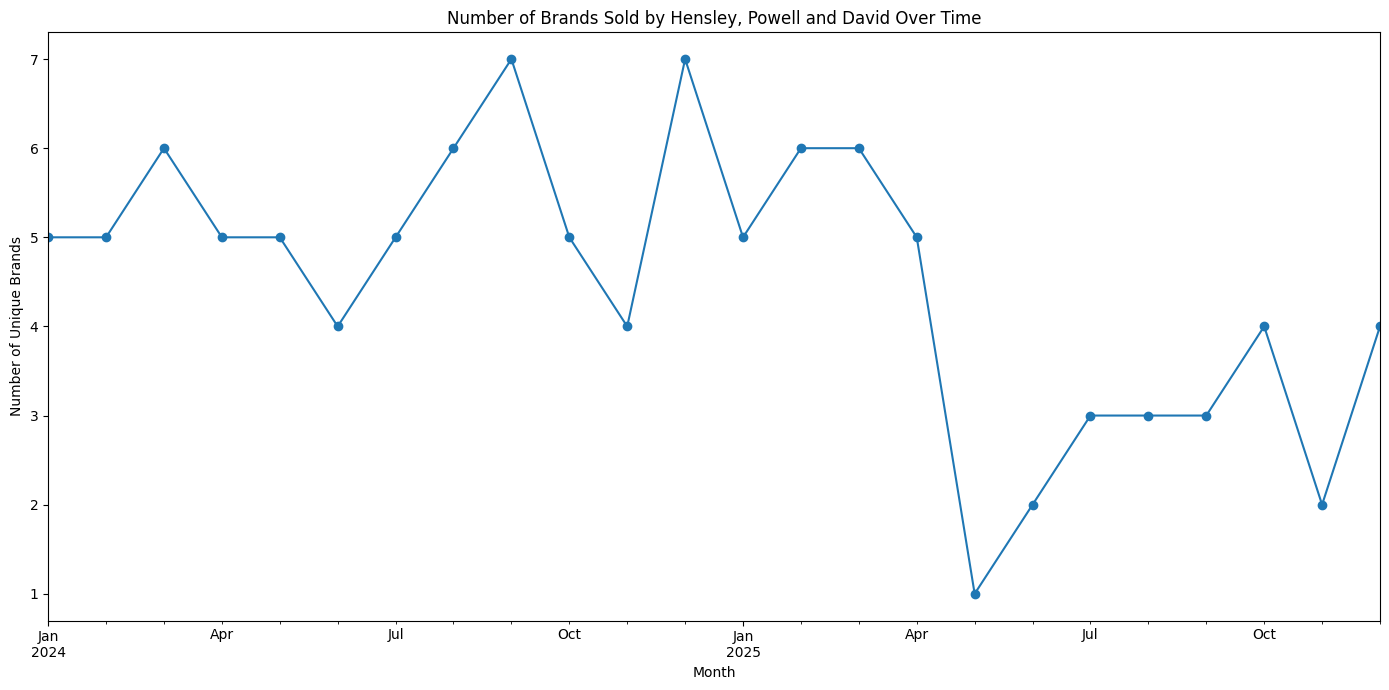

In [ ]:
# so now, I'll go ahead to check the distribution of each brand over time, by each supplier
for supplier in pharm['Supplier_Name'].unique():
    plt.figure(figsize=(14,7))
    brands_per_supplier_month = pharm[pharm['Supplier_Name'] == supplier].groupby([pd.Grouper(key="Date", freq="ME")])['Brand'].nunique()
    brands_per_supplier_month.plot(ax=plt.gca(), marker='o')
    plt.title(f'Number of Brands Sold by {supplier} Over Time')
    plt.ylabel('Number of Unique Brands')
plt.xlabel('Month')
plt.tight_layout()
plt.show();

* There is a lot of variation in the number of drugs supplied over the months
* It can be seen that most suppliers had a drop in the number of brands they supply, in May, 2025

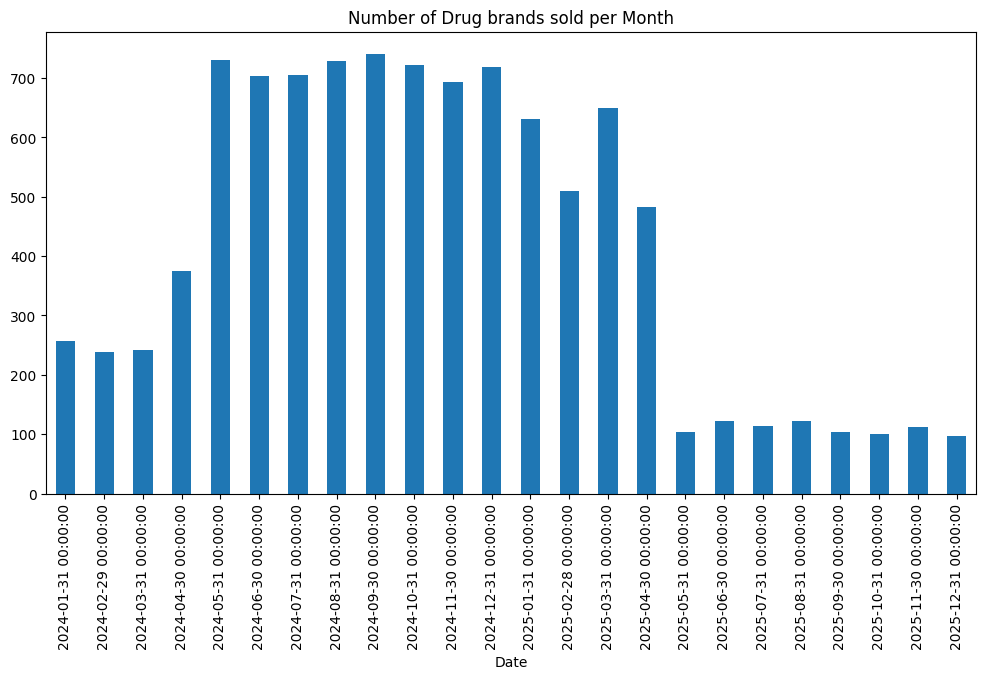

In [ ]:
# Quantity of brands sold per month
drugs_per_month = pharm.groupby([pd.Grouper(key="Date", freq="ME")])['Brand'].count()
drugs_per_month.plot(kind='bar', figsize=(12,6), title='Number of Drug brands sold per Month');

* To confirm, it could be seen that the quantity of drugs sold dropped in May, 2025, after a sudden increase in May, 2024

In [ ]:
# Is there any Pharmacy that didn't sell all brands?
pharm.groupby("Pharmacy")["Brand"].nunique().sort_values(ascending=False).head()

Pharmacy
Doyle Ltd                      9
Ferrell, Rice and Maddox       9
Blair PLC                      9
Davis and Sons                 9
Snyder, Campos and Callahan    9
Name: Brand, dtype: int64

No, there isn't a pharmacy that didn't sell less than the 8 brands, so we'll check the diversity per month

/tmp/ipython-input-101377403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brand_switch_top['Month'] = brand_switch_top['Date'].dt.to_period('M').astype(str)


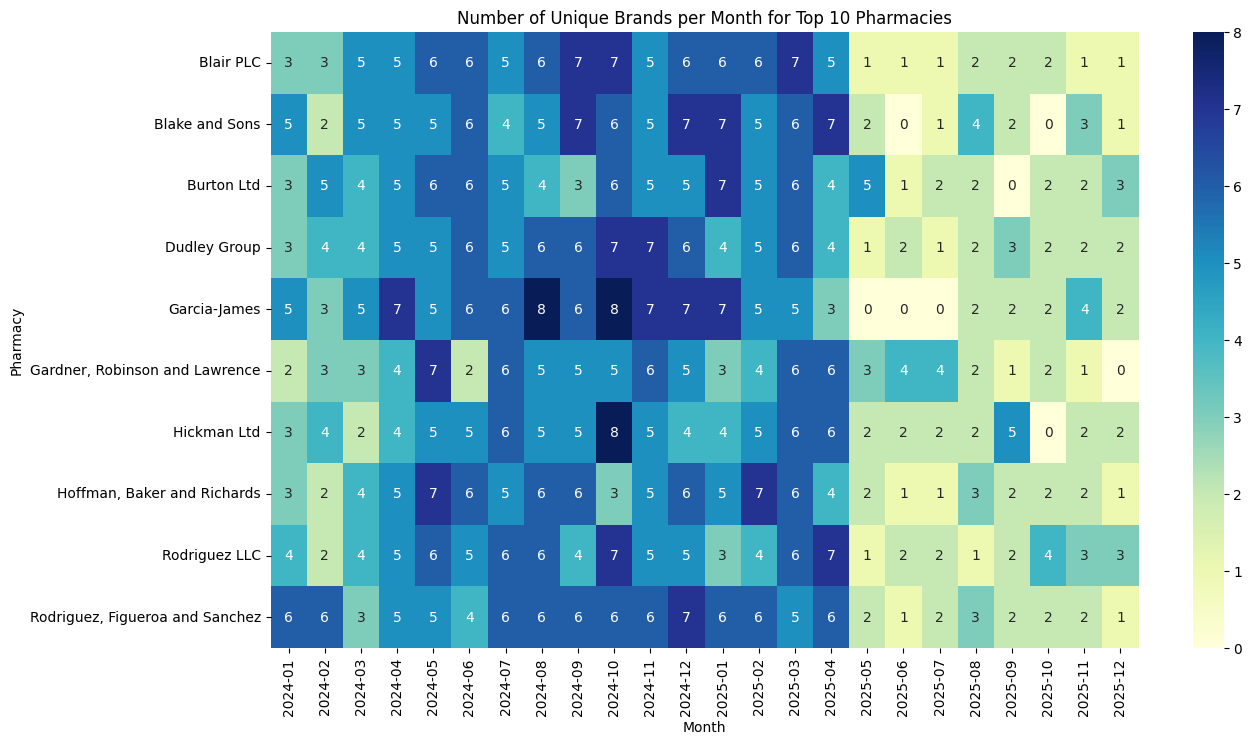

In [ ]:
top_pharmacies = pharm['Pharmacy'].value_counts().head(10).index
brand_switch_top = pharm[pharm['Pharmacy'].isin(top_pharmacies)]
# Group by Pharmacy and Month (YYYY-MM)
brand_switch_top['Month'] = brand_switch_top['Date'].dt.to_period('M').astype(str)
brand_switch_pivot = brand_switch_top.groupby(['Pharmacy', 'Month'])['Brand'].nunique().unstack(fill_value=0)
plt.figure(figsize=(14,8))
sns.heatmap(brand_switch_pivot, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Number of Unique Brands per Month for Top 10 Pharmacies')
plt.xlabel('Month')
plt.ylabel('Pharmacy')
plt.show();

In [ ]:
pharm.groupby([pd.Grouper(key="Date", freq="ME"), "Drug"])["Brand"].nunique()


Date        Drug         
2024-01-31  Amlodipine       6
            Amoxicillin      7
            Artemisinin      7
            Azithromycin     8
            Chloroquine      6
                            ..
2025-12-31  Ciprofloxacin    5
            Coartem          6
            Ibuprofen        5
            Metformin        6
            Paracetamol      4
Name: Brand, Length: 250, dtype: int64

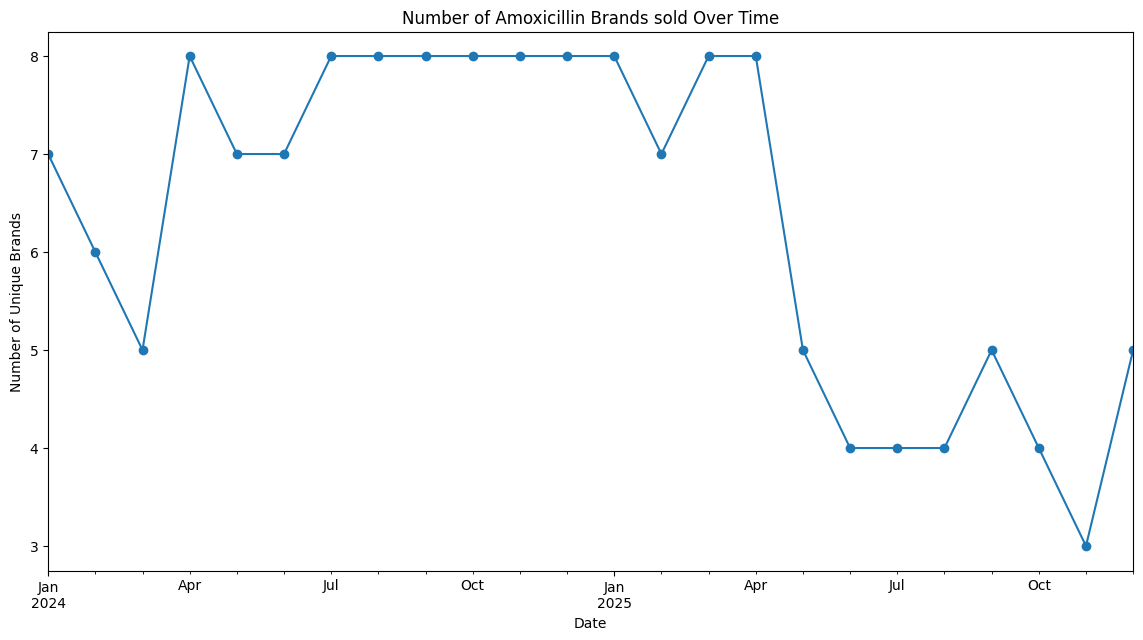

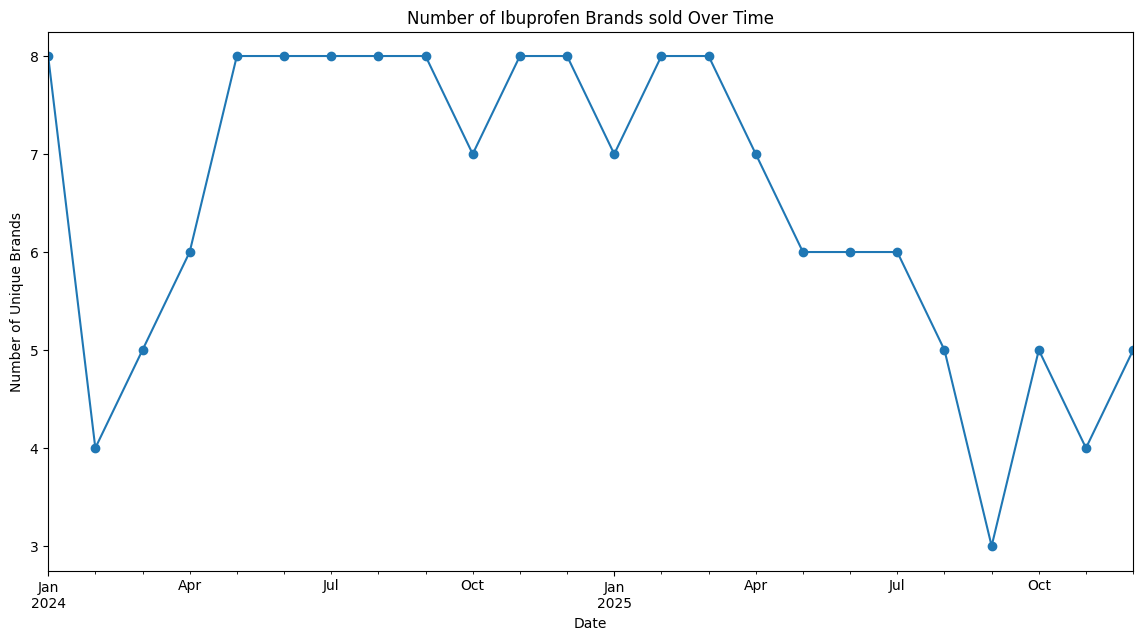

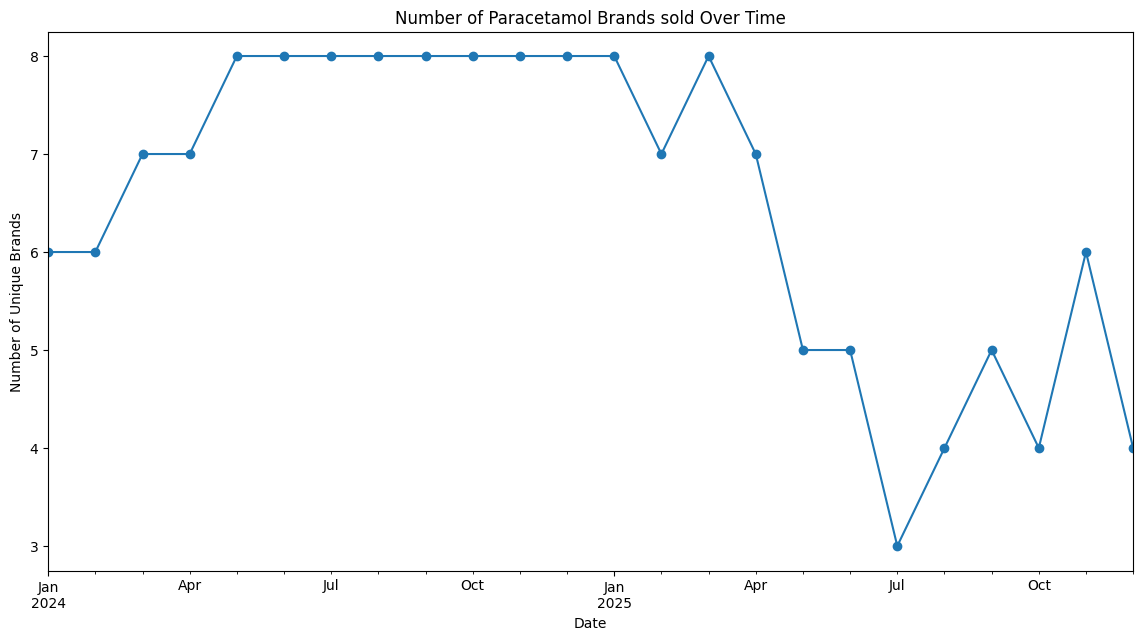

In [ ]:
# Brands of Drug that are in the Market per month
for drug in pharm['Drug'].unique():
    plt.figure(figsize=(14,7))
    brands_per_drug_month = pharm[pharm['Drug'] == drug].groupby([pd.Grouper(key="Date", freq="ME")])['Brand'].nunique()
    brands_per_drug_month.plot(ax=plt.gca(), marker='o')
    plt.title(f'Number of {drug} Brands sold Over Time')
    plt.ylabel('Number of Unique Brands')
plt.xlabel('Month')
plt.tight_layout()
plt.show();

In [ ]:
# Define a consistent color palette for brands
brand_list = pharm['Brand'].unique()
brand_palette = dict(zip(brand_list, sns.color_palette('tab20', n_colors=len(brand_list))))

# Mean price by location for each drug (per brand)
for drug in pharm['Drug'].unique():
    plt.figure(figsize=(12,6))
    subset = pharm[pharm['Drug'] == drug]
    if not subset.empty:
        sns.barplot(data=subset, x='Location', y='Price', hue='Brand', errorbar=None, palette=brand_palette)
        plt.ylabel('Mean Price')
        plt.title(f'Mean Price by Location and Brand for {drug}')
        plt.legend(loc='lower right', title='Brand', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.tight_layout()
        plt.show()
    else:
        print(f'No data for {drug}')

In [ ]:
# Define a consistent color palette for brands
brand_list = pharm['Brand'].unique()
brand_palette = dict(zip(brand_list, sns.color_palette('tab20', n_colors=len(brand_list))))

# Mean quantity by location for each drug (per brand)
for drug in pharm['Drug'].unique():
    plt.figure(figsize=(12,6))
    subset = pharm[pharm['Drug'] == drug]
    if not subset.empty:
        sns.barplot(data=subset, x='Location', y='Quantity', hue='Brand', errorbar=None, palette=brand_palette)
        plt.ylabel('Mean Quantity')
        plt.title(f'Mean Quantity by Location and Brand for {drug}')
        plt.legend(loc='lower right', title='Brand', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
        plt.tight_layout()
        plt.show()
    else:
        print(f'No data for {drug}')

## UNDERSTANDING FEATURES (FEATURE ENGINEERING)

### ANOMALY DETECTION IN PRICE, QUANTITY AND REVENUE


In [ ]:
from scipy import stats

In [ ]:
pharmacy_data= pharm_data[['Date', 'Pharmacy','Location', 'Drug','Brand', 'Quantity','Price', 'Revenue', 'Expiry_Date',	'Sales_Channel', 'Supplier_Name','Drug_Form']].copy()


In [ ]:
# Calculating mean of Quantity
mean_quantity= pharmacy_data['Quantity'].mean()

# Calculating standard deviation of Quantity
std_quantity= pharmacy_data['Quantity'].std()

# Compute Z-scores for Revenue and Quantity
pharmacy_data['Z_Score_Quantity'] = stats.zscore(pharmacy_data['Quantity'])



In [ ]:
# Calculating mean of Price
mean_revenue= pharmacy_data['Price'].mean()

# Calculating standard deviation of Revenue
std_revenue= pharmacy_data['Price'].std()

# Compute Z-scores for Revenue
pharmacy_data['Z_Score_Price'] = stats.zscore(pharmacy_data['Price'])


In [ ]:
# Calculating mean of Revenue
mean_revenue= pharmacy_data['Revenue'].mean()

# Calculating standard deviation of Revenue
std_revenue= pharmacy_data['Revenue'].std()

# Compute Z-scores for Revenue
pharmacy_data['Z_Score_Revenue'] = stats.zscore(pharmacy_data['Revenue'])


In [ ]:

# Mark any value where |Z| > 3 as an anomaly (common threshold, but you can adjust).
pharmacy_data['Revenue_Anomaly'] = (pharmacy_data['Z_Score_Revenue'].abs() > 3)
pharmacy_data['Price_Anomaly'] =  (pharmacy_data['Z_Score_Price'].abs() > 3)
pharmacy_data['Quantity_Anomaly'] =  (pharmacy_data['Z_Score_Quantity'].abs() > 3)
# Combine anomaly flags
pharmacy_data['Is_Anomaly'] = (
     pharmacy_data['Quantity_Anomaly'] | pharmacy_data['Price_Anomaly']
)


In [ ]:
pharmacy_data.head()

In [ ]:
pharmacy_data[pharmacy_data['Is_Anomaly'] == True]


In [ ]:
# Visualising Price Anomalies
plt.figure(figsize= (12,6))

# Normal points
plt.scatter(
    pharmacy_data[pharmacy_data['Price_Anomaly']== False]['Date'],
    pharmacy_data[pharmacy_data['Price_Anomaly']== False]['Price'],
    color= 'blue',
    label= 'Normal'

)

# Anomaly points
plt.scatter (
    pharmacy_data[pharmacy_data['Price_Anomaly']== True]['Date'],
    pharmacy_data[pharmacy_data['Price_Anomaly']== True]['Price'],
    color= 'red',
    label= 'Anomaly'
)

plt.title('Price Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Visualising Quantity Anomalies
plt.figure(figsize= (12,6))

# Normal points
plt.scatter(
    pharmacy_data[pharmacy_data['Quantity_Anomaly']== False]['Date'],
    pharmacy_data[pharmacy_data['Quantity_Anomaly']== False]['Quantity'],
    color= 'blue',
    label= 'Normal'

)

# Anomaly points
plt.scatter (
    pharmacy_data[pharmacy_data['Quantity_Anomaly']== True]['Date'],
    pharmacy_data[pharmacy_data['Quantity_Anomaly']== True]['Quantity'],
    color= 'red',
    label= 'Anomaly'
)

plt.title('Quantity Anomalies')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [ ]:
# Visualising Revenue Anomalies
plt.figure(figsize= (12,6))

# Normal points
plt.scatter(
    pharmacy_data[pharmacy_data['Revenue_Anomaly']== False]['Date'],
    pharmacy_data[pharmacy_data['Revenue_Anomaly']== False]['Revenue'],
    color= 'blue',
    label= 'Normal'

)

# Anomaly points
plt.scatter (
    pharmacy_data[pharmacy_data['Revenue_Anomaly']== True]['Date'],
    pharmacy_data[pharmacy_data['Revenue_Anomaly']== True]['Revenue'],
    color= 'red',
    label= 'Anomaly'
)

plt.title('Revenue Anomalies')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

## ROBUST Z SCORE (median + MAD) METHOD

## INTERQUARTILE (IQR) METHOD

In [ ]:
#  Per-Drug IQR outliers
def iqr_flag(s):
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (s < lower) | (s > upper)

pharmacy_data['Price_Anomaly_Drug_IQR'] = pharmacy_data.groupby('Drug')['Price'].transform(lambda s: iqr_flag(s))


plt.figure(figsize=(12,6))
sns.boxplot(x="Drug", y="Price", data=pharmacy_data)
sns.scatterplot(
    x="Drug", y="Price",
    data=pharmacy_data[pharmacy_data["Price_Anomaly_Drug_IQR"]],
    color="red", label="IQR Anomalies", s=100
)
plt.title("Per-Drug Price Distribution with IQR Anomalies")
plt.xticks(rotation=45)
plt.legend()
plt.show()



In [ ]:
# Helper function for MAD-based robust Z-scores
def robust_zscore(series):
    median = np.median(series)
    mad = np.median(np.abs(series - median))
    mad = mad if mad != 0 else 1  # avoid division by zero
    return (series - median) / mad


#  Price Anomaly
# Own-history baseline (per Pharmacy–Drug)
pharmacy_data['Median_Price'] = pharmacy_data.groupby(['Pharmacy','Drug'])['Price'].transform('median')
pharmacy_data['Robust_Z_Price'] = pharmacy_data.groupby(['Pharmacy','Drug'])['Price'].transform(robust_zscore)
pharmacy_data['Price_Anomaly_History'] = (pharmacy_data['Robust_Z_Price'].abs() > 3)

# Market baseline (same Drug on same Date)
pharmacy_data['Market_Median_Price'] = pharmacy_data.groupby(['Drug','Date'])['Price'].transform('median')
pharmacy_data['Market_Anomaly_Price'] = pharmacy_data['Price'] < (0.7 * pharmacy_data['Market_Median_Price'])

# Combine
pharmacy_data['Price_Anomaly'] = pharmacy_data['Price_Anomaly_History'] | pharmacy_data['Market_Anomaly_Price']


#  Quantity Anomaly
pharmacy_data['Median_Qty'] = pharmacy_data.groupby(['Pharmacy','Drug'])['Quantity'].transform('median')
pharmacy_data['Robust_Z_Qty'] = pharmacy_data.groupby(['Pharmacy','Drug'])['Quantity'].transform(robust_zscore)
pharmacy_data['Quantity_Anomaly'] = (pharmacy_data['Robust_Z_Qty'].abs() > 3)


# Revenue Anomaly
pharmacy_data['Median_Revenue'] = pharmacy_data.groupby(['Pharmacy','Drug'])['Revenue'].transform('median')
pharmacy_data['Robust_Z_Revenue'] = pharmacy_data.groupby(['Pharmacy','Drug'])['Revenue'].transform(robust_zscore)
pharmacy_data['Revenue_Anomaly'] = (pharmacy_data['Robust_Z_Revenue'].abs() > 3)


# Apply Context Filters
if 'Quantity' in pharmacy_data.columns:
    pharmacy_data['Price_Anomaly'] = pharmacy_data['Price_Anomaly'] & (pharmacy_data['Quantity'] > 1)

if 'Expiry_Days_Left' in pharmacy_data.columns:
    pharmacy_data['Price_Anomaly'] = pharmacy_data['Price_Anomaly'] & (pharmacy_data['Expiry_Date'] > 30)

if 'Sales_Channel' in pharmacy_data.columns:
    pharmacy_data['Price_Anomaly'] = pharmacy_data['Price_Anomaly'] & (pharmacy_data['Sales_Channel'] != 'Market Stall')


# Combine All Anomaly Flags
pharmacy_data['Is_Anomaly'] = (
    pharmacy_data['Price_Anomaly'] |
    pharmacy_data['Quantity_Anomaly'] |
    pharmacy_data['Revenue_Anomaly']
)




# Price Anomalies
plt.figure(figsize=(12,5))
plt.scatter(
    pharmacy_data[pharmacy_data['Price_Anomaly']==False]['Date'],
    pharmacy_data[pharmacy_data['Price_Anomaly']==False]['Price'],
    color='blue', label='Normal'
)
plt.scatter(
    pharmacy_data[pharmacy_data['Price_Anomaly']==True]['Date'],
    pharmacy_data[pharmacy_data['Price_Anomaly']==True]['Price'],
    color='red', label='Anomaly'
)
plt.title('Price Anomalies (Robust Detection)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Quantity Anomalies
plt.figure(figsize=(12,5))
plt.scatter(
    pharmacy_data[pharmacy_data['Quantity_Anomaly']==False]['Date'],
    pharmacy_data[pharmacy_data['Quantity_Anomaly']==False]['Quantity'],
    color='blue', label='Normal'
)
plt.scatter(
    pharmacy_data[pharmacy_data['Quantity_Anomaly']==True]['Date'],
    pharmacy_data[pharmacy_data['Quantity_Anomaly']==True]['Quantity'],
    color='red', label='Anomaly'
)
plt.title('Quantity Anomalies (Robust Detection)')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.legend()
plt.show()


# Revenue Anomalies
plt.figure(figsize=(12,5))
plt.scatter(
    pharmacy_data[pharmacy_data['Revenue_Anomaly']==False]['Date'],
    pharmacy_data[pharmacy_data['Revenue_Anomaly']==False]['Revenue'],
    color='blue', label='Normal'
)
plt.scatter(
    pharmacy_data[pharmacy_data['Revenue_Anomaly']==True]['Date'],
    pharmacy_data[pharmacy_data['Revenue_Anomaly']==True]['Revenue'],
    color='red', label='Anomaly'
)
plt.title('Revenue Anomalies (Robust Detection)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()


In [ ]:
#  Per-Drug Robust Z-score (median + MAD)


plt.figure(figsize=(10,5))
plt.hist(pharmacy_data['Robust_Z_Price'], bins=50, color="skyblue", edgecolor="black")
plt.axvline(3, color="red", linestyle="--")
plt.axvline(-3, color="red", linestyle="--")
plt.title("Distribution of Robust Z-scores across all drugs")
plt.xlabel("Robust Z-score")
plt.ylabel("Frequency")
plt.show()


plt.figure(figsize=(12,6))
sns.boxplot(x="Drug", y="Price", data=pharmacy_data, showfliers=False)
sns.scatterplot(x="Drug", y="Price", data=pharmacy_data[pharmacy_data['Price_Anomaly_History']],
                color="red", label="Anomaly", zorder=10)
plt.title("Per-Drug Price Distribution with Robust Z-score Anomalies")
plt.xticks(rotation=45)
plt.legend()
plt.show()


### HOW EXPIRY DATES SHOW SUSPICIOUS DRUGS, PHARMACIES, AND SUPPLIERS

In [ ]:
# Covert expiry date to datetime dtype
pharmacy_data['Expiry_Date'] = pd.to_datetime(pharmacy_data['Expiry_Date'], dayfirst=True, errors='coerce')

# Difference between the expiry date and Date sent to the pharmacy
pharmacy_data['Days_to_Expiry']= pharmacy_data['Expiry_Date'] - pharmacy_data['Date']
pharmacy_data['Days_to_Expiry']= pharmacy_data['Days_to_Expiry'].dt.days

# Plot
def plot_expiry_distribution(df):
    plt.figure(figsize=(9,5))
    sns.histplot(df['Days_to_Expiry'].dropna(), bins=60, kde=True)
    mean = df['Days_to_Expiry'].mean()
    median = df['Days_to_Expiry'].median()
    plt.axvline(mean, color='red', linestyle='--', label=f"Mean={mean:.0f}")
    plt.axvline(median, color='green', linestyle=':', label=f"Median={median:.0f}")
    plt.title("Global Distribution: Days to Expiry")
    plt.xlabel("Days to Expiry")
    plt.ylabel("Count")
    plt.legend()
    plt.show()


plot_expiry_distribution(pharmacy_data)

In [ ]:
# Calculate 25th and 75th Percentile
Q1= pharmacy_data['Days_to_Expiry'].quantile(0.25)
Q3= pharmacy_data['Days_to_Expiry'].quantile(0.75)

# Getting Interquantile range
IQR= Q3 - Q1

# Get the outlier boundaries
upper_bound= Q3 + 1.5 * IQR
lower_bound= Q1 - 1.5 * IQR

# Identify outliers
outliers= pharmacy_data[(pharmacy_data['Days_to_Expiry'] < lower_bound) | (pharmacy_data['Days_to_Expiry'] > upper_bound)]

print('Outliers:', len(outliers))
print(outliers[['Date','Expiry_Date','Days_to_Expiry']].head())

plt.figure(figsize= (12,6))
plt.boxplot(pharmacy_data['Days_to_Expiry'], vert = False)
plt.title('Boxplot of Days to Expiry')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Supplier-level expiry stats
supplier_expiry = pharmacy_data.groupby('Supplier_Name')['Days_to_Expiry'].median().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(x='Supplier_Name', y='Days_to_Expiry', data=supplier_expiry, palette='viridis')
plt.xticks(rotation=90)
plt.title("Median Days to Expiry per Supplier")
plt.ylabel("Median Days to Expiry")
plt.show()

# Pharmacy-level expiry stats
pharmacy_expiry = pharmacy_data.groupby('Pharmacy')['Days_to_Expiry'].median().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(x='Pharmacy', y='Days_to_Expiry', data=pharmacy_expiry, palette='magma')
plt.xticks(rotation=90)
plt.title("Median Days to Expiry per Pharmacy")
plt.ylabel("Median Days to Expiry")
plt.show()


In [ ]:
# This block analyzes expiry dates per supplier.
# 1. We first compute descriptive statistics (count, mean, std, min, quartiles, max) of Days_to_Expiry for each supplier.
#     This helps understand the overall expiry behavior per supplier.
# 2. Then, we plot a bar chart showing the average Days_to_Expiry for each supplier, sorted from lowest to highest.
#     Suppliers with consistently short expiry times may pose higher risks (drugs close to expiry).

supplier_expiry = pharmacy_data.groupby("Supplier_Name")["Days_to_Expiry"].describe()

plt.figure(figsize=(12,6))
pharmacy_data.groupby("Supplier_Name")["Days_to_Expiry"].mean().sort_values().plot(kind="bar", color="orange")
plt.title("Average Days to Expiry per Supplier")
plt.ylabel("Avg Days to Expiry")
plt.show()


In [ ]:
# This block analyzes expiry dates per pharmacy.
# 1. We first compute descriptive statistics (count, mean, std, min, quartiles, max) of Days_to_Expiry for each pharmacy.
#    - This helps understand the overall expiry behavior per pharmacy.
# 2. Then, we plot a bar chart showing the average Days_to_Expiry for each pharmacy, sorted from lowest to highest.
#    - Pharmacy with consistently short expiry times may pose higher risks (drugs close to expiry).

# Group by pharmacy and compute average / median Days_to_Expiry
pharmacy_expiry = pharmacy_data.groupby("Pharmacy")["Days_to_Expiry"].describe()

# Sort by mean expiry to see those with lowest shelf-life drugs
pharmacy_expiry = pharmacy_expiry.sort_values("mean")

plt.figure(figsize=(12,6))
pharmacy_data.groupby("Pharmacy")["Days_to_Expiry"].mean().sort_values().plot(kind="bar", color="teal")
plt.title("Average Days to Expiry per Pharmacy")
plt.ylabel("Avg Days to Expiry")
plt.show()


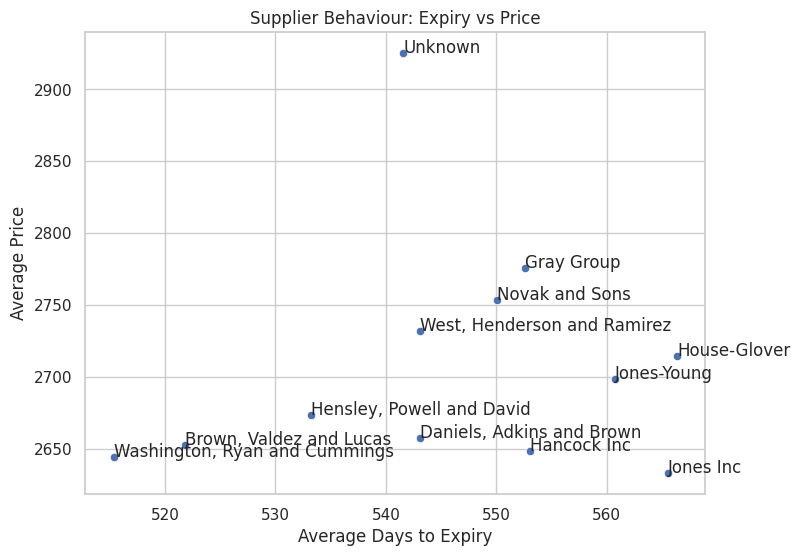

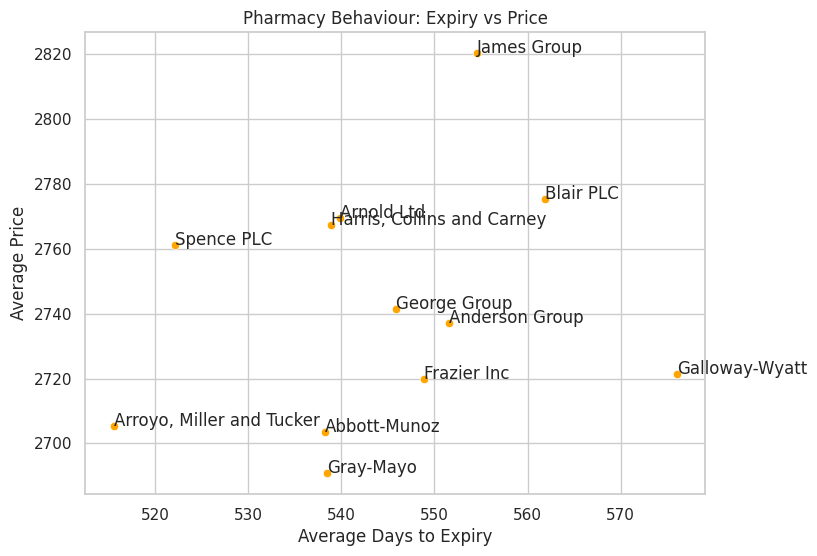

In [ ]:
# Supplier behavior: average price & expiry
supplier_behaviour = pharmacy_data.groupby('Supplier_Name').agg(
    avg_price=('Price','mean'),
    avg_expiry=('Days_to_Expiry','mean')
).reset_index()

# Displaying the largest 12 suppliers
supplier_behaviour= supplier_behaviour.nlargest(12, 'avg_price')


# Pharmacy behavior:average price & expiry
pharmacy_behaviour = pharmacy_data.groupby('Pharmacy').agg(
    avg_price=('Price','mean'),
    avg_expiry=('Days_to_Expiry','mean')
).reset_index()

# Displaying the largest 12 pharmacies
pharmacy_behaviour= pharmacy_behaviour.nlargest(12, 'avg_price')

# Plotting supplier behaviour of suppliers
plt.figure(figsize=(8,6))
sns.scatterplot(x='avg_expiry', y='avg_price', data=supplier_behaviour)
for i,row in supplier_behaviour.iterrows():
    plt.text(row['avg_expiry'], row['avg_price'], row['Supplier_Name'])
plt.title("Supplier Behaviour: Expiry vs Price")
plt.xlabel("Average Days to Expiry")
plt.ylabel("Average Price")
plt.show()

# Plotting pharmacy behaviour of pharmacies

plt.figure(figsize=(8,6))
sns.scatterplot(x='avg_expiry', y='avg_price', data=pharmacy_behaviour, color='orange')
for i,row in pharmacy_behaviour.iterrows():
    plt.text(row['avg_expiry'], row['avg_price'], row['Pharmacy'])
plt.title("Pharmacy Behaviour: Expiry vs Price")
plt.xlabel("Average Days to Expiry")
plt.ylabel("Average Price")
plt.show()


In [ ]:
%matplotlib inline
sns.set(style="whitegrid")

# date columns are datetime (dayfirst=True because your dates are d/m/Y)
pharmacy_data['Date'] = pd.to_datetime(pharmacy_data['Date'], dayfirst=True, errors='coerce')
#pharmacy_data['Expiry_Date'] = pd.to_datetime(pharmacy_data['Expiry_Date'], dayfirst=True, errors='coerce')

# Compute Days_to_Expiry
if 'Days_to_Expiry' not in pharmacy_data.columns:
    pharmacy_data['Days_to_Expiry'] = (pharmacy_data['Expiry_Date'] - pharmacy_data['Date']).dt.days

# Drop rows that are missing the key numeric fields we need (or you can impute)
pharmacy_data = pharmacy_data.dropna(subset=['Price','Quantity','Date','Expiry_Date'])



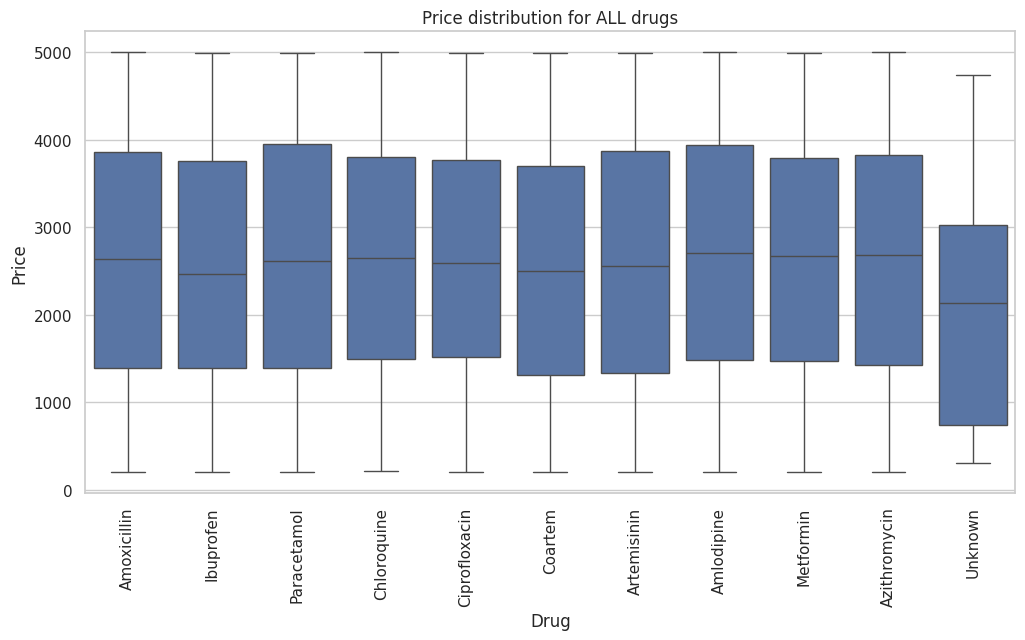

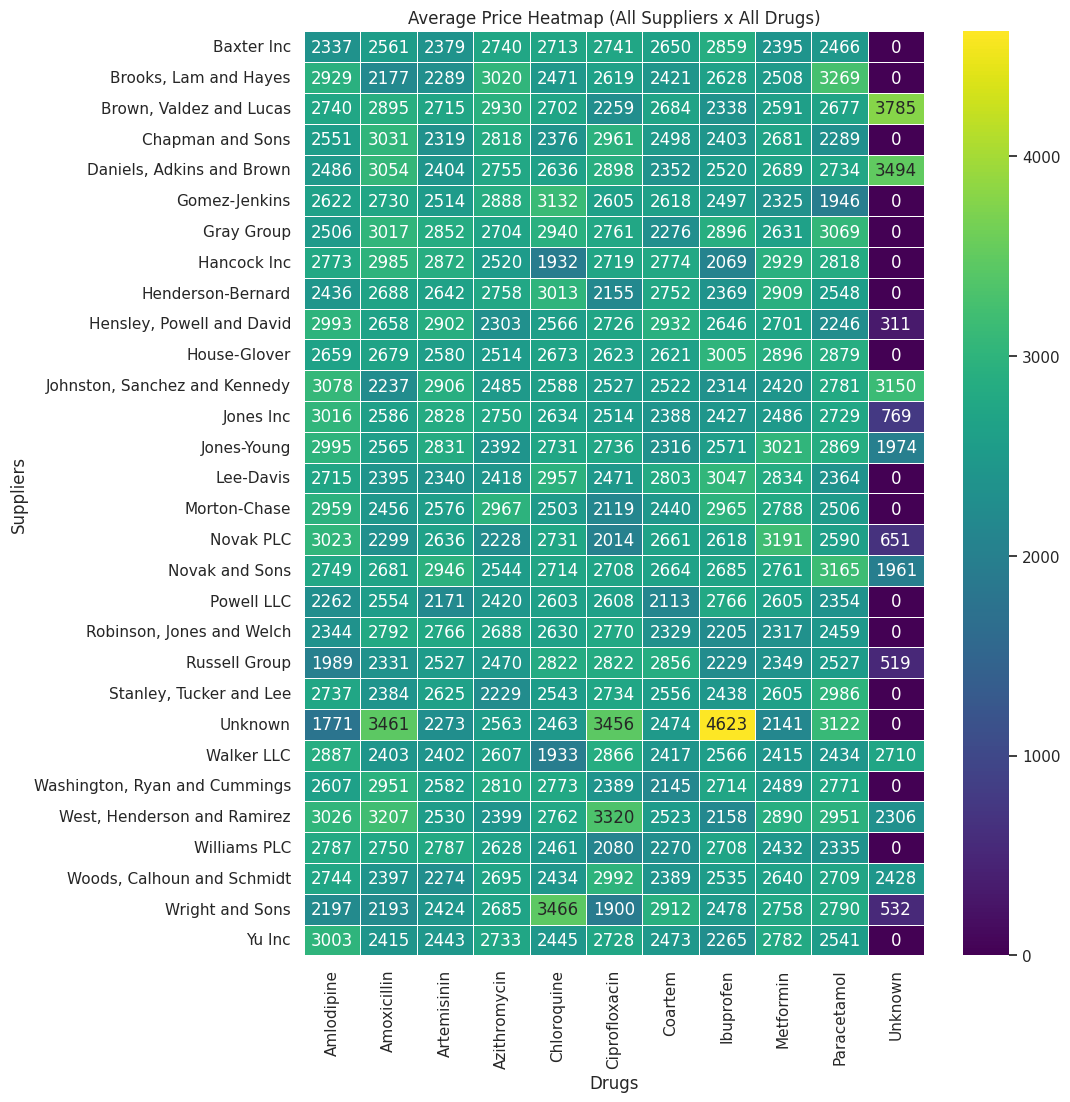

In [ ]:
#  Robust MAD z-score
def robust_zscore(x):
    med = np.median(x)
    mad = np.median(np.abs(x - med))
    if mad == 0:
        return np.zeros(len(x))
    return (x - med) / (1.4826 * mad)

#  price statistics per drug
# price statistics per drug
drug_stats = (
    pharmacy_data.groupby('Drug')['Price']
    .agg(Drug_Mean='mean', Drug_Std='std')
    .reset_index()
)

# merge stats back safely (no duplicate col names)
pharmacy_data = pharmacy_data.merge(drug_stats, on='Drug', how='left')

# Broadcast median price back to each row (row-aligned, safe)
pharmacy_data['Drug_Median_Price'] = pharmacy_data.groupby('Drug')['Price'].transform('median')

# Create high/low anomaly flags (only when std > 0)
pharmacy_data['Price_High_Anomaly'] = (
    (pharmacy_data['Price'] > (pharmacy_data['Drug_Mean'] + 3 * pharmacy_data['Drug_Std']))
    & (pharmacy_data['Drug_Std'] > 0)
)
pharmacy_data['Price_Low_Anomaly'] = (
    (pharmacy_data['Price'] < (pharmacy_data['Drug_Mean'] - 3 * pharmacy_data['Drug_Std']))
    & (pharmacy_data['Drug_Std'] > 0)
)


# combined expiry + price category
near_expiry_days = 30  # tunable
pharmacy_data['Near_Expiry'] = pharmacy_data['Days_to_Expiry'] <= near_expiry_days

pharmacy_data['Price_Undercut_Market'] = (
    pharmacy_data['Price'] < 0.7 * pharmacy_data['Drug_Median_Price']
)
pharmacy_data['Price_Over_Market'] = (
    pharmacy_data['Price'] > 2.0 * pharmacy_data['Drug_Median_Price']
)


#  supplier & pharmacy expiry z-scores
supplier_expiry = (
    pharmacy_data.groupby('Supplier_Name')['Days_to_Expiry']
    .median()
    .reset_index()
    .rename(columns={'Days_to_Expiry':'median_expiry'})
)
sup_std = supplier_expiry['median_expiry'].std()
if pd.isna(sup_std) or sup_std == 0: sup_std = 1.0
supplier_expiry['median_z'] = (
    (supplier_expiry['median_expiry'] - supplier_expiry['median_expiry'].mean()) / sup_std
)

pharmacy_expiry = (
    pharmacy_data.groupby('Pharmacy')['Days_to_Expiry']
    .median()
    .reset_index()
    .rename(columns={'Days_to_Expiry':'median_expiry'})
)
ph_std = pharmacy_expiry['median_expiry'].std()
if pd.isna(ph_std) or ph_std == 0: ph_std = 1.0
pharmacy_expiry['median_z'] = (
    (pharmacy_expiry['median_expiry'] - pharmacy_expiry['median_expiry'].mean()) / ph_std
)

# supplier & pharmacy behavior summaries
supplier_behavior = (
    pharmacy_data.groupby('Supplier_Name')
    .agg(avg_price=('Price','mean'), avg_expiry=('Days_to_Expiry','mean'), n_items=('Drug','nunique'))
    .reset_index()
)
pharmacy_behavior = (
    pharmacy_data.groupby('Pharmacy')
    .agg(avg_price=('Price','mean'), avg_expiry=('Days_to_Expiry','mean'), n_items=('Drug','nunique'))
    .reset_index()
)


# Plotting functions

def plot_price_boxplots_all_drugs(df):
    """
    Plot price distribution boxplots for ALL drugs.
    """
    plt.figure(figsize=(max(12, len(df['Drug'].unique()) * 0.6), 6))
    sns.boxplot(x='Drug', y='Price', data=df)
    plt.xticks(rotation=90)
    plt.title("Price distribution for ALL drugs")
    plt.show()


def plot_price_heatmap_supplier_drug_all(df):
    """
    Plot a heatmap showing the average price for each supplier-drug combination
    across ALL suppliers and ALL drugs, with integer annotations.
    """
    pivot = df.pivot_table(
        index='Supplier_Name',
        columns='Drug',
        values='Price',
        aggfunc='mean'
    ).fillna(0)

    # Round values to integers for annotation
    pivot_rounded = pivot.round(0).astype(int)

    # dynamic figsize depending on number of suppliers/drugs
    plt.figure(figsize=(max(10, pivot.shape[1] * 0.6), max(8, pivot.shape[0] * 0.4)))
    sns.heatmap(pivot, annot=pivot_rounded, fmt="d", linewidths=.5, cmap="viridis")
    plt.title("Average Price Heatmap (All Suppliers x All Drugs)")
    plt.xlabel("Drugs")
    plt.ylabel("Suppliers")
    plt.show()

# Declaring the functions
plot_price_boxplots_all_drugs(pharmacy_data)
plot_price_heatmap_supplier_drug_all(pharmacy_data)

In [ ]:
# Compute median price per drug
drug_median_prices = pharmacy_data.groupby('Drug')['Price'].median().reset_index()
drug_median_prices.rename(columns={'Price': 'Drug_Median_Price'}, inplace=True)

# Merge back into main data
pharmacy_data = pharmacy_data.merge(drug_median_prices, on='Drug', how='left', validate='m:1')




# Combine Expiry + Price
# Define near-expiry threshold (tune as needed)
near_expiry_days = 30

# Add flags
pharmacy_data['Near_Expiry'] = pharmacy_data['Days_to_Expiry'] <= near_expiry_days
pharmacy_data['Price_Undercut_Market'] = (pharmacy_data['Price'] - pharmacy_data['Drug_Median_Price']) / pharmacy_data['Drug_Median_Price'] <= -0.30
pharmacy_data['Price_Over_Market'] = (pharmacy_data['Price'] - pharmacy_data['Drug_Median_Price']) / pharmacy_data['Drug_Median_Price'] >= 1.0

# Categorize into combined signals
def expiry_price_category(row):
    if row['Near_Expiry'] and row['Price_Undercut_Market']:
        return 'NearExpiry + LowPrice (likely discount/dumping)'
    if row['Near_Expiry'] and row['Price_Over_Market']:
        return 'NearExpiry + HighPrice (suspicious: selling expiring at high price)'
    if (not row['Near_Expiry']) and row['Price_Undercut_Market']:
        return 'LongExpiry + LowPrice (suspicious: possible fakes/dumping)'
    if (not row['Near_Expiry']) and row['Price_Over_Market']:
        return 'LongExpiry + HighPrice (possible price gouging)'
    return 'Normal_or_No_Strong_Signal'

pharmacy_data['Expiry_Price_Category'] = pharmacy_data.apply(expiry_price_category, axis=1)


def plot_expiry_price_scatter(df, sample_frac=1.0):
    plot_df = df.sample(frac=sample_frac, random_state=1) if 0<sample_frac<1 else df
    plt.figure(figsize=(9,6))
    sns.scatterplot(x='Days_to_Expiry', y='Price', hue='Expiry_Price_Category', data=plot_df, alpha=0.6)
    plt.yscale('log')
    plt.xlabel("Days to Expiry")
    plt.ylabel("Price (log scale)")
    plt.title("Expiry vs Price (colored by combined category)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

plot_expiry_price_scatter(pharmacy_data, sample_frac=1.0)



MergeError: Passing 'suffixes' which cause duplicate columns {'Drug_Median_Price_x'} is not allowed.

### HOW BRANDS SHOW SUSPICIOUS BEHAVIOUR

In [ ]:
def plot_brand_frequency(df, top_n=30):
    """
    Plot a bar chart showing the frequency of each brand.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset containing 'Brand' column.
    top_n : int, optional (default=30)
        The number of top brands to display.
    """
    vc = df['Brand'].value_counts().nlargest(top_n)
    plt.figure(figsize=(12,5))
    sns.barplot(x=vc.index, y=vc.values)
    plt.xticks(rotation=90)
    plt.title(f"Top {top_n} Brand Frequencies")
    plt.ylabel("Count")
    plt.show()
    rare = df['Brand'].value_counts()[df['Brand'].value_counts() < 5].index.tolist()
    print("Rare/low-frequency brands (count < 5):", rare[:50])

def plot_channel_prices(df):
    """
    Plot a bar chart showing the average price per sales channel.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset containing 'Sales_Channel' and 'Price' columns.
    """
    ch = df.groupby('Sales_Channel')['Price'].mean().reset_index().sort_values('Price')
    plt.figure(figsize=(8,4))
    sns.barplot(x='Sales_Channel', y='Price', data=ch)
    plt.xticks(rotation=45)
    plt.title("Average Price by Sales Channel")
    plt.show()

# Declare the functions
plot_brand_frequency(pharmacy_data, top_n=30)
plot_channel_prices(pharmacy_data)


In [ ]:
# Dictionary mapping fake brand and correct brand
fake_brand_map = {
    "Biokare": "BioCare",
    "FarmaTrust": "PharmaTrust",
    "Hea1thFirst": "HealthFirst",
    "MediPluz": "MediPlus"
}

# Flag fake brands in the dataset
pharmacy_data["Brand_Is_Fake"] = pharmacy_data["Brand"].isin(fake_brand_map.keys())

# Optionally map them to their correct versions (if you want normalization)
pharmacy_data["Brand_Corrected"] = pharmacy_data["Brand"].replace(fake_brand_map)

plt.figure(figsize=(8,6))
sns.countplot(data=pharmacy_data, x="Location", hue="Brand_Is_Fake")
plt.title("Fake vs Real Brands by Location")
plt.xlabel("Location")
plt.ylabel("Count")
plt.legend(title="Fake Brand?", labels=["Real","Fake"])
plt.show()



# Plotting fake brands count
fake_brand_counts = pharmacy_data[pharmacy_data["Brand_Is_Fake"]]["Brand"].value_counts()
plt.figure(figsize=(8,6))
sns.barplot(x=fake_brand_counts.index, y=fake_brand_counts.values, palette="Reds")
plt.title("Frequency of Fake Brands")
plt.xlabel("Fake Brand")
plt.ylabel("Count")
plt.show()



In [ ]:
# Getting the total counts of fake brands
fake_counts = pharmacy_data.groupby(["Location","Brand_Is_Fake"])["Brand"].count().reset_index()
print(fake_counts)


In [ ]:
# Crosstab fake vs location
brand_location_crosstab = pd.crosstab(pharmacy_data["Brand_Corrected"], pharmacy_data["Location"])

plt.figure(figsize=(10,6))
sns.heatmap(brand_location_crosstab, annot=True, fmt="d", cmap="coolwarm")
plt.title("Brand Distribution across Locations (Fake corrected)")
plt.show()



In [ ]:
# Count brands
brand_counts = pharmacy_data['Brand'].value_counts().reset_index()
brand_counts.columns = ['Brand','Count']
brand_counts['Is_Fake'] = brand_counts['Brand'].isin(fake_brand_map)

plt.figure(figsize=(10,6))
sns.barplot(data=brand_counts, x='Brand', y='Count', hue='Is_Fake', dodge=False, palette=['blue','red'])
plt.xticks(rotation=45)
plt.title("Brand Frequencies with Fake Brands Highlighted")
plt.show()


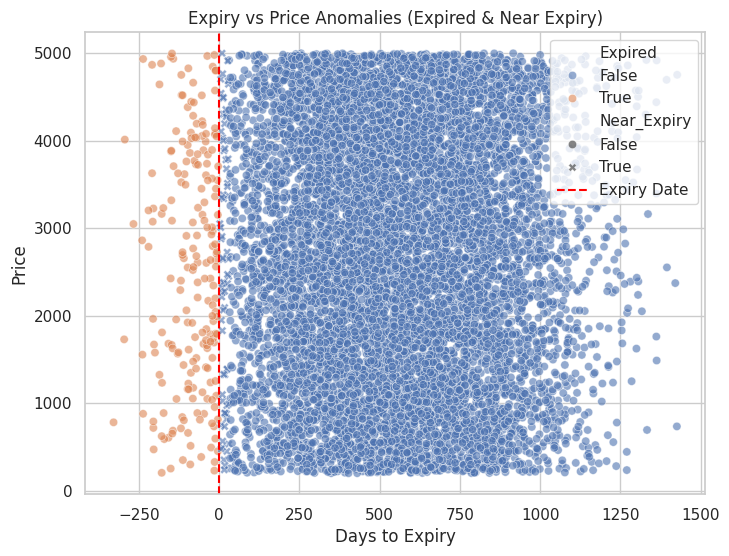

In [ ]:

# Flags
near_expiry_days = 30

pharmacy_data['Near_Expiry'] = (pharmacy_data['Days_to_Expiry'] > 0) & (pharmacy_data['Days_to_Expiry'] <= near_expiry_days)
pharmacy_data['Expired'] = pharmacy_data['Days_to_Expiry'] < 0
pharmacy_data['Price_Undercut_Market'] = (pharmacy_data['Price'] < 0.7 * pharmacy_data['Drug_Median_Price'])
pharmacy_data['Price_Over_Market']     = (pharmacy_data['Price'] > 2.0 * pharmacy_data['Drug_Median_Price'])

# Scatterplot expiry vs price
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='Days_to_Expiry',
    y='Price',
    hue='Expired',  # highlight expired drugs
    style='Near_Expiry',  # separate near-expiry visually
    data=pharmacy_data,
    alpha=0.6
)
plt.title("Expiry vs Price Anomalies (Expired & Near Expiry)")
plt.xlabel("Days to Expiry")
plt.ylabel("Price")
plt.axvline(0, color='red', linestyle='--', label="Expiry Date")  # show expiry cutoff
plt.legend()
plt.show()


In [ ]:
# A column that flags any transaction done in a month where the supplier supplies a quantity more than 2 standard deviations from the mean
# their mean supply quantity
# Create a copy of the dataset
pharm_feat_eng = pharm_data.copy()
# create a month column in original dataframe
pharm_feat_eng["Month"] = pharm_feat_eng["Date"].dt.to_period("M")

# Flag supplier monthly deviations
pharm_feat_eng["Supplier_Qty_Deviation"] = (
    pharm_feat_eng.groupby(["Supplier_Name", "Month"])["Quantity"].transform("sum")  # calculate monthly total supplies by supplier
    .groupby(pharm_feat_eng["Supplier_Name"])  # look at history per supplier
    .transform(lambda x: (x - x.mean()).abs() > 2 * x.std())
)

In [ ]:
# Flag market transactions with price deviation > 2 std from market mean
pharm_feat_eng["Market_Price_Deviation"] = (
    pharm_feat_eng.groupby(["Month", "Drug"])["Price"]
    .transform(lambda x: (x - x.mean()).abs() > 2 * x.std())
)

## Brand Popularity

In [ ]:
# Brand Popularity = share of transactions that involve each brand
brand_popularity = pharm_feat_eng["Brand"].value_counts(normalize=True)
pharm_feat_eng["Brand_popularity"] = pharm_feat_eng["Brand"].map(brand_popularity)
# Numeric rarity score for ML
pharm_feat_eng["Brand_rarity_score"] = pd.cut(
    pharm_feat_eng["Brand_popularity"],
    bins=[0, 0.01, 0.05, 1],
    labels=[2, 1, 0]   # 2=Ultra-Rare, 1=Rare, 0=Common
).astype(int)

print(pharm_feat_eng["Brand_popularity"].describe())
print()
print(pharm_feat_eng["Brand_rarity_score"].value_counts())
pharm_feat_eng[pharm_feat_eng["Brand_rarity_score"] >= 1]

count    10000.000000
mean         0.185398
std          0.062769
min          0.000800
25%          0.205300
50%          0.210600
75%          0.215300
max          0.216300
Name: Brand_popularity, dtype: float64

Brand_rarity_score
0    8475
1    1517
2       8
Name: count, dtype: int64


Date                         Pharmacy Location           Drug  \
1    2024-11-14           Baker, Mason and White    Rural    Amoxicillin   
13   2025-04-16                      Allen-Allen    Rural     Amlodipine   
19   2025-01-20                Williams and Sons    Urban     Amlodipine   
31   2025-03-14      Snyder, Campos and Callahan    Rural    Artemisinin   
37   2025-02-01                    Morales-Jones    Urban  Ciprofloxacin   
...         ...                              ...      ...            ...   
9986 2025-03-24                Williams and Sons    Rural  Ciprofloxacin   
9988 2024-11-29                        Perez Inc    Urban    Amoxicillin   
9990 2025-03-02  Rodriguez, Figueroa and Sanchez    Rural    Chloroquine   
9992 2024-08-16                        Blair PLC    Urban    Amoxicillin   
9993 2024-07-17                         Ryan PLC    Urban  Ciprofloxacin   

            Brand    Price  Quantity                  Supplier_Name  \
1     Hea1thFirst  1316.77        78          Brooks, Lam and Hayes   
13     FarmaTrust   959.16         1        Stanley, Tucker and Lee   
19    Hea1thFirst  3024.51         1               Chapman and Sons   
31       MediPluz   551.65        28                   Williams PLC   
37        Biokare  1950.33         6                      Jones Inc   
...           ...      ...       ...                            ...   
9986     MediPluz  1133.09        89                   Williams PLC   
9988     MediPluz  2775.29        74        Brown, Valdez and Lucas   
9990     MediPluz  2628.78        62                      Jones Inc   
9992  Hea1thFirst  3819.94        54  Washington, Ryan and Cummings   
9993  Hea1thFirst   903.48       100                      Lee-Davis   

     Batch_Number Expiry_Date  ...    Revenue  Year  Month_Name    Month  \
1     qz-54353-iQ  2026-09-09  ...  102708.06  2024         Nov  2024-11   
13    bQ-75433-mz  2026-05-01  ...     959.16  2025         Apr  2025-04   
19    Qy-48236-RV  2027-03-28  ...    3024.51  2025         Jan  2025-01   
31    yE-66909-aw  2025-12-13  ...   15446.20  2025         Mar  2025-03   
37    bN-10033-jp  2025-02-08  ...   11701.98  2025         Feb  2025-02   
...           ...         ...  ...        ...   ...         ...      ...   
9986  Yi-52261-Zt  2026-07-05  ...  100845.01  2025         Mar  2025-03   
9988  zB-19170-Ko  2025-12-28  ...  205371.46  2024         Nov  2024-11   
9990  YI-09155-gz  2026-11-05  ...  162984.36  2025         Mar  2025-03   
9992  pl-98356-EE  2025-01-06  ...  206276.76  2024         Aug  2024-08   
9993  GG-61932-ZP  2026-11-13  ...   90348.00  2024         Jul  2024-07   

      Year_Month  Revenue_Millions Supplier_Qty_Deviation  \
1     2024-11-01          0.102708                  False   
13    2025-04-01          0.000959                  False   
19    2025-01-01          0.003025                  False   
31    2025-03-01          0.015446                  False   
37    2025-02-01          0.011702                  False   
...          ...               ...                    ...   
9986  2025-03-01          0.100845                  False   
9988  2024-11-01          0.205371                  False   
9990  2025-03-01          0.162984                  False   
9992  2024-08-01          0.206277                  False   
9993  2024-07-01          0.090348                  False   

     Market_Price_Deviation Brand_popularity  Brand_rarity_score  
1                     False           0.0387                   1  
13                    False           0.0378                   1  
19                    False           0.0387                   1  
31                    False           0.0363                   1  
37                    False           0.0389                   1  
...                     ...              ...                 ...  
9986                  False           0.0363                   1  
9988                  False           0.0363                   

High Brand_popularity (~0.21):
These are the mainstream brands consistently present across the dataset. Likely legitimate.

Very Low Brand_popularity (~0.001):
Extremely rare brands. These are suspicious and should be investigated:

## Price per Pharmacy

In [ ]:
# Average price per pharmacy
pharmacy_avg_price = pharm_feat_eng.groupby("Pharmacy")["Price"].transform("mean")
pharm_feat_eng["Pharmacy_avg_price"] = pharmacy_avg_price

# deviation of transaction price from pharmacy average
pharm_feat_eng["Price_diff_from_pharmacy"] = pharm_feat_eng["Price"] - pharm_feat_eng["Pharmacy_avg_price"]

pharm_feat_eng.tail(10)

Date                         Pharmacy Location           Drug  \
9990 2025-03-02  Rodriguez, Figueroa and Sanchez    Rural    Chloroquine   
9991 2025-10-04                 Rodriguez-Graham    Rural      Metformin   
9992 2024-08-16                        Blair PLC    Urban    Amoxicillin   
9993 2024-07-17                         Ryan PLC    Urban  Ciprofloxacin   
9994 2024-02-11        Arroyo, Miller and Tucker    Urban   Azithromycin   
9995 2025-06-01        Arroyo, Miller and Tucker    Urban    Artemisinin   
9996 2025-06-03   Gardner, Robinson and Lawrence    Urban        Coartem   
9997 2025-02-15           Adams, Zuniga and Wong    Rural    Paracetamol   
9998 2024-11-27                       Burton Ltd    Rural    Paracetamol   
9999 2024-11-05       Harris, Collins and Carney    Urban      Ibuprofen   

            Brand    Price  Quantity                  Supplier_Name  \
9990     MediPluz  2628.78        62                      Jones Inc   
9991  HealthFirst  1519.33        81                     Gray Group   
9992  Hea1thFirst  3819.94        54  Washington, Ryan and Cummings   
9993  Hea1thFirst   903.48       100                      Lee-Davis   
9994  HealthFirst  3540.79        57               Chapman and Sons   
9995  HealthFirst  1011.04        91        Brown, Valdez and Lucas   
9996     MediPlus  2637.08        29                    Hancock Inc   
9997      BioCare   880.62         2     Woods, Calhoun and Schmidt   
9998     MediPlus  1551.45        34                   Morton-Chase   
9999     MediPlus  2339.49        21        Stanley, Tucker and Lee   

     Batch_Number Expiry_Date  ... Month_Name    Month  Year_Month  \
9990  YI-09155-gz  2026-11-05  ...        Mar  2025-03  2025-03-01   
9991  SL-38339-Da  2027-06-02  ...        Oct  2025-10  2025-10-01   
9992  pl-98356-EE  2025-01-06  ...        Aug  2024-08  2024-08-01   
9993  GG-61932-ZP  2026-11-13  ...        Jul  2024-07  2024-07-01   
9994  ZI-52576-Ew  2027-04-19  ...        Feb  2024-02  2024-02-01   
9995  MR-26437-FT  2026-12-25  ...        Jun  2025-06  2025-06-01   
9996  ti-97525-gD  2025-05-07  ...        Jun  2025-06  2025-06-01   
9997  TM-91684-Sv  2026-11-07  ...        Feb  2025-02  2025-02-01   
9998  sP-26349-uN  2027-04-16  ...        Nov  2024-11  2024-11-01   
9999  KM-53754-dr  2026-09-08  ...        Nov  2024-11  2024-11-01   

     Revenue_Millions  Supplier_Qty_Deviation  Market_Price_Deviation  \
9990         0.162984                   False                   False   
9991         0.123066                   False                   False   
9992         0.206277                   False                   False   
9993         0.090348                   False                   False   
9994         0.201825                   False                   False   
9995         0.092005                   False                   False   
9996         0.076475                    True                   False   
9997         0.001761                   False                   False   
9998         0.052749                   False                   False   
9999         0.049129                   False                   False   

     Brand_popularity Brand_rarity_score Pharmacy_avg_price  \
9990           0.0363                  1        2642.693426   
9991           0.2106                  0        2399.323709   
9992           0.0387                  1        2775.445067   
9993           0.0387                  1        2528.396444   
9994           0.2106                  0        2705.295491   
9995           0.2106                  0        2705.295491   
9996           0.2163                  0        2662.707176   
9997           0.2053                  0        2584.335243   
9998           0.2163                  0        2497.060140   
9999           0.2163                  0        2767.375283   

      Price_diff_from_pharmacy  
9990                -13.913426  
9991               -879.993709  
9992               1044.

## Supplier Switch for Pharmacies

1 if the supplier is different from the last supplier that pharmacy used for that drug.

0 otherwise.


In [ ]:
# Sort by Date to check supplier history properly
pharm_feat_eng = pharm_feat_eng.sort_values(by=["Pharmacy","Drug","Date"])

# Track previous supplier per pharmacy-drug
pharm_feat_eng["Prev_Supplier"] = pharm_feat_eng.groupby(["Pharmacy","Drug"])["Supplier_Name"].shift(1)

# Flag supplier switch
pharm_feat_eng["Supplier_switch"] = (pharm_feat_eng["Supplier_Name"] != pharm_feat_eng["Prev_Supplier"]).astype(int)

# Fill NaN (first purchase has no previous supplier) with 0
pharm_feat_eng["Supplier_switch"] = pharm_feat_eng["Supplier_switch"].fillna(0)

pharm_feat_eng.head(10)

Date      Pharmacy Location        Drug        Brand    Price  \
6739 2024-02-08  Abbott-Munoz    Rural  Amlodipine  PharmaTrust   537.60   
4718 2024-02-11  Abbott-Munoz    Rural  Amlodipine  PharmaTrust  4633.72   
1666 2024-04-10  Abbott-Munoz    Rural  Amlodipine  PharmaTrust  3710.96   
9914 2024-04-30  Abbott-Munoz    Urban  Amlodipine   FarmaTrust  1835.12   
205  2024-05-14  Abbott-Munoz    Urban  Amlodipine      BioCare   980.01   
8507 2024-05-22  Abbott-Munoz    Urban  Amlodipine   FarmaTrust  1450.06   
1442 2024-07-30  Abbott-Munoz    Urban  Amlodipine     MediPlus  2031.21   
8145 2024-09-18  Abbott-Munoz    Urban  Amlodipine  HealthFirst  2324.11   
8380 2024-10-16  Abbott-Munoz    Urban  Amlodipine     MediPlus  3976.59   
9555 2024-10-21  Abbott-Munoz    Urban  Amlodipine      BioCare  4977.67   

      Quantity                  Supplier_Name Batch_Number Expiry_Date  ...  \
6739        51                     Walker LLC  qg-36509-Aj  2026-08-29  ...   
4718        96  Washington, Ryan and Cummings  JT-16944-gr  2026-11-29  ...   
1666        82                      Lee-Davis  zx-02562-aB  2026-12-31  ...   
9914        66                     Walker LLC  vL-21098-nd  2026-08-31  ...   
205         79        Stanley, Tucker and Lee  Av-83301-TE  2025-07-13  ...   
8507        56                    Jones-Young  kK-31914-AC  2025-09-28  ...   
1442        33      Robinson, Jones and Welch  Uj-21812-OF  2026-03-26  ...   
8145        54          Brooks, Lam and Hayes  iw-06171-vS  2025-07-06  ...   
8380        93     Woods, Calhoun and Schmidt  im-73014-vQ  2025-10-08  ...   
9555        22      Daniels, Adkins and Brown  vz-17137-Zt  2026-02-07  ...   

     Year_Month Revenue_Millions  Supplier_Qty_Deviation  \
6739 2024-02-01         0.027418                   False   
4718 2024-02-01         0.444837                   False   
1666 2024-04-01         0.304299                   False   
9914 2024-04-01         0.121118                   False   
205  2024-05-01         0.077421                   False   
8507 2024-05-01         0.081203                   False   
1442 2024-07-01         0.067030                   False   
8145 2024-09-01         0.125502                   False   
8380 2024-10-01         0.369823                   False   
9555 2024-10-01         0.109509                   False   

     Market_Price_Deviation  Brand_popularity  Brand_rarity_score  \
6739                  False            0.2153                   0   
4718                  False            0.2153                   0   
1666                  False            0.2153                   0   
9914                  False            0.0378                   1   
205                   False            0.2053                   0   
8507                  False            0.0378                   1   
1442                  False            0.2163                   0   
8145                  False            0.2106                   0   
8380                  False            0.2163                   0   
9555                  False            0.2053                   0   

     Pharmacy_avg_price Price_diff_from_pharmacy  \
6739        2703.395693             -2165.795693   
4718        2703.395693              1930.324307   
1666        2703.395693              1007.564307   
9914        2703.395693              -868.275693   
205         2703.395693             -1723.385693   
8507        2703.395693             -1253.335693   
1442        2703.395693              -672.185693   
8145        2703.395693              -379.285693   
8380        2703.395693              1273.194307   
9555        2703.395693              2274.274307   

                      Prev_Supplier  Supplier_switch  
6739                            NaN                1  
4718                     Walker LLC                1  
1666  Washington, Ryan and Cummings                1  
9914                      Lee-Davis                1  
205                      Walker LLC

### Inemesit, Please take note, that the dataframe to add your new features to is "pharm_feat_eng"

In [ ]:
pharm_feat_eng.columns

Index(['Date', 'Pharmacy', 'Location', 'Drug', 'Brand', 'Price', 'Quantity',
       'Supplier_Name', 'Batch_Number', 'Expiry_Date', 'Sales_Channel',
       'Drug_Form', 'days_to_expiry', 'YearMonth', 'Revenue', 'Year',
       'Month_Name', 'Month', 'Year_Month', 'Revenue_Millions',
       'Supplier_Qty_Deviation', 'Market_Price_Deviation', 'Brand_popularity',
       'Brand_rarity_score', 'Pharmacy_avg_price', 'Price_diff_from_pharmacy',
       'Prev_Supplier', 'Supplier_switch'],
      dtype='object')

## Handling Expiry Features

In [ ]:
# Compute median price for each drug
drug_median_prices = pharm_feat_eng.groupby("Drug")["Price"].median().reset_index()
drug_median_prices.rename(columns={"Price": "Drug_Median_Price"}, inplace=True)

# Merge back into main dataframe
pharm_feat_eng = pharm_feat_eng.merge(drug_median_prices, on="Drug", how="left")


In [ ]:
# Define near expiry threshold
near_expiry_days = 30

# Near expiry (boolean → 1 if close to expiry)
pharm_feat_eng["Near_Expiry"] = (pharm_feat_eng["days_to_expiry"] <= near_expiry_days).astype(int)

# Undercut market (price at least 30% lower than median)
pharm_feat_eng["Price_Undercut_Market"] = (
    (pharm_feat_eng["Price"] - pharm_feat_eng["Drug_Median_Price"]) / pharm_feat_eng["Drug_Median_Price"] <= -0.30
).astype(int)

# Overpriced vs market (≥100% higher than median)
pharm_feat_eng["Price_Over_Market"] = (
    (pharm_feat_eng["Price"] - pharm_feat_eng["Drug_Median_Price"]) / pharm_feat_eng["Drug_Median_Price"] >= 1.0
).astype(int)


In [ ]:
pharm_feat_eng[pharm_feat_eng["Near_Expiry"] == 1].head()

Date      Pharmacy Location         Drug        Brand    Price  \
16  2025-11-01  Abbott-Munoz    Rural   Amlodipine     MediPlus  4484.90   
37  2025-12-03  Abbott-Munoz    Rural  Amoxicillin     MediPlus  3618.15   
98  2025-04-22  Abbott-Munoz    Rural  Chloroquine      BioCare  2878.61   
138 2025-09-02  Abbott-Munoz    Rural      Coartem  Hea1thFirst  1099.32   
162 2025-09-03  Abbott-Munoz    Urban    Ibuprofen      BioCare  1556.10   

     Quantity                  Supplier_Name Batch_Number Expiry_Date  ...  \
16         69  Washington, Ryan and Cummings  iV-99219-ei  2025-11-13  ...   
37         46                  Russell Group  BY-05687-hg  2025-08-17  ...   
98         98              Henderson-Bernard  us-26245-Ak  2025-04-28  ...   
138        23                  Gomez-Jenkins  cI-26849-wA  2025-09-12  ...   
162        31                      Jones Inc  xV-56728-ck  2025-01-07  ...   

    Brand_popularity Brand_rarity_score  Pharmacy_avg_price  \
16            0.2163                  0         2703.395693   
37            0.2163                  0         2703.395693   
98            0.2053                  0         2703.395693   
138           0.0387                  1         2703.395693   
162           0.2053                  0         2703.395693   

    Price_diff_from_pharmacy   Prev_Supplier  Supplier_switch  \
16               1781.504307       Jones Inc                1   
37                914.754307   Gomez-Jenkins                1   
98                175.214307  Novak and Sons                1   
138             -1604.075693      Powell LLC                1   
162             -1147.295693   Gomez-Jenkins                1   

    Drug_Median_Price Near_Expiry Price_Undercut_Market  Price_Over_Market  
16           2705.885           1                     0                  0  
37           2641.490           1                     0                  0  
98           2651.490           1                     0                  0  
138          2504.510           1                     1                  0  
162          2467.510           1                     1                  0  

[5 rows x 32 columns]

In [ ]:
features = [
    "Price",
    "Quantity",
    "Revenue",
    "days_to_expiry",
    "Supplier_Qty_Deviation",
    "Market_Price_Deviation",
    "Pharmacy_avg_price",
    "Price_diff_from_pharmacy",
    "Brand_rarity_score",
    "Supplier_switch",
    "Near_Expiry",
    "Price_Undercut_Market",
    "Price_Over_Market"
]
X = pharm_feat_eng[features].copy()

## Scale the data

Isolation Forest doesn’t require scaling strictly, but scaling helps when features are on different ranges (e.g., Price vs. Brand_popularity).


In [ ]:
# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Train Isolation Forest

In [ ]:
iso = IsolationForest(
    n_estimators=200,        # number of trees
    contamination=0.02,      # expected proportion of anomalies (tune this!)
    random_state=42
)

iso.fit(X_scaled)


IsolationForest(contamination=0.02, n_estimators=200, random_state=42)

## Predict anomalies

In [ ]:
# -1 = anomaly, 1 = normal
pharm_feat_eng["IForest_Pred"] = iso.predict(X_scaled)

# anomaly score (lower = more abnormal)
pharm_feat_eng["IForest_Score"] = iso.decision_function(X_scaled)


## Inspect anomalies

In [ ]:
# Show suspicious rows
anomalies = pharm_feat_eng[pharm_feat_eng["IForest_Pred"] == -1]

print("Number of anomalies:", anomalies.shape[0])
anomalies.head(10)


Number of anomalies: 200


Date                Pharmacy Location          Drug        Brand  \
37  2025-12-03            Abbott-Munoz    Rural   Amoxicillin     MediPlus   
136 2025-07-02            Abbott-Munoz    Rural       Coartem  Hea1thFirst   
138 2025-09-02            Abbott-Munoz    Rural       Coartem  Hea1thFirst   
162 2025-09-03            Abbott-Munoz    Urban     Ibuprofen      BioCare   
255 2025-03-20  Adams, Zuniga and Wong    Urban   Artemisinin  Hea1thFirst   
524 2025-01-27             Allen-Allen    Rural       Coartem  PharmaTrust   
561 2025-04-20             Allen-Allen    Rural     Metformin     MediPlus   
603 2024-02-07          Anderson Group    Rural   Amoxicillin  Hea1thFirst   
655 2025-08-04          Anderson Group    Rural  Azithromycin     MediPluz   
656 2025-12-02          Anderson Group    Rural  Azithromycin     MediPlus   

       Price  Quantity                Supplier_Name Batch_Number Expiry_Date  \
37   3618.15        46                Russell Group  BY-05687-hg  2025-08-17   
136  4929.63        67  West, Henderson and Ramirez  DL-75537-oY  2027-03-15   
138  1099.32        23                Gomez-Jenkins  cI-26849-wA  2025-09-12   
162  1556.10        31                    Jones Inc  xV-56728-ck  2025-01-07   
255  4804.02        40                 House-Glover  uL-63824-yl  2025-03-09   
524   254.76        56              Wright and Sons  qO-55451-WB  2025-05-27   
561   491.20        95        Brooks, Lam and Hayes  wA-70554-Tv  2025-07-15   
603  4769.78        99                Russell Group  GG-07809-lk  2025-05-23   
655  3401.57        88                 Morton-Chase  qS-09683-PI  2026-03-31   
656  2788.15        30   Woods, Calhoun and Schmidt  Mc-83403-BR  2025-04-26   

     ... Pharmacy_avg_price Price_diff_from_pharmacy  \
37   ...        2703.395693               914.754307   
136  ...        2703.395693              2226.234307   
138  ...        2703.395693             -1604.075693   
162  ...        2703.395693             -1147.295693   
255  ...        2584.335243              2219.684757   
524  ...        2475.597538             -2220.837538   
561  ...        2475.597538             -1984.397538   
603  ...        2737.171229              2032.608771   
655  ...        2737.171229               664.398771   
656  ...        2737.171229                50.978771   

                  Prev_Supplier Supplier_switch  Drug_Median_Price  \
37                Gomez-Jenkins               1           2641.490   
136                Williams PLC               1           2504.510   
138                  Powell LLC               1           2504.510   
162               Gomez-Jenkins               1           2467.510   
255                 Hancock Inc               1           2555.715   
524             Wright and Sons               0           2504.510   
561       Brooks, Lam and Hayes               0           2671.800   
603  Woods, Calhoun and Schmidt               1           2641.490   
655     Stanley, Tucker and Lee               1           2680.475   
656                Morton-Chase               1           2680.475   

     Near_Expiry Price_Undercut_Market Price_Over_Market IForest_Pred  \
37             1                     0                 0           -1   
136            0                     0                 0           -1   
138            1                     1                 0           -1   
162            1                     1                 0           -1   
255            1                     0                 0           -1   
524            0                     1                 0           -1   
561            0                     1                 0           -1   
603            0                     0                 0           -1   
655            0                     0                 0           -1   
656            1                     0                 0           -1   

     IForest_Score  
37       -0.038072  
136      -0.015909  
138      -0.080

## Evaluate / Interpret

IForest_Pred = -1 flagged as anomaly.

IForest_Score; the lower the score, the more anomalous.

In [ ]:
anomalies.describe()


Date        Price    Quantity          Expiry_Date  \
count                  200   200.000000  200.000000                  200   
mean   2025-05-24 10:40:48  2336.025600   47.675000  2025-12-03 18:28:48   
min    2024-01-06 00:00:00   206.120000    1.000000  2025-01-05 00:00:00   
25%    2025-03-03 18:00:00   905.752500   17.000000  2025-05-18 18:00:00   
50%    2025-08-01 00:00:00  2060.080000   47.000000  2025-09-14 00:00:00   
75%    2025-10-03 00:00:00  3769.880000   75.000000  2026-05-15 00:00:00   
max    2025-12-04 00:00:00  4999.850000  100.000000  2027-12-04 00:00:00   
std                    NaN  1552.258017   32.092351                  NaN   

       days_to_expiry            YearMonth       Revenue         Year  \
count      200.000000                  200     200.00000   200.000000   
mean       193.325000  2025-05-18 21:43:12  112111.70925  2024.815000   
min       -329.000000  2024-01-01 00:00:00     255.55000  2024.000000   
25%        -61.750000  2025-03-01 00:00:00   20350.60500  2025.000000   
50%         24.500000  2025-08-01 00:00:00   75431.71000  2025.000000   
75%        371.250000  2025-10-01 00:00:00  169418.29500  2025.000000   
max       1363.000000  2025-12-01 00:00:00  476262.72000  2025.000000   
std        376.502563                  NaN  117622.86793     0.389272   

                Year_Month  Revenue_Millions  ...  Brand_rarity_score  \
count                  200        200.000000  ...          200.000000   
mean   2025-05-18 21:43:12          0.112112  ...            0.450000   
min    2024-01-01 00:00:00          0.000256  ...            0.000000   
25%    2025-03-01 00:00:00          0.020351  ...            0.000000   
50%    2025-08-01 00:00:00          0.075432  ...            0.000000   
75%    2025-10-01 00:00:00          0.169418  ...            1.000000   
max    2025-12-01 00:00:00          0.476263  ...            1.000000   
std                    NaN          0.117623  ...            0.498742   

       Pharmacy_avg_price  Price_diff_from_pharmacy  Supplier_switch  \
count          200.000000                200.000000        200.00000   
mean          2622.127699               -286.102099          0.67500   
min           2399.323709              -2593.563050          0.00000   
25%           2567.431600              -1672.502505          0.00000   
50%           2623.061559               -556.283109          1.00000   
75%           2703.395693               1132.571206          1.00000   
max           2820.243050               2422.424028          1.00000   
std            103.083416               1543.685521          0.46955   

       Drug_Median_Price  Near_Expiry  Price_Undercut_Market  \
count         200.000000   200.000000             200.000000   
mean         2598.788150     0.525000               0.450000   
min          2467.510000     0.000000               0.000000   
25%          2555.715000     0.000000               0.000000   
50%          2613.270000     1.000000               0.000000   
75%          2671.800000     1.000000               1.000000   
max          2705.885000     1.000000               1.000000   
std            77.061397     0.500628               0.498742   

       Price_Over_Market  IForest_Pred  IForest_Score  
count         200.000000         200.0     200.000000  
mean            0.010000          -1.0      -0.033193  
min             0.000000          -1.0      -0.118048  
25%             0.000000          -1.0      -0.050395  
50%             0.000000          -1.0      -0.028307  
75%             0.000000          -1.0      -0.009861  
max             1.000000          -1.0      -0.000460  
std             0.099748           0.0       0.025665  

[8 rows x 21 columns]

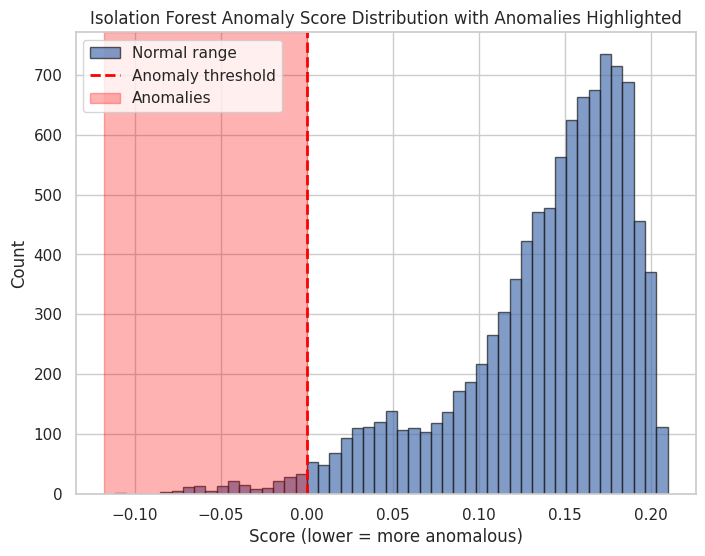

In [ ]:


# Scores
scores = pharm_feat_eng["IForest_Score"]

# Threshold from fitted model (contamination=0.02)
threshold = np.percentile(scores, 2)   # bottom 2% cutoff

# Plot histogram
plt.figure(figsize=(8,6))
plt.hist(scores, bins=50, edgecolor="k", alpha=0.7, label="Normal range")

# Shade anomalies
plt.axvline(threshold, color="red", linestyle="--", linewidth=2, label="Anomaly threshold")

# Fill area left of threshold
plt.axvspan(scores.min(), threshold, color="red", alpha=0.3, label="Anomalies")

plt.title("Isolation Forest Anomaly Score Distribution with Anomalies Highlighted")
plt.xlabel("Score (lower = more anomalous)")
plt.ylabel("Count")
plt.legend()
plt.show()


**Insights**

There’s a long left tail (below 0.0) → this is where anomalies lie.

The bulk of data is clustered around 0.10–0.18 → safe/normal transactions.

Around 0.0 to 0.05, we see a dip → a “boundary zone” where subtle anomalies live.

## Isolation Forest Feature Importance

/tmp/ipython-input-2617590167.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=iforest_imp_df, x="Importance", y="Feature", palette="viridis")


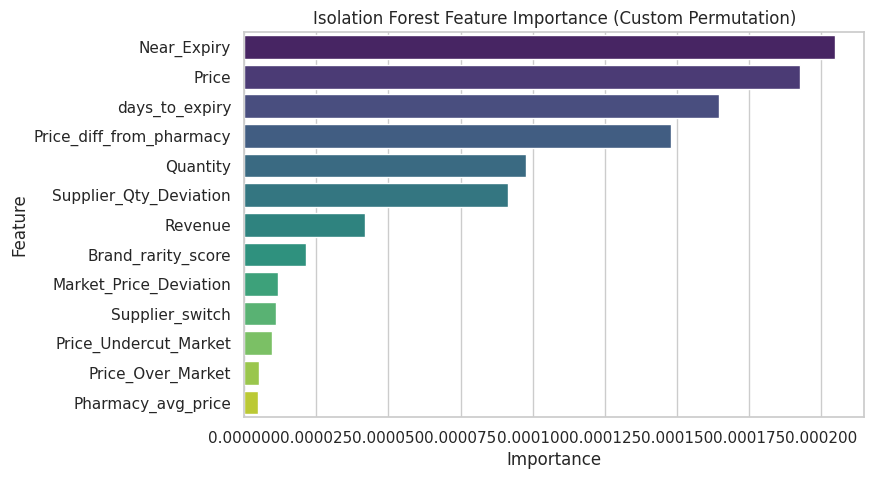

In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer

def iforest_permutation_importance(model, X, n_repeats=10, random_state=42):
    rng = np.random.RandomState(random_state)
    baseline_scores = model.decision_function(X)   # baseline anomaly scores
    baseline_var = np.var(baseline_scores)         # reference variability

    importances = []

    for col in range(X.shape[1]):
        col_scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            rng.shuffle(X_permuted[:, col])   # shuffle one feature
            permuted_scores = model.decision_function(X_permuted)
            # importance = change in variance of anomaly score
            col_scores.append(abs(np.var(permuted_scores) - baseline_var))
        importances.append(np.mean(col_scores))

    return np.array(importances)

# Run custom importance
iforest_importances = iforest_permutation_importance(iso, X_scaled, n_repeats=10)

# Put into DataFrame
iforest_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": iforest_importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=iforest_imp_df, x="Importance", y="Feature", palette="viridis")
plt.title("Isolation Forest Feature Importance (Custom Permutation)")
plt.show()

##  One Class SVM (Unsupervised)

In [ ]:
from sklearn.svm import OneClassSVM

X = pharm_feat_eng[features].fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train One-Class SVM
oc_svm = OneClassSVM(kernel="rbf", nu=0.03, gamma="scale")  # nu ~ anomaly proportion
oc_svm.fit(X_scaled)

# Predictions (-1 = anomaly, 1 = normal)
pharm_feat_eng["OCSVM_Pred"] = oc_svm.predict(X_scaled)
pharm_feat_eng["OCSVM_Score"] = oc_svm.decision_function(X_scaled)

In [ ]:
# Agreement
comparison = pd.crosstab(pharm_feat_eng["OCSVM_Pred"], pharm_feat_eng["IForest_Pred"],
                         rownames=["OCSVM"], colnames=["IsolationForest"])

agreement_rate = (pharm_feat_eng["OCSVM_Pred"] == pharm_feat_eng["IForest_Pred"]).mean()

print("Agreement Matrix:\n", comparison)
print(f"\nAgreement Rate: {agreement_rate:.2%}")

Agreement Matrix:
 IsolationForest   -1     1
OCSVM                     
-1               126   183
 1                74  9617

Agreement Rate: 97.43%


In [ ]:
# Define custom scoring function (higher = more normal)
def ocsvm_scorer(estimator, X, y=None):
    return np.mean(estimator.decision_function(X))

# Run permutation importance with custom scorer
ocsvm_perm = permutation_importance(
    oc_svm,
    X_scaled,
    y=np.zeros(X_scaled.shape[0]),  # dummy labels
    n_repeats=10,
    random_state=42,
    scoring=ocsvm_scorer
)

# Format results
ocsvm_importances = pd.DataFrame({
    "Feature": features,
    "Importance": ocsvm_perm.importances_mean
}).sort_values(by="Importance", ascending=False)

print(ocsvm_importances)

                     Feature  Importance
0                      Price    0.673840
7   Price_diff_from_pharmacy    0.671819
2                    Revenue    0.548631
11     Price_Undercut_Market    0.481861
1                   Quantity    0.231815
3             days_to_expiry    0.133826
10               Near_Expiry    0.125770
4     Supplier_Qty_Deviation    0.018197
5     Market_Price_Deviation    0.005631
12         Price_Over_Market    0.005155
6         Pharmacy_avg_price    0.004419
9            Supplier_switch    0.004147
8         Brand_rarity_score    0.002619


/tmp/ipython-input-109844552.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ocsvm_importances, x="Importance", y="Feature", palette="magma")


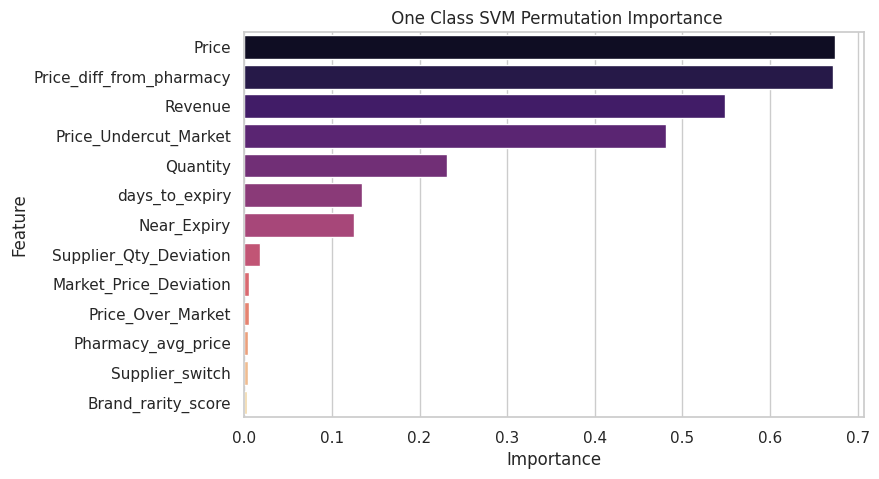

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=ocsvm_importances, x="Importance", y="Feature", palette="magma")
plt.title(" One Class SVM Permutation Importance")
plt.show()

                     Feature  Importance_IForest  Importance_OCSVM
0                Near_Expiry            0.000205          0.125770
1                      Price            0.000193          0.673840
2             days_to_expiry            0.000165          0.133826
3   Price_diff_from_pharmacy            0.000148          0.671819
4                   Quantity            0.000098          0.231815
5     Supplier_Qty_Deviation            0.000091          0.018197
6                    Revenue            0.000042          0.548631
7         Brand_rarity_score            0.000021          0.002619
8     Market_Price_Deviation            0.000012          0.005631
9            Supplier_switch            0.000011          0.004147
10     Price_Undercut_Market            0.000010          0.481861
11         Price_Over_Market            0.000005          0.005155
12        Pharmacy_avg_price            0.000005          0.004419


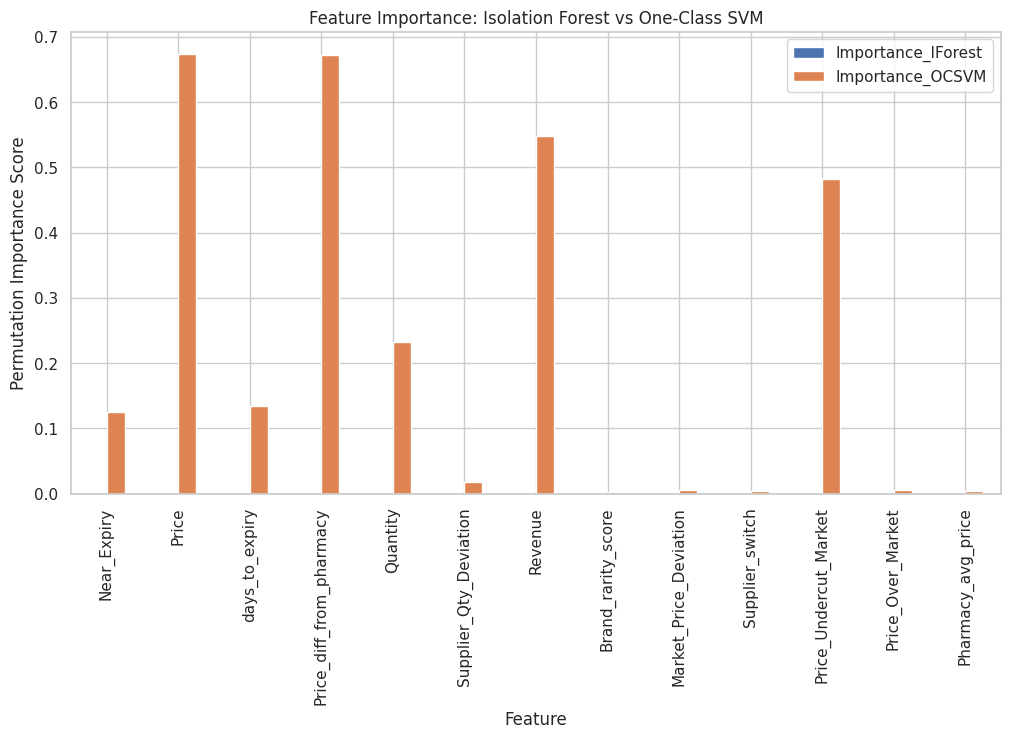

In [ ]:
comparison = iforest_imp_df.merge(
    ocsvm_importances, on="Feature", suffixes=("_IForest", "_OCSVM")
)

print(comparison.sort_values(by="Importance_IForest", ascending=False))
comparison = iforest_imp_df.merge(
    ocsvm_importances, on="Feature", suffixes=("_IForest", "_OCSVM")
)

comparison.set_index("Feature")[["Importance_IForest", "Importance_OCSVM"]].plot.bar(figsize=(12,6))
plt.title("Feature Importance: Isolation Forest vs One-Class SVM")
plt.ylabel("Permutation Importance Score")
plt.show()


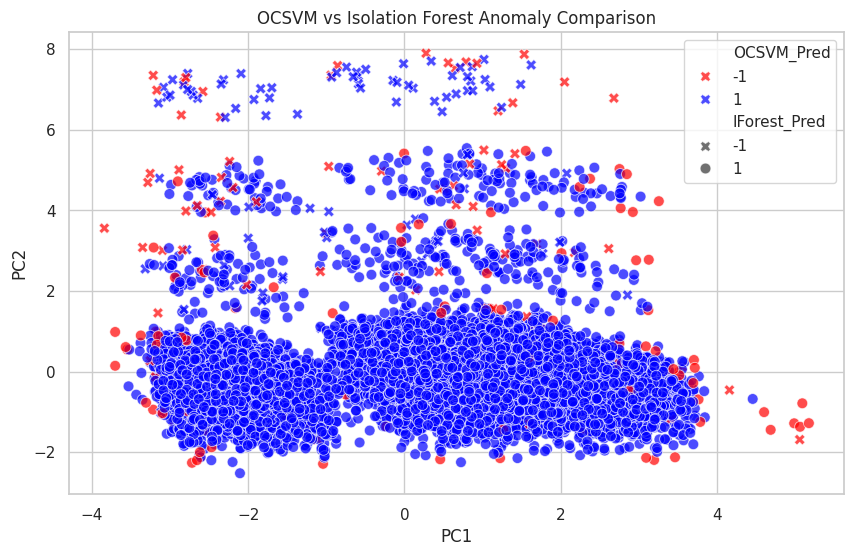

In [ ]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
pcs = pca.fit_transform(X_scaled)
viz_df = pd.DataFrame(pcs, columns=["PC1","PC2"])
viz_df["OCSVM_Pred"] = pharm_feat_eng["OCSVM_Pred"]
viz_df["IForest_Pred"] = pharm_feat_eng["IForest_Pred"]

plt.figure(figsize=(10,6))
sns.scatterplot(
    x="PC1", y="PC2", data=viz_df,
    hue="OCSVM_Pred", style="IForest_Pred",
    palette={1:"blue",-1:"red"}, markers={1:"o",-1:"X"}, s=60, alpha=0.7
)
plt.title("OCSVM vs Isolation Forest Anomaly Comparison")
plt.show()


## Self-Training SVM (semi-supervised with labels)

In [ ]:
from sklearn.svm import SVC

#  IForest_Pred (-1 = anomaly, 1 = normal)
pharm_feat_eng["Pseudo_Label"] = pharm_feat_eng["IForest_Pred"]
y = pharm_feat_eng["Pseudo_Label"]

X_scaled = scaler.fit_transform(X)

# Train SVM with pseudo-labels
svc = SVC(kernel="rbf", probability=True, class_weight="balanced")
svc.fit(X_scaled, y)

SVC(class_weight='balanced', probability=True)

In [ ]:
# Predict with SVM
pharm_feat_eng["SVC_Pred"] = svc.predict(X_scaled)
pharm_feat_eng["SVC_Prob"] = svc.predict_proba(X_scaled)[:,1]  # prob of being normal

# Extract anomalies
svc_anomalies = pharm_feat_eng[pharm_feat_eng["SVC_Pred"] == -1]

print("Number of anomalies detected by SVM:", svc_anomalies.shape[0])
svc_anomalies.head()


Number of anomalies detected by SVM: 315


Date      Pharmacy Location           Drug        Brand    Price  \
37  2025-12-03  Abbott-Munoz    Rural    Amoxicillin     MediPlus  3618.15   
45  2024-06-24  Abbott-Munoz    Urban    Artemisinin  HealthFirst  3763.14   
118 2025-03-19  Abbott-Munoz    Urban  Ciprofloxacin      Biokare  3252.52   
136 2025-07-02  Abbott-Munoz    Rural        Coartem  Hea1thFirst  4929.63   
138 2025-09-02  Abbott-Munoz    Rural        Coartem  Hea1thFirst  1099.32   

     Quantity                Supplier_Name Batch_Number Expiry_Date  ...  \
37         46                Russell Group  BY-05687-hg  2025-08-17  ...   
45         95                  Hancock Inc  OQ-50933-To  2026-12-29  ...   
118        89                    Jones Inc  ax-45187-ms  2026-07-07  ...   
136        67  West, Henderson and Ramirez  DL-75537-oY  2027-03-15  ...   
138        23                Gomez-Jenkins  cI-26849-wA  2025-09-12  ...   

    Near_Expiry Price_Undercut_Market  Price_Over_Market IForest_Pred  \
37            1                     0                  0           -1   
45            0                     0                  0            1   
118           0                     0                  0            1   
136           0                     0                  0           -1   
138           1                     1                  0           -1   

     IForest_Score  OCSVM_Pred OCSVM_Score Pseudo_Label SVC_Pred  SVC_Prob  
37       -0.038072           1    1.429839           -1       -1  0.205205  
45        0.017424           1    0.852628            1       -1  0.857402  
118       0.002791           1    1.719800            1       -1  0.483960  
136      -0.015909           1    0.000321           -1       -1  0.222522  
138      -0.080690          -1   -0.376445           -1       -1  0.177356  

[5 rows x 39 columns]

Why this helps?

Isolation Forest gives a rough first cut.

SVM then learns a decision boundary using expiry + price features; sharper anomaly detection.

You can compare overlap between IForest_Pred and SVC_Pred; suppliers/brands flagged by both are high-confidence frauds.

### PCA (Principal Component Analysis) Scatter Plot

This shows how anomalies are separated from normal data in a compressed 2D space.

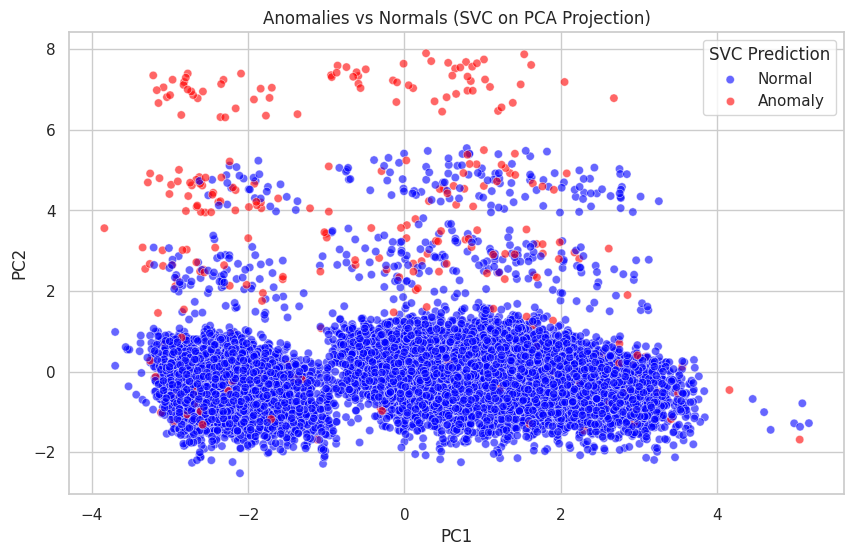

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Add results to DataFrame
viz_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
viz_df["SVC_Pred"] = pharm_feat_eng["SVC_Pred"]  # 1 = normal, -1 or 0 = anomaly depending on labels

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=viz_df,
    x="PC1", y="PC2",
    hue="SVC_Pred",
    palette={1: "blue", -1: "red", 0: "red"},
    alpha=0.6
)
plt.title("Anomalies vs Normals (SVC on PCA Projection)")
plt.legend(title="SVC Prediction", labels=["Normal", "Anomaly"])
plt.show()


## SVM Feature Importance

/tmp/ipython-input-360362610.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=svc_imp_df, x="Importance", y="Feature", palette="magma")


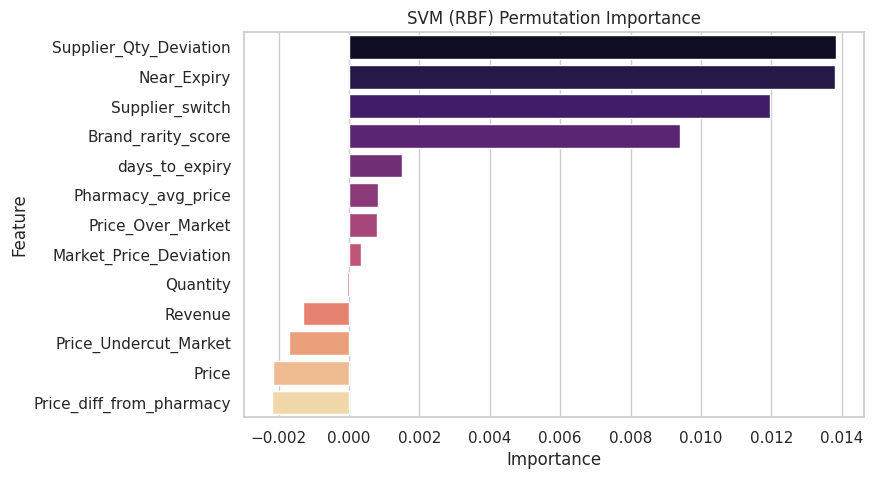

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
result = permutation_importance(svc, X_scaled, y, n_repeats=10, random_state=42)

svc_imp_df = pd.DataFrame({
    "Feature": features,
    "Importance": result.importances_mean
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=svc_imp_df, x="Importance", y="Feature", palette="magma")
plt.title("SVM (RBF) Permutation Importance")
plt.show()


In [ ]:
svc_imp_df

Feature  Importance
4     Supplier_Qty_Deviation     0.01384
10               Near_Expiry     0.01381
9            Supplier_switch     0.01197
8         Brand_rarity_score     0.00939
3             days_to_expiry     0.00149
6         Pharmacy_avg_price     0.00081
12         Price_Over_Market     0.00080
5     Market_Price_Deviation     0.00033
1                   Quantity    -0.00006
2                    Revenue    -0.00130
11     Price_Undercut_Market    -0.00171
0                      Price    -0.00217
7   Price_diff_from_pharmacy    -0.00218

Supplier behavior (deviation, switching) is the biggest red flag.

Expiry patterns are also highly predictive of fraud.

Brand rarity matters but less so than supplier/expiry features.

Price-related features surprisingly don’t drive the model much; perhaps fraudsters don’t always manipulate price directly.

In [ ]:
"""import shap

explainer = shap.KernelExplainer(svc.predict_proba, X_scaled[:200])  # sample for speed
shap_values = explainer.shap_values(X_scaled[:100])  # explain 100 samples

# Summary plot
shap.summary_plot(shap_values, X, feature_names=features)
"""

'import shap\n\nexplainer = shap.KernelExplainer(svc.predict_proba, X_scaled[:200])  # sample for speed\nshap_values = explainer.shap_values(X_scaled[:100])  # explain 100 samples\n\n# Summary plot\nshap.summary_plot(shap_values, X, feature_names=features)\n'

## Cross-tab comparison

This shows:

How many were normal in both (1,1).

How many anomalies only Isolation Forest caught (-1,1).

How many anomalies only SVM caught (1,-1).

How many both agree on (-1,-1).

In [ ]:
# Cross-tab of predictions
comparison = pd.crosstab(
    pharm_feat_eng["IForest_Pred"],
    pharm_feat_eng["SVC_Pred"],
    rownames=["IsolationForest"],
    colnames=["SVM"]
)

print(comparison)
# Agreement rate
agreement_rate = (pharm_feat_eng["SVC_Pred"].values == pharm_feat_eng["IForest_Pred"].values).mean()
print(f"\nAgreement Rate: {agreement_rate:.2%}")

SVM               -1     1
IsolationForest           
-1               200     0
 1               115  9685

Agreement Rate: 98.85%


## Overlap analysis

In [ ]:
# Flag consensus anomalies (both methods agree)
pharm_feat_eng["Consensus_Anomaly"] = (
    (pharm_feat_eng["IForest_Pred"] == -1) &
    (pharm_feat_eng["SVC_Pred"] == -1)
).astype(int)

# Extract them
consensus_anomalies = pharm_feat_eng[pharm_feat_eng["Consensus_Anomaly"] == 1]

print("Consensus anomalies:", consensus_anomalies.shape[0])
consensus_anomalies.head()


Consensus anomalies: 200


Date                Pharmacy Location         Drug        Brand  \
37  2025-12-03            Abbott-Munoz    Rural  Amoxicillin     MediPlus   
136 2025-07-02            Abbott-Munoz    Rural      Coartem  Hea1thFirst   
138 2025-09-02            Abbott-Munoz    Rural      Coartem  Hea1thFirst   
162 2025-09-03            Abbott-Munoz    Urban    Ibuprofen      BioCare   
255 2025-03-20  Adams, Zuniga and Wong    Urban  Artemisinin  Hea1thFirst   

       Price  Quantity                Supplier_Name Batch_Number Expiry_Date  \
37   3618.15        46                Russell Group  BY-05687-hg  2025-08-17   
136  4929.63        67  West, Henderson and Ramirez  DL-75537-oY  2027-03-15   
138  1099.32        23                Gomez-Jenkins  cI-26849-wA  2025-09-12   
162  1556.10        31                    Jones Inc  xV-56728-ck  2025-01-07   
255  4804.02        40                 House-Glover  uL-63824-yl  2025-03-09   

     ... Price_Undercut_Market Price_Over_Market  IForest_Pred IForest_Score  \
37   ...                     0                 0            -1     -0.038072   
136  ...                     0                 0            -1     -0.015909   
138  ...                     1                 0            -1     -0.080690   
162  ...                     1                 0            -1     -0.065150   
255  ...                     0                 0            -1     -0.011425   

     OCSVM_Pred  OCSVM_Score Pseudo_Label SVC_Pred  SVC_Prob  \
37            1     1.429839           -1       -1  0.205205   
136           1     0.000321           -1       -1  0.222522   
138          -1    -0.376445           -1       -1  0.177356   
162           1     1.026130           -1       -1  0.196741   
255           1     0.217643           -1       -1  0.222181   

     Consensus_Anomaly  
37                   1  
136                  1  
138                  1  
162                  1  
255                  1  

[5 rows x 40 columns]

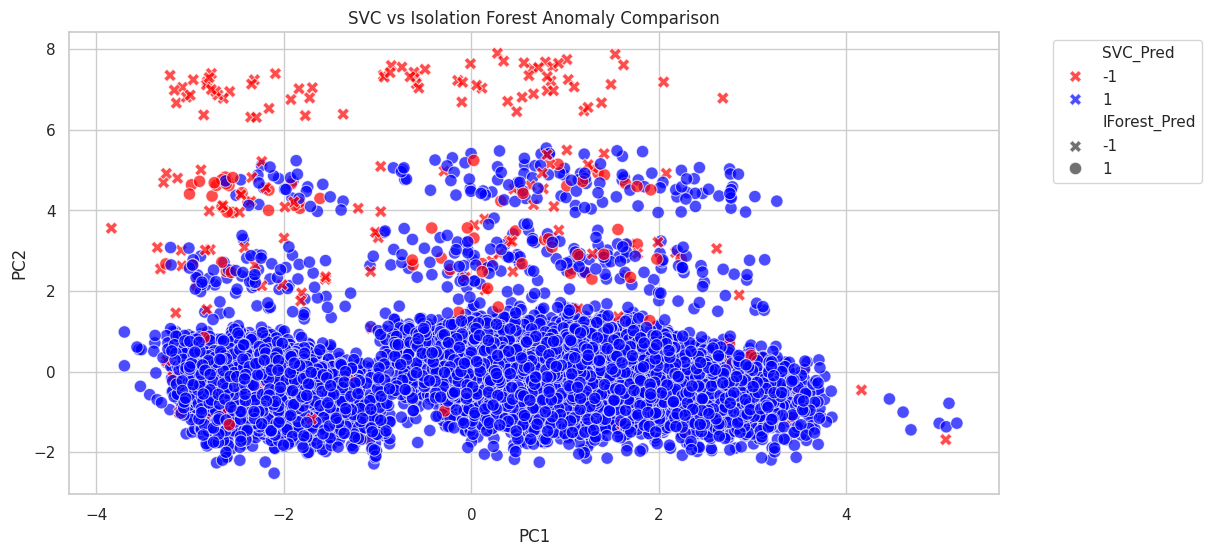

In [ ]:
from sklearn.decomposition import PCA

# Step 1: Run PCA on your scaled feature set
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Step 2: Build the viz DataFrame with PCA results
viz_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
viz_df["SVC_Pred"] = pharm_feat_eng["SVC_Pred"].values
viz_df["IForest_Pred"] = pharm_feat_eng["IForest_Pred"].values  # align index

# Step 3: Plot comparison
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=viz_df,
    x="PC1", y="PC2",
    hue="SVC_Pred",
    style="IForest_Pred",
    palette={1: "blue", -1: "red"},  # blue = normal, red = anomaly
    markers={1: "o", -1: "X"},       # normal = circle, anomaly = X
    s=80,                            # point size
    alpha=0.7
)
plt.title("SVC vs Isolation Forest Anomaly Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


## Visualize overlap (Venn diagram)

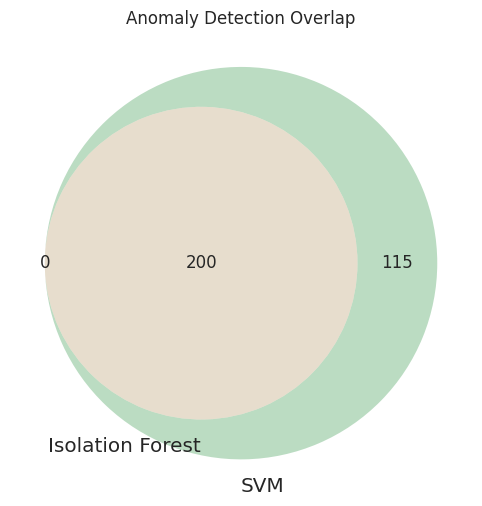

In [ ]:
from matplotlib_venn import venn2

# Get sets of indices
iforest_set = set(pharm_feat_eng[pharm_feat_eng["IForest_Pred"] == -1].index)
svc_set = set(pharm_feat_eng[pharm_feat_eng["SVC_Pred"] == -1].index)

plt.figure(figsize=(6,6))
venn2([iforest_set, svc_set], set_labels=("Isolation Forest", "SVM"))
plt.title("Anomaly Detection Overlap")
plt.show()


## Three-way comparison

In [ ]:
 # Crosstab between Isolation Forest and One-Class SVM
ct_if_oc = pd.crosstab(pharm_feat_eng["IForest_Pred"], pharm_feat_eng["OCSVM_Pred"],
                       rownames=["Isolation Forest"], colnames=["One-Class SVM"])
print("Isolation Forest vs One-Class SVM")
print(ct_if_oc)

# Crosstab between Isolation Forest and Self-learning SVM
ct_if_svc = pd.crosstab(pharm_feat_eng["IForest_Pred"], pharm_feat_eng["SVC_Pred"],
                        rownames=["Isolation Forest"], colnames=["Self-learning SVM"])
print("\nIsolation Forest vs Self-learning SVM")
print(ct_if_svc)

# Crosstab between OCSVM and SVC
ct_oc_svc = pd.crosstab(pharm_feat_eng["OCSVM_Pred"], pharm_feat_eng["SVC_Pred"],
                        rownames=["One-Class SVM"], colnames=["Self-learning SVM"])
print("\nOne-Class SVM vs Self-learning SVM")
print(ct_oc_svc)


Isolation Forest vs One-Class SVM
One-Class SVM      -1     1
Isolation Forest           
-1                126    74
 1                183  9617

Isolation Forest vs Self-learning SVM
Self-learning SVM   -1     1
Isolation Forest            
-1                 200     0
 1                 115  9685

One-Class SVM vs Self-learning SVM
Self-learning SVM   -1     1
One-Class SVM               
-1                 146   163
 1                 169  9522


In [ ]:
# Majority vote across 3 models
pharm_feat_eng["Consensus_Anomaly"] = (
    (pharm_feat_eng["IForest_Pred"] == -1).astype(int) +
    (pharm_feat_eng["OCSVM_Pred"] == -1).astype(int) +
    (pharm_feat_eng["SVC_Pred"] == -1).astype(int)
)

# If at least 2 out of 3 say anomaly => consensus anomaly
pharm_feat_eng["Consensus_Anomaly"] = (pharm_feat_eng["Consensus_Anomaly"] >= 2).astype(int)
pharm_feat_eng


Date           Pharmacy Location         Drug        Brand  \
0    2024-02-08       Abbott-Munoz    Rural   Amlodipine  PharmaTrust   
1    2024-02-11       Abbott-Munoz    Rural   Amlodipine  PharmaTrust   
2    2024-04-10       Abbott-Munoz    Rural   Amlodipine  PharmaTrust   
3    2024-04-30       Abbott-Munoz    Urban   Amlodipine   FarmaTrust   
4    2024-05-14       Abbott-Munoz    Urban   Amlodipine      BioCare   
...         ...                ...      ...          ...          ...   
9995 2025-04-20  Williams and Sons    Urban  Paracetamol   FarmaTrust   
9996 2025-04-24  Williams and Sons    Urban  Paracetamol     MediPlus   
9997 2025-05-02  Williams and Sons    Rural  Paracetamol     MediPlus   
9998 2025-06-02  Williams and Sons    Rural  Paracetamol      BioCare   
9999 2025-06-03  Williams and Sons    Urban  Paracetamol     MediPluz   

        Price  Quantity                  Supplier_Name Batch_Number  \
0      537.60        51                     Walker LLC  qg-36509-Aj   
1     4633.72        96  Washington, Ryan and Cummings  JT-16944-gr   
2     3710.96        82                      Lee-Davis  zx-02562-aB   
3     1835.12        66                     Walker LLC  vL-21098-nd   
4      980.01        79        Stanley, Tucker and Lee  Av-83301-TE   
...       ...       ...                            ...          ...   
9995  3316.33        58                     Powell LLC  Lp-09274-RK   
9996  2195.26        14     Woods, Calhoun and Schmidt  RH-56641-DF   
9997  3583.72        42                         Yu Inc  gi-38721-bn   
9998  4813.77        46                      Jones Inc  aI-91103-LC   
9999  2636.91        70                        Unknown  eT-27722-XD   

     Expiry_Date  ... Price_Over_Market IForest_Pred  IForest_Score  \
0     2026-08-29  ...                 0            1       0.141831   
1     2026-11-29  ...                 0            1       0.075125   
2     2026-12-31  ...                 0            1       0.151992   
3     2026-08-31  ...                 0            1       0.081185   
4     2025-07-13  ...                 0            1       0.165146   
...          ...  ...               ...          ...            ...   
9995  2027-01-28  ...                 0            1       0.148821   
9996  2026-01-31  ...                 0            1       0.179846   
9997  2026-05-28  ...                 0            1       0.197677   
9998  2027-06-03  ...                 0            1       0.152534   
9999  2025-05-24  ...                 0            1       0.009426   

     OCSVM_Pred  OCSVM_Score  Pseudo_Label SVC_Pred  SVC_Prob  \
0             1     4.035007             1        1  1.000000   
1             1     1.410269             1        1  0.999994   
2             1     4.599313             1        1  1.000000   
3             1     4.905131             1        1  1.000000   
4             1     4.677814             1        1  1.000000   
...         ...          ...           ...      ...       ...   
9995          1     7.270510             1        1  1.000000   
9996          1     4.690947             1        1  1.000000   
9997          1     7.495604             1        1  1.000000   
9998          1     5.823653             1        1  1.000000   
9999          1     1.678804             1       -1  0.381131   

     Consensus_Anomaly  Risk_Level  
0                    0    Low Risk  
1                    0    Low Risk  
2                    0    Low Risk  
3                    0    Low Risk  
4                    0    Low Risk  
...                ...         ...  
9995                 0    Low Risk  
9996                 0    Low Risk  
9997                 0    Low Risk  
9998                 0    Low Risk  
9999                 0    Low Risk  

[10000 rows x 41 columns]

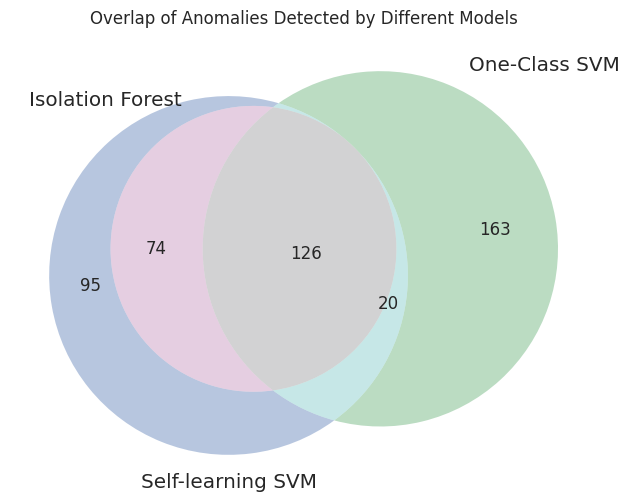

In [ ]:
from matplotlib_venn import venn3

# Define anomaly sets
iforest_set = set(pharm_feat_eng[pharm_feat_eng["IForest_Pred"] == -1].index)
ocsvm_set   = set(pharm_feat_eng[pharm_feat_eng["OCSVM_Pred"] == -1].index)
svc_set     = set(pharm_feat_eng[pharm_feat_eng["SVC_Pred"] == -1].index)

# Plot Venn diagram
plt.figure(figsize=(8,6))
venn3([iforest_set, ocsvm_set, svc_set],
      set_labels=("Isolation Forest", "One-Class SVM", "Self-learning SVM"))
plt.title("Overlap of Anomalies Detected by Different Models")
plt.show()


## Retrieve Anomalies Dataframe

In [ ]:
anomalies_df = pharm_feat_eng[pharm_feat_eng["Consensus_Anomaly"] == 1]
anomalies_df.head(10)

Date                Pharmacy Location           Drug        Brand  \
37  2025-12-03            Abbott-Munoz    Rural    Amoxicillin     MediPlus   
136 2025-07-02            Abbott-Munoz    Rural        Coartem  Hea1thFirst   
138 2025-09-02            Abbott-Munoz    Rural        Coartem  Hea1thFirst   
162 2025-09-03            Abbott-Munoz    Urban      Ibuprofen      BioCare   
255 2025-03-20  Adams, Zuniga and Wong    Urban    Artemisinin  Hea1thFirst   
511 2025-08-01             Allen-Allen    Urban  Ciprofloxacin  PharmaTrust   
524 2025-01-27             Allen-Allen    Rural        Coartem  PharmaTrust   
561 2025-04-20             Allen-Allen    Rural      Metformin     MediPlus   
603 2024-02-07          Anderson Group    Rural    Amoxicillin  Hea1thFirst   
655 2025-08-04          Anderson Group    Rural   Azithromycin     MediPluz   

       Price  Quantity                Supplier_Name Batch_Number Expiry_Date  \
37   3618.15        46                Russell Group  BY-05687-hg  2025-08-17   
136  4929.63        67  West, Henderson and Ramirez  DL-75537-oY  2027-03-15   
138  1099.32        23                Gomez-Jenkins  cI-26849-wA  2025-09-12   
162  1556.10        31                    Jones Inc  xV-56728-ck  2025-01-07   
255  4804.02        40                 House-Glover  uL-63824-yl  2025-03-09   
511   478.14        88               Novak and Sons  eN-34756-BV  2025-08-07   
524   254.76        56              Wright and Sons  qO-55451-WB  2025-05-27   
561   491.20        95        Brooks, Lam and Hayes  wA-70554-Tv  2025-07-15   
603  4769.78        99                Russell Group  GG-07809-lk  2025-05-23   
655  3401.57        88                 Morton-Chase  qS-09683-PI  2026-03-31   

     ... Price_Over_Market IForest_Pred  IForest_Score OCSVM_Pred  \
37   ...                 0           -1      -0.038072          1   
136  ...                 0           -1      -0.015909         -1   
138  ...                 0           -1      -0.080690         -1   
162  ...                 0           -1      -0.065150          1   
255  ...                 0           -1      -0.011425          1   
511  ...                 0            1       0.003833         -1   
524  ...                 0           -1      -0.007095         -1   
561  ...                 0           -1      -0.003575         -1   
603  ...                 0           -1      -0.003074         -1   
655  ...                 0           -1      -0.005164          1   

     OCSVM_Score  Pseudo_Label SVC_Pred  SVC_Prob Consensus_Anomaly  \
37      2.041265            -1       -1  0.205205                 1   
136    -0.104374            -1       -1  0.222522                 1   
138    -2.260184            -1       -1  0.177356                 1   
162     1.311415            -1       -1  0.196741                 1   
255     0.000398            -1       -1  0.222181                 1   
511    -0.601517             1       -1  0.099379                 1   
524    -0.044931            -1       -1  0.130583                 1   
561    -1.278704            -1       -1  0.222494                 1   
603   -10.163117            -1       -1  0.222473                 1   
655     0.342170            -1       -1  0.222335                 1   

      Risk_Level  
37   Medium Risk  
136  Medium Risk  
138    High Risk  
162  Medium Risk  
255  Medium Risk  
511  Medium Risk  
524  Medium Risk  
561    High Risk  
603    High Risk  
655  Medium Risk  

[10 rows x 41 columns]

## Risk Scoring

In [ ]:
# Create a column that flags based on model output
def flag_status(row):
  # If both models classified as anomalous
  if row["IForest_Pred"] == -1 and row["OCSVM_Pred"] == -1:
    return "High Risk"m
  elif row["IForest_Pred"] == -1 or row["OCSVM_Pred"] == -1:
    return "Medium Risk"
  else:
    return "Low Risk"

# apply the function
pharm_feat_eng["Risk_Level"] = pharm_feat_eng.apply(flag_status, axis=1)

In [ ]:
pharm_feat_eng["Risk_Level"].value_counts()

Risk_Level
Low Risk       9685
Medium Risk     224
High Risk        91
Name: count, dtype: int64

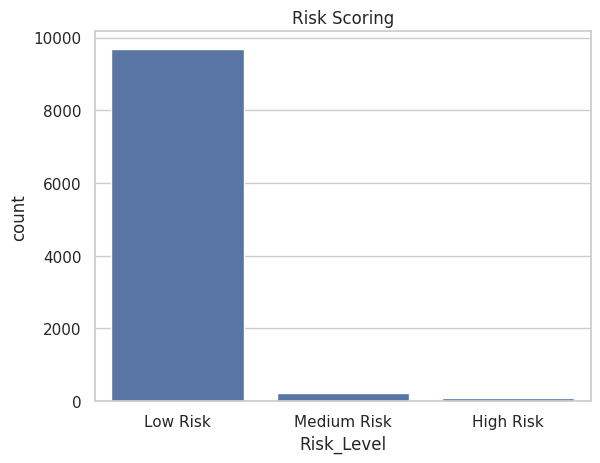

In [ ]:
sns.countplot(data=pharm_feat_eng, x="Risk_Level")
plt.title("Risk Scoring")
plt.show()

### Check those who populate the high-risk group

In [ ]:
high_risk = pharm_feat_eng[pharm_feat_eng["Risk_Level"] == "High Risk"]

In [ ]:
high_risk["Supplier_Name"].value_counts()

Supplier_Name
Jones Inc                        15
Brooks, Lam and Hayes             9
Gomez-Jenkins                     5
Novak PLC                         5
Daniels, Adkins and Brown         5
Gray Group                        5
Hensley, Powell and David         4
Hancock Inc                       4
West, Henderson and Ramirez       4
Powell LLC                        4
House-Glover                      4
Morton-Chase                      3
Novak and Sons                    3
Washington, Ryan and Cummings     3
Wright and Sons                   3
Stanley, Tucker and Lee           3
Yu Inc                            2
Woods, Calhoun and Schmidt        2
Williams PLC                      2
Russell Group                     1
Brown, Valdez and Lucas           1
Robinson, Jones and Welch         1
Chapman and Sons                  1
Henderson-Bernard                 1
Walker LLC                        1
Name: count, dtype: int64

In [ ]:
high_risk[high_risk["Supplier_Name"] == "Brooks, Lam and Hayes"]

Date                      Pharmacy Location           Drug  \
561  2025-04-20                   Allen-Allen    Rural      Metformin   
813  2025-01-27                    Arnold Ltd    Urban    Artemisinin   
3052 2025-01-18         Dyer, Potter and Mack    Urban    Artemisinin   
5413 2025-10-03  Henderson, Ramirez and Lewis    Rural     Amlodipine   
6148 2024-08-27                   James Group    Rural  Ciprofloxacin   
6195 2025-12-03                   James Group    Urban      Ibuprofen   
7322 2025-05-04    Reid, Ferguson and Sanchez    Rural        Coartem   
7914 2025-10-03              Rodriguez-Graham    Rural    Chloroquine   
8257 2025-09-01     Ross, Robinson and Bright    Rural    Amoxicillin   

            Brand    Price  Quantity          Supplier_Name Batch_Number  \
561      MediPlus   491.20        95  Brooks, Lam and Hayes  wA-70554-Tv   
813      MediPluz  1206.59        90  Brooks, Lam and Hayes  Wp-97317-co   
3052      BioCare   820.23        70  Brooks, Lam and Hayes  VT-50198-dS   
5413   FarmaTrust  4999.85         6  Brooks, Lam and Hayes  KN-07279-OK   
6148      BioCare   226.68         7  Brooks, Lam and Hayes  KN-13403-EJ   
6195  PharmaTrust   624.49        23  Brooks, Lam and Hayes  nB-26701-eL   
7322  PharmaTrust  1232.54        61  Brooks, Lam and Hayes  yp-95350-OY   
7914  Hea1thFirst  2398.76        85  Brooks, Lam and Hayes  QR-05225-JK   
8257  Hea1thFirst   880.35        82  Brooks, Lam and Hayes  IW-45604-wf   

     Expiry_Date  ... Price_Over_Market IForest_Pred  IForest_Score  \
561   2025-07-15  ...                 0           -1      -0.003575   
813   2025-10-18  ...                 0           -1      -0.021108   
3052  2025-02-10  ...                 0           -1      -0.042457   
5413  2025-10-12  ...                 0           -1      -0.026595   
6148  2025-12-10  ...                 0           -1      -0.026140   
6195  2025-06-07  ...                 0           -1      -0.016388   
7322  2026-07-11  ...                 0           -1      -0.027433   
7914  2026-05-24  ...                 0           -1      -0.027793   
8257  2025-01-07  ...                 0           -1      -0.025454   

     OCSVM_Pred  OCSVM_Score  Pseudo_Label SVC_Pred  SVC_Prob  \
561          -1    -0.475727            -1       -1  0.222494   
813          -1    -0.403767            -1       -1  0.222712   
3052         -1    -2.077494            -1       -1  0.222260   
5413         -1    -0.935841            -1       -1  0.161658   
6148         -1    -0.937341            -1       -1  0.222520   
6195         -1    -0.780975            -1       -1  0.055163   
7322         -1    -0.841193            -1       -1  0.222371   
7914         -1    -0.267632            -1       -1  0.222371   
8257         -1    -0.026804            -1       -1  0.095593   

     Consensus_Anomaly  Risk_Level  
561                  1   High Risk  
813                  1   High Risk  
3052                 1   High Risk  
5413                 1   High Risk  
6148                 1   High Risk  
6195                 1   High Risk  
7322                 1   High Risk  
7914                 1   High Risk  
8257                 1   High Risk  

[9 rows x 41 columns]